In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109b_hw3.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Homework 3: Artificial Neural Networks, Model Interpretation, and Regularization


**Harvard University**<br/>
**Spring 2023**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas

<hr style="height:2pt">

In [2]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [3]:
import random
random.seed(109)

import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# TensorFlow and tf.keras
import tensorflow as tf

from sklearn.impute import KNNImputer

2023-03-17 10:19:37.979655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# measure notebook runtime
time_start = time.time()

<hr>

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Plots should be legible and interpretable without having to refer to the code that generated them, including labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so passing a test is necessary but not sufficient for full credit. 
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**

<hr>

<a id="contents"></a>

# Notebook Contents

- [**PART 1 [65 pts]: Model interpretation and predictive intervals in ANNs**](#part1)
  - [Overview and Data Description](#part1intro)
  - [Questions](#part1questions)


- [**PART 2 [35 pts]: Kannada MNIST Kaggle competition**](#part2)
  - [Problem Statement](#part2intro)
  - [The Kannada MNIST Dataset](#part2about)
  - [Downloading the Data Files](#part2data)
  - [CS109B Kaggle Competition](#part2kaggle)
  - [Questions](#part2questions)


<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 1 [65 pts]: Model interpretation and predictive intervals in ANNs

[Return to contents](#contents)

<a id="part1intro"></a>

## Overview and Data Description

[Return to contents](#contents)

In this problem, you will be building and interpreting models to predict whether a flight was delayed for its arrival. The model will be based on features that can be measured as the flight takes off.

We will also estimate the predictive intervals of the model using bootstrapping. We will utilize those predictive intervals to build a new kind of model: a model that refrains from making a prediction when it is not confident.

The variable in the original csv are:

    
**ARRIVAL_DELAY**: the difference between scheduled arrival and actual arrival, in minutes (positive is late, negative is early).

**DISTANCE**: the distance between arrival and departure airports, in miles.

**SCHEDULED_TIME**: the flight's scheduled travel time in minutes.

**MONTH**: the month the flight took off, 1 = January, 2 = February, etc.

**SCHED_DEP_HOUR**: the scheduled departure time (the hour of the day).

**SCHED_ARR_HOUR**: the scheduled arrival time (the hour of the day).

**FLIGHT_COUNT**: the number of flights flying out of the origin airport before noon on a typical day.

**DAY_OF_WEEK**: the day of the week, 1 = Monday, 2 = Tuesday, etc.

**ORIGIN_AIRPORT**: the airport the flight took off from.

**DESTINATION_AIRPORT**: the airport the flight was scheduled to land at.

For the airport codes, see: https://www.bts.gov/topics/airlines-and-airports/world-airport-codes

To sucessfully complete this part, you will proceed by fitting a NN model, evaluating its accuracy, interpreting the predictors' importance, and finally evaluating the predictive intervals.

**NOTE:** the observations were sampled so that roughly half of the observations were delayed and half of the observations were not delayed.

<!-- </div> -->

<a id="part1solutions"></a>

## PART 1 Questions

[Return to contents](#contents)


<div class='exercise-r'>

**1.1**  **Preprocess the data**

Our first step will be to read in our dataset and preprocess our data.



</div>

<div class='exercise-r'>

**1.1.1**   Read in the dataset `data/flights.csv` into a DataFrame called `df_flights`. Create a new column in the DataFrame called `DELAY_OR_NOT`. This is a binary variable that denotes whether `ARRIVAL_DELAY` is greater-than-or-equal-to 15 minutes (the FAA and BTS define a flight as delayed by 15 minutes or more). This is going to be the response variable for the rest of part 1. 




</div>

In [5]:
# your code here 

df_flights = pd.read_csv("data/flights.csv")

In [6]:
# your code here

# Define a lambda function that takes a value and returns 1 if it is greater than or equal to 15, 0 otherwise
delay = lambda x: 1 if x >= 15 else 0

# Create a new column in the DataFrame called 'DELAY_OR_NOT' that maps the 'ARRIVAL_DELAY' column through the delay function
df_flights['DELAY_OR_NOT'] = df_flights['ARRIVAL_DELAY'].map(delay)

# Drop the 'ARRIVAL_DELAY' column from the DataFrame
df_flights = df_flights.drop('ARRIVAL_DELAY', axis=1)

In [7]:
grader.check("q1.1.1")

q1.1.1 results: All test cases passed!

<div class='exercise-r'>

**1.1.2 Preprocess the data**
    
- Deal with missing values if there are any
- One-hot-encode the non-numeric categorical variables
- Split the data using an 80/20 train-test split with `random_state=109` and stratifying on the response variable
- Standardize train and test with the scaler fit on the train data

Print the resulting shapes of your $X$ and $y$ dataframes for both your train and your test sets.
    
**NOTE:** While inspecting your data, you may notice that a large number of airport codes are recorded using 5-digit values instead of the expected 3-letter codes. That is perfectly fine. Those 5-digit values should be considered valid and just be treated the same as they would be if they were 3-letter codes.

**TIPS:** 
- month and day-of-the-week should be treated as numerical in this context.
- you should consider what predctors are acceptable to include given our goal is to predict if a flight is delayed.


</div>

We believe using KNNImputer may be a better alternative than dropping the rows to fill in the missing values as it is more interesting here to fill in these missing values using other features in the dataset rather than dropping them altogether. Also, it is particularly useful in cases where the missing data is in multiple features at once. 

This enables us to preserve the integrity and completeness of the original dataset, and it works very well in combination with other preprocessing techniques such as scaling, which we also use.  

In [8]:
# your code here

print(df_flights.isna().sum())

DISTANCE               5
SCHEDULED_TIME         1
MONTH                  0
SCHED_DEP_HOUR         0
SCHED_ARR_HOUR         0
FLIGHT_COUNT           5
DAY_OF_WEEK            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
DELAY_OR_NOT           0
dtype: int64


In [9]:
# select rows with missing values
rows_with_missing_values = df_flights[df_flights.isnull().any(axis=1)]

# print the selected rows
print(rows_with_missing_values)

      DISTANCE  SCHEDULED_TIME  MONTH  SCHED_DEP_HOUR  SCHED_ARR_HOUR  \
70         NaN           395.0     11               6               9   
1566       NaN           418.0      2               6               9   
3741       NaN           419.0     11              11              15   
5612       NaN           381.0      6               8              12   
6375       NaN             NaN      7              18              21   

      FLIGHT_COUNT  DAY_OF_WEEK ORIGIN_AIRPORT DESTINATION_AIRPORT  \
70             NaN            1            BOS                 SFO   
1566           NaN            5            BOS                 SFO   
3741           NaN            2            BOS                 SFO   
5612           NaN            5            BOS                 SFO   
6375           NaN            3            BOS                 SFO   

      DELAY_OR_NOT  
70               0  
1566             0  
3741             0  
5612             0  
6375             1  


In [10]:
# one hot encode the categorical variable
df_flights = pd.get_dummies(df_flights, columns=['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'])

In [11]:
# create KNNImputer object and fit to data
imputer = KNNImputer(n_neighbors=2)
imputer.fit(df_flights)

# transform data with imputed values
df_flights = pd.DataFrame(imputer.transform(df_flights), columns=df_flights.columns)

In [12]:
# We check which types our columns have
# Need to OHE 'ORIGIN_AIRPORT' and 'DESTINATION_AIRPORT'

df_flights.dtypes

DISTANCE                   float64
SCHEDULED_TIME             float64
MONTH                      float64
SCHED_DEP_HOUR             float64
SCHED_ARR_HOUR             float64
                            ...   
DESTINATION_AIRPORT_VLD    float64
DESTINATION_AIRPORT_VPS    float64
DESTINATION_AIRPORT_XNA    float64
DESTINATION_AIRPORT_YAK    float64
DESTINATION_AIRPORT_YUM    float64
Length: 811, dtype: object

In [13]:
# train test split
# Split the dataset into training and test sets
y = df_flights['DELAY_OR_NOT']
X = df_flights.drop('DELAY_OR_NOT', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size=0.8, 
                                                    random_state=109)

# Scale the features using StandardScaler
scaler = StandardScaler()
scaler.fit(X_train) # fit on the training set
X_train = scaler.transform(X_train) # scale the training set
X_test = scaler.transform(X_test) # scale the test set

# Convert the scaled numpy arrays back into dataframes
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Keep the feature labels
predictors = list(X.columns)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("X_test shape:", y_test.shape)


X_train shape: (8000, 810)
y_train shape: (8000,)
X_test shape: (2000, 810)
X_test shape: (2000,)


<div class='exercise-r'>

**1.2**  **Fit an ANN**

Fit an artificial neural network model using all predictors (name this model `NN_model`).  Use a dense feed-forward network with two hidden layers with 15 nodes in each hidden layer. For this network, use a reasonable activation function for the hidden layers, select an appropriate loss function and optimizer, specify a validation split of 0.2, train for a reasonable number of epochs. Feel free to use tensorflow's default batch size while training. Plot the training accuracy and validation accuracy as a function of epochs from your `NN_model`'s training history. Evaluate the `NN_model` model on both train and test, and print out the resulting train and test accuracies.

**Hint:** You should base your choice of "a reasonable number of epochs" on the visualization of the model's training history.

<a id="q13"></a>



</div>

In [14]:
# set the number of hidden layers
n_hidden = 2

# set the size of each hidden layer
hidden_size = 15

# set the batch size
batch_size = 128

# create a sequential model
NN_model = tf.keras.Sequential()

# add an input layer with the same shape as X_train
NN_model.add(tf.keras.Input(shape=X_train.shape[1]))

# add n_hidden number of hidden layers
for i in range(n_hidden):
    NN_model.add(tf.keras.layers.Dense(hidden_size, activation='relu'))

# add an output layer with sigmoid activation
NN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


2023-03-17 10:19:49.760505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                12165     
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 12,421
Trainable params: 12,421
Non-trainable params: 0
_________________________________________________________________


In [16]:
# compile NN
NN_model.compile(loss='binary_crossentropy', 
                 optimizer='adam', 
                 metrics=['accuracy'])

In [17]:
# fit the model to the training data
history = NN_model.fit(X_train, y_train, epochs=6, batch_size=32, validation_split=0.2)

Epoch 1/6
200/200 [==============================] - 2s 6ms/step - loss: 0.6934 - accuracy: 0.5858 - val_loss: 0.6565 - val_accuracy: 0.6000
Epoch 2/6
200/200 [==============================] - 1s 3ms/step - loss: 0.5895 - accuracy: 0.6956 - val_loss: 0.6117 - val_accuracy: 0.6837
Epoch 3/6
200/200 [==============================] - 1s 4ms/step - loss: 0.5234 - accuracy: 0.7478 - val_loss: 0.6130 - val_accuracy: 0.6956
Epoch 4/6
200/200 [==============================] - 0s 2ms/step - loss: 0.4926 - accuracy: 0.7634 - val_loss: 0.6222 - val_accuracy: 0.7050
Epoch 5/6
200/200 [==============================] - 0s 2ms/step - loss: 0.4744 - accuracy: 0.7736 - val_loss: 0.6328 - val_accuracy: 0.7131
Epoch 6/6
200/200 [==============================] - 0s 2ms/step - loss: 0.4603 - accuracy: 0.7823 - val_loss: 0.6440 - val_accuracy: 0.7113


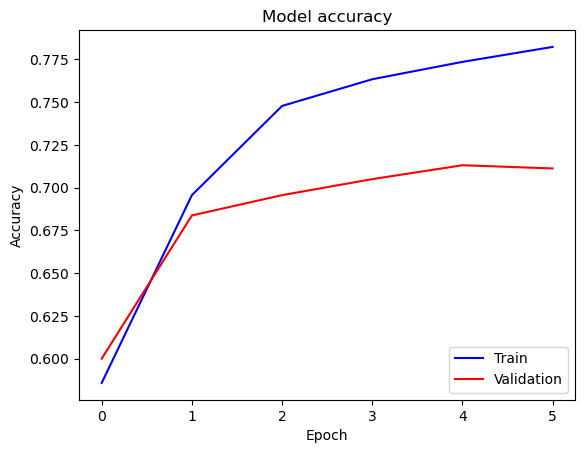

In [18]:
# plot the training and validation accuracy as a function of epochs
plt.plot(history.history['accuracy'], color='blue')
plt.plot(history.history['val_accuracy'], color='red')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [19]:
# evaluate the model on the training data
train_loss, train_accuracy = NN_model.evaluate(X_train, y_train)
print('Train accuracy:', train_accuracy)

# evaluate the model on the test data
test_loss, test_accuracy = NN_model.evaluate(X_test, y_test)
print('Test accuracy:', test_accuracy)

250/250 [==============================] - 0s 1ms/step - loss: 0.4712 - accuracy: 0.7860
Train accuracy: 0.7860000133514404
63/63 [==============================] - 0s 1ms/step - loss: 0.6963 - accuracy: 0.6995
Test accuracy: 0.6995000243186951


<div class='exercise-r'>

**1.3**  **Fit and examine a "proxy" model**

Neural networks are often called 'black-box' models because it is difficult to interpret just what role each feature plays in the predictions they output. But suppose we choose a second type of model which is easier to interpret and train it to *predict the predictions* of the`NN_model`. That is, the response variable for the second, "proxy" model is the set of predictions generated by the `NN_model`, $\hat{y}$, **not** the true values, $y$. Interpreting this second, "proxy" model can then give us some insight into how the `NN_model` is making its predictions.




</div>

<div class='exercise-r'>

**1.3.1**  First, generate a set of `NN_model` class predictions for the training set. Call these `y_train_nn`. These $\hat{y}$ training predictions will be used instead of the true $y$ training values when we fit our proxy model in 1.3.2. The $X$ values used in our 1.3.2 proxy model should be the same ones used for `NN_model`.




</div>

In [20]:
# Predict binary labels on train set using neural network model
# Threshold probabilities at 0.5 to obtain binary labels
y_train_nn = (NN_model.predict(X_train) > 0.5).astype("int32")


250/250 [==============================] - 0s 801us/step


In [21]:
grader.check("q1.3.1")

q1.3.1 results: All test cases passed!

<div class='exercise-r'>

**1.3.2**  Next, fit a logistic regression model using your $\hat{y}$ values from 1.3.1 (name this model `logreg`). Use ridge-like regularization. Next, print the `logreg` test accuracy compared to the *true $y$ values* to confirm that it is similar to what we saw for our `NN_model` test accuracy in 1.2. You may need to adjust `C` in order to achieve a similar accuracy.




</div>

In [22]:
# your code here

# Create a logistic regression model with L2 penalty
logreg = LogisticRegression(penalty='l2', C=0.2, max_iter=1000)

# Fit the logistic regression model to the training data
logreg.fit(X_train, y_train_nn.ravel())

print("Logistic regression Test Accuracy: {:.2f}%".format(logreg.score(X_test, y_test)*100))
print("Previous Test Accuracy: {:.2f}%".format(test_accuracy*100))

Logistic regression Test Accuracy: 70.95%
Previous Test Accuracy: 69.95%


<div class='exercise-r'>

**1.3.3**  Now use sklearn's `permutation_importance` function (already included in this notebook's imports) to compute the feature importance using the `logreg` model. Plot the **relative** feature importance (normalizing your importances so that your largest importance equals 1 for comparison purposes) for the top-10 most important predictors identified by the `permutation_importance` function.

  - Please refer to sklearn's official documentation to learn how this function works.
  
  - When running `permutation_importance` for this problem, you can use the default number of `n_repeats` and your estimator's default `scorer`. To speed up the time it takes to run your permutations, you can try setting `n_jobs=-1` to take full advantage of all of your available processor cores.

<a id="q14"></a>



</div>

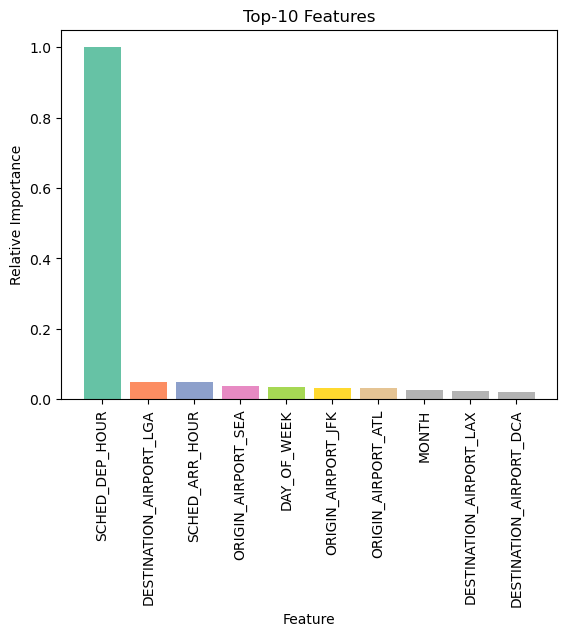

CPU times: user 3.5 s, sys: 596 ms, total: 4.09 s
Wall time: 59.9 s


In [23]:
%%time

# Compute permutation-based feature importances
result = permutation_importance(logreg, 
                                X_test, 
                                y_test, 
                                n_repeats=10, 
                                random_state=0, 
                                n_jobs=-1)

importances = result.importances_mean

# Find indices of top-10 features
top_n = 10
idx = np.argsort(importances)[::-1][:top_n]

# Normalize importances and create color map
norm_imp = importances / importances.max()
colors = plt.cm.Set2(np.arange(top_n))

# Create bar plot with different colors for top features
plt.bar(range(top_n), norm_imp[idx], color=colors)
plt.xticks(range(top_n), X_train.columns[idx], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Relative Importance')
plt.title('Top-10 Features')
plt.show()

<div class='exercise-r'>

**1.4**  **Visualize important features** 

Another way to interpret the  `NN_model` is by examining the response as a function of any of the predictors. Particularly, we will select from features often found most significant from the analysis above. Though the data has been scaled, **for all plots in 1.4, please visualize using the original scale for interpretability.**

**NOTE:** The predictors you are required to use in 1.4 may differ from some of the top-10 predictors you identified in 1.3 as a result of random variability in our algorithms.




</div>

<div class='exercise-r'>

**1.4.1**
    
Set all predictors to their means/modes except for `SCHED_DEP_HOUR` (when deciding between mean and mode, consider whether a given predictor is continous or categorical.
    
Next, predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` on the data from the **training set**. Interpret what you see in 2-4 sentences.

**NOTE:** Again, the values of `SCHED_DEP_HOUR` used her for predictions and plotting should be those actually *observed* in the training data.


</div>

The plot above indicates that the probability of delay increases in a nearly linear manner as the scheduled departure hour advances. This finding supports the previous plot, which emphasized the significance of this predictor over others. Moreover, the observation aligns with the intuition that departure hour is a key factor influencing delays.

In [24]:
# List of relevant predictors
relevant_predictors = ['SCHED_DEP_HOUR']

# List of continuous predictors
continuous_pred = ['DISTANCE', 'SCHEDULED_TIME', 'MONTH', 'SCHED_ARR_HOUR', 'FLIGHT_COUNT', 'DAY_OF_WEEK']

# List of categorical predictors
categorical_pred = list(set(X_train.columns) - set(continuous_pred) - set(relevant_predictors))

# Create a copy of the training dataset
X_temp = X_train.copy()

# Iterate through each column in the dataset
for col in X_temp.columns:
    
    # If the column is continuous, set the value to the mean
    if col in continuous_pred:
        X_temp[col].values[:] = X_temp[col].mean()
        
    # If the column is categorical, set the value to the mode
    if col in categorical_pred:
        X_temp[col].values[:] = X_temp[col].mode()

# Inverse transform the scaled dataset to the original unscaled data
X_temp_unscaled = pd.DataFrame(scaler.inverse_transform(X_temp), columns=X.columns)


250/250 [==============================] - 0s 945us/step


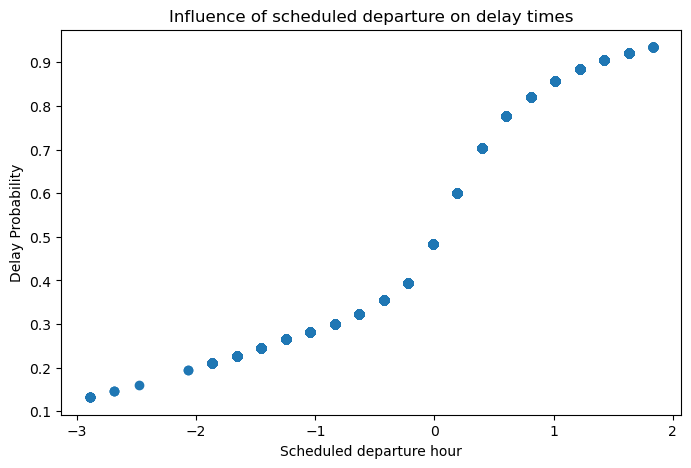

In [25]:
# prediction

delay_prob = NN_model.predict(X_temp)


plt.figure(figsize=(8, 5))
plt.scatter(X_temp['SCHED_DEP_HOUR'], delay_prob)
plt.title('Influence of scheduled departure on delay times')
plt.xlabel('Scheduled departure hour')
plt.ylabel('Delay Probability')
plt.show()

<div class='exercise-r'>

**1.4.2**  Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `FLIGHT_COUNT`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. values `SCHED_DEP_HOUR` and `FLIGHT_COUNT` observed in the training set.  
    
**NOTE:** See hint in 1.4.5 about plotting in this section




</div>

In [26]:
# Define relevant, continuous, and categorical predictors
relevant_predictors = ['SCHED_DEP_HOUR', 'FLIGHT_COUNT']
continuous_pred = ['DISTANCE', 'SCHEDULED_TIME', 'MONTH','SCHED_ARR_HOUR', 'DAY_OF_WEEK']
categorical_pred = list(set(X_train.columns) - set(continuous_pred) - set(relevant_predictors))

# Create a copy of the training data to modify
X_temp = X_train.copy()

# Fill continuous predictors with mean values and categorical predictors with mode values
for col in X_temp.columns:
    if col in continuous_pred:
        X_temp[col].values[:] = X_temp[col].mean()
    if col in categorical_pred:
        X_temp[col].values[:] = X_temp[col].mode()
        
# Unscale modified training data and store as DataFrame
X_temp_unscaled = pd.DataFrame(scaler.inverse_transform(X_temp), columns=X.columns)

250/250 [==============================] - 0s 968us/step


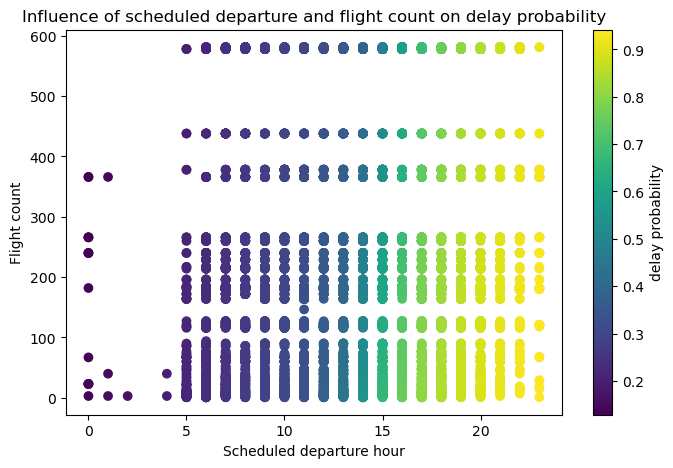

In [27]:
# your code here

# prediction

delay_prob = NN_model.predict(X_temp)

fig, ax = plt.subplots(figsize=(8, 5))
scat = ax.scatter(X_temp_unscaled['SCHED_DEP_HOUR'],X_temp_unscaled['FLIGHT_COUNT'], c=delay_prob)
ax.set_title('Influence of scheduled departure and flight count on delay probability')
ax.set_xlabel('Scheduled departure hour')
ax.set_ylabel('Flight count')
fig.colorbar(scat, pad=0.05, label='delay probability')
plt.show()



<div class='exercise-r'>

**1.4.3**  Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. values of `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR` observed in the training set.




</div>

In [28]:
relevant_predictors = ['SCHED_DEP_HOUR', 'SCHED_ARR_HOUR']

continuous_pred = ['DISTANCE', 'SCHEDULED_TIME', 'MONTH','FLIGHT_COUNT', 'DAY_OF_WEEK']

# Extracting categorical predictors by subtracting continuous predictors and relevant predictors from all predictors
categorical_pred = list(set(X_train.columns) - set(continuous_pred) - set(relevant_predictors))

X_temp = X_train.copy()

# Mean imputation for continuous predictors and mode imputation for categorical predictors
for col in X_temp.columns:
    if col in continuous_pred:
        X_temp[col].values[:] = X_temp[col].mean()
    if col in categorical_pred:
        X_temp[col].values[:] = X_temp[col].mode()
        
# Convert the imputed and scaled data back to unscaled data
X_temp_unscaled = pd.DataFrame(scaler.inverse_transform(X_temp), columns=X.columns)

250/250 [==============================] - 0s 798us/step


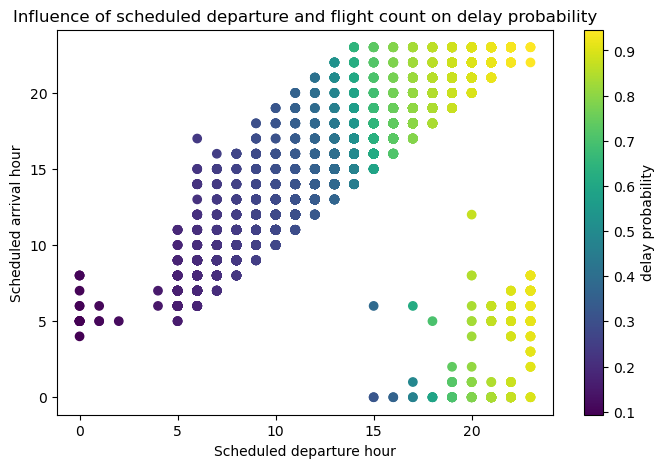

In [29]:
# prediction

delay_prob = NN_model.predict(X_temp)

fig, ax = plt.subplots(figsize=(8, 5))
scat = ax.scatter(X_temp_unscaled['SCHED_DEP_HOUR'],X_temp_unscaled['SCHED_ARR_HOUR'], c=delay_prob)
ax.set_title('Influence of scheduled departure and flight count on delay probability')
ax.set_xlabel('Scheduled departure hour')
ax.set_ylabel('Scheduled arrival hour')
fig.colorbar(scat, pad=0.05, label='delay probability')
plt.show()

<div class='exercise-r'>

**1.4.4**  Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `DISTANCE`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. values of `SCHED_DEP_HOUR` and `DISTANCE` observed in the training set. 




</div>

In [30]:
# your code here

relevant_predictors = ['SCHED_DEP_HOUR', 'DISTANCE']

continuous_pred = ['SCHEDULED_TIME', 
                   'MONTH','SCHED_ARR_HOUR', 
                   'DAY_OF_WEEK', 'FLIGHT_COUNT']

categorical_pred = list(set(X_train.columns) - set(continuous_pred) - set(relevant_predictors))

X_temp = X_train.copy()

for col in X_temp.columns:
    if col in continuous_pred:
        X_temp[col].values[:] = X_temp[col].mean()
    if col in categorical_pred:
        X_temp[col].values[:] = X_temp[col].mode()
        
# Unscaled training data
X_temp_unscaled = pd.DataFrame(scaler.inverse_transform(X_temp), columns=X.columns)

250/250 [==============================] - 0s 755us/step


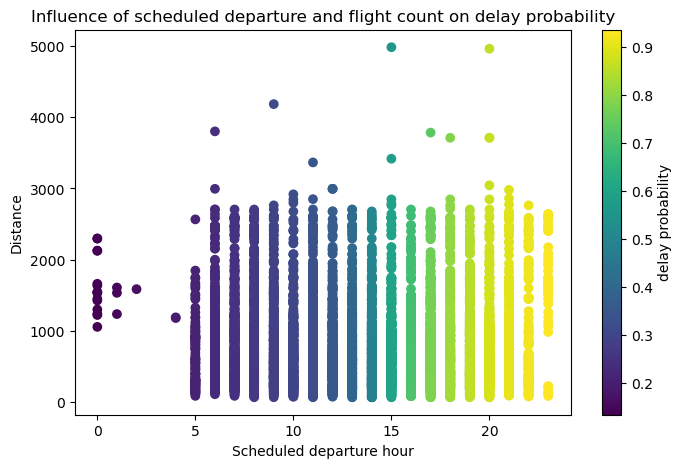

In [31]:
# prediction

delay_prob = NN_model.predict(X_temp)

fig, ax = plt.subplots(figsize=(8, 5))
scat = ax.scatter(X_temp_unscaled['SCHED_DEP_HOUR'],X_temp_unscaled['DISTANCE'], c=delay_prob)
ax.set_title('Influence of scheduled departure and flight count on delay probability')
ax.set_xlabel('Scheduled departure hour')
ax.set_ylabel('Distance')
fig.colorbar(scat, pad=0.05, label='delay probability')
plt.show()

<div class='exercise-r'>

**1.4.5**  In 5-10 sentences, interpret what you have seen in 1.4.2, 1.4.3, and 1.4.4.

**HINT:** For 1.4.2, 1.4.3, and 1.4.4, when you include `SCHED_DEP_HOUR` on one axis and your second predictor on the other axis, you can color your data points based on their corresponding predicted probabilities by using  the `c` and `cmap` arguments in `plt.scatter`. You can also add a labeled colorbar to your plot to make clear what those colors mean. You can refer to the [matplotlib documentation](https://matplotlib.org/stable/tutorials/index) for examples. This [stackoverflow post](https://stackoverflow.com/questions/17682216/scatter-plot-and-color-mapping-in-python) covering color mapping with scatter plots may also be useful. 

<a id="q15"></a>



</div>

In 1.4.2, the probability of delay is observed to increase as both the flight count and scheduled departure hour increase. However, the scheduled departure hour remains a more significant factor, as the range of variability in probability for a fixed hour is not substantial. Additionally, at large scheduled departure hours, the flight count appears to have no effect, and all probabilities of delay remain high. 

In 1.4.3, the impact of scheduled arrival hour on probability is found to be higher than that of flight count. The probability increases as the scheduled arrival hour surpasses the scheduled departure hour, which is intuitive. However, this increase in probability is not consistent across all scheduled departure hours, with later hours exhibiting a higher range of delay probabilities for scheduled arrival hours. 

Finally, 1.4.4 reveals that distance has minimal influence on the delay probability. Although a few data points indicate a low delay probability for short distances and high probability for long distances, there are no clear trends.

<div class='exercise-r'>

**1.5**  **Bootstrap prediction intervals**

In this part, we will attempt to do model inference. Neural Networks have too many parameters, and therefore inference on all the parameters is intractable and meaningless. 

Using the same network architecture as `NN_model` (layers, nodes, activations, etc.) and your scaled data from that model, create multiple training sets using bootstrapping and fit a separate neural network model to each bootstrapped set of data (the number of bootstraped *datasets*, $n$, should be at least 50). For each of the $n$ models, make predictions on the test data. Randomly select 8 test observations and on 8 subplots, plot the distribution of the $n$ predicted probabilities with the 95% prediction intervals clearly marked and reported in each subplot and the **actual** class of each observation included in each subplot's title for easy reference.
    
Interpret what you see in 3-5 sentences.

**NOTE:** The code for this problem can take an extremely long time to execute. Please feel free to use the `progressbar` function provided below to visually track the progress of your bootstraps.

<a id="q16"></a>



</div>

In [32]:
def progressbar(n_step, n_total):
    """Prints self-updating progress bar to stdout to track for-loop progress
    
    There are entire 3rd-party libraries dedicated to custom progress-bars.
    A simple function like this is often more than enough to get the job done.
    
    :param n_total: total number of expected for-loop iterations
    :type n_total: int
    :param n_step: current iteration number, starting at 0
    :type n_step: int

    .. example::
    
        for i in range(n_iterations):
            progressbar(i, n_iterations)
            
    .. source:
    
        This function is a simplified version of code found here:
        https://stackoverflow.com/questions/3160699/python-progress-bar/15860757#15860757
    """
    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

Upon examining the prediction probabilities of the neural network model for a given datapoint, we observed that the distribution did not follow the typical normal distribution pattern as commonly observed in regression models. Instead, we noticed a concentration of probabilities around the upper and lower bounds of the 95% confidence interval. This phenomenon might be attributed to the inherent complexity of neural networks, which tend to overfit easily without the application of regularization techniques such as dropout. Overfitting occurs when the model is too closely fit to the training data, leading to poor generalization to new data. Therefore, it is crucial to implement suitable regularization methods to prevent overfitting and improve the generalization ability of the neural network model.

In [33]:
%%time
# Bootstrap and train your networks and get predictions on X test
# your code here

# NN model for bootstrap
n_bootstrap = 75

# list to store bootstrap predictions
bootstrap_preds = []

# loop over bootstrap samples
for k in range(n_bootstrap):
    progressbar(k, n_bootstrap)
    
    # build NN
    NN_boot = tf.keras.Sequential()
    for i in range(n_hidden):
        NN_boot.add(tf.keras.layers.Dense(hidden_size, activation='sigmoid'))
    NN_boot.add(tf.keras.layers.Dense(1, activation='relu'))
    
    # sample from training data with replacement
    sample_idx = np.random.choice(X_train.index, size=len(X_train.index), replace=True)
    X_sample = X_train.iloc[sample_idx]
    y_sample = y_train.iloc[sample_idx]

    # compile and fit the model
    NN_boot.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    NN_boot.fit(X_sample, y_sample, batch_size=32, epochs=10, validation_split=0.2, verbose=0)
    
    # make predictions on the test set and store the predictions in the bootstrap_preds list
    y_sample_pred = NN_boot.predict(X_test)
    bootstrap_preds.append(y_sample_pred)

63/63 [==============================] - 0s 682us/step74/7
 [==================================================] 75/75 Done...

63/63 [==============================] - 0s 753us/step
CPU times: user 4min 40s, sys: 28.7 s, total: 5min 8s
Wall time: 3min 57s


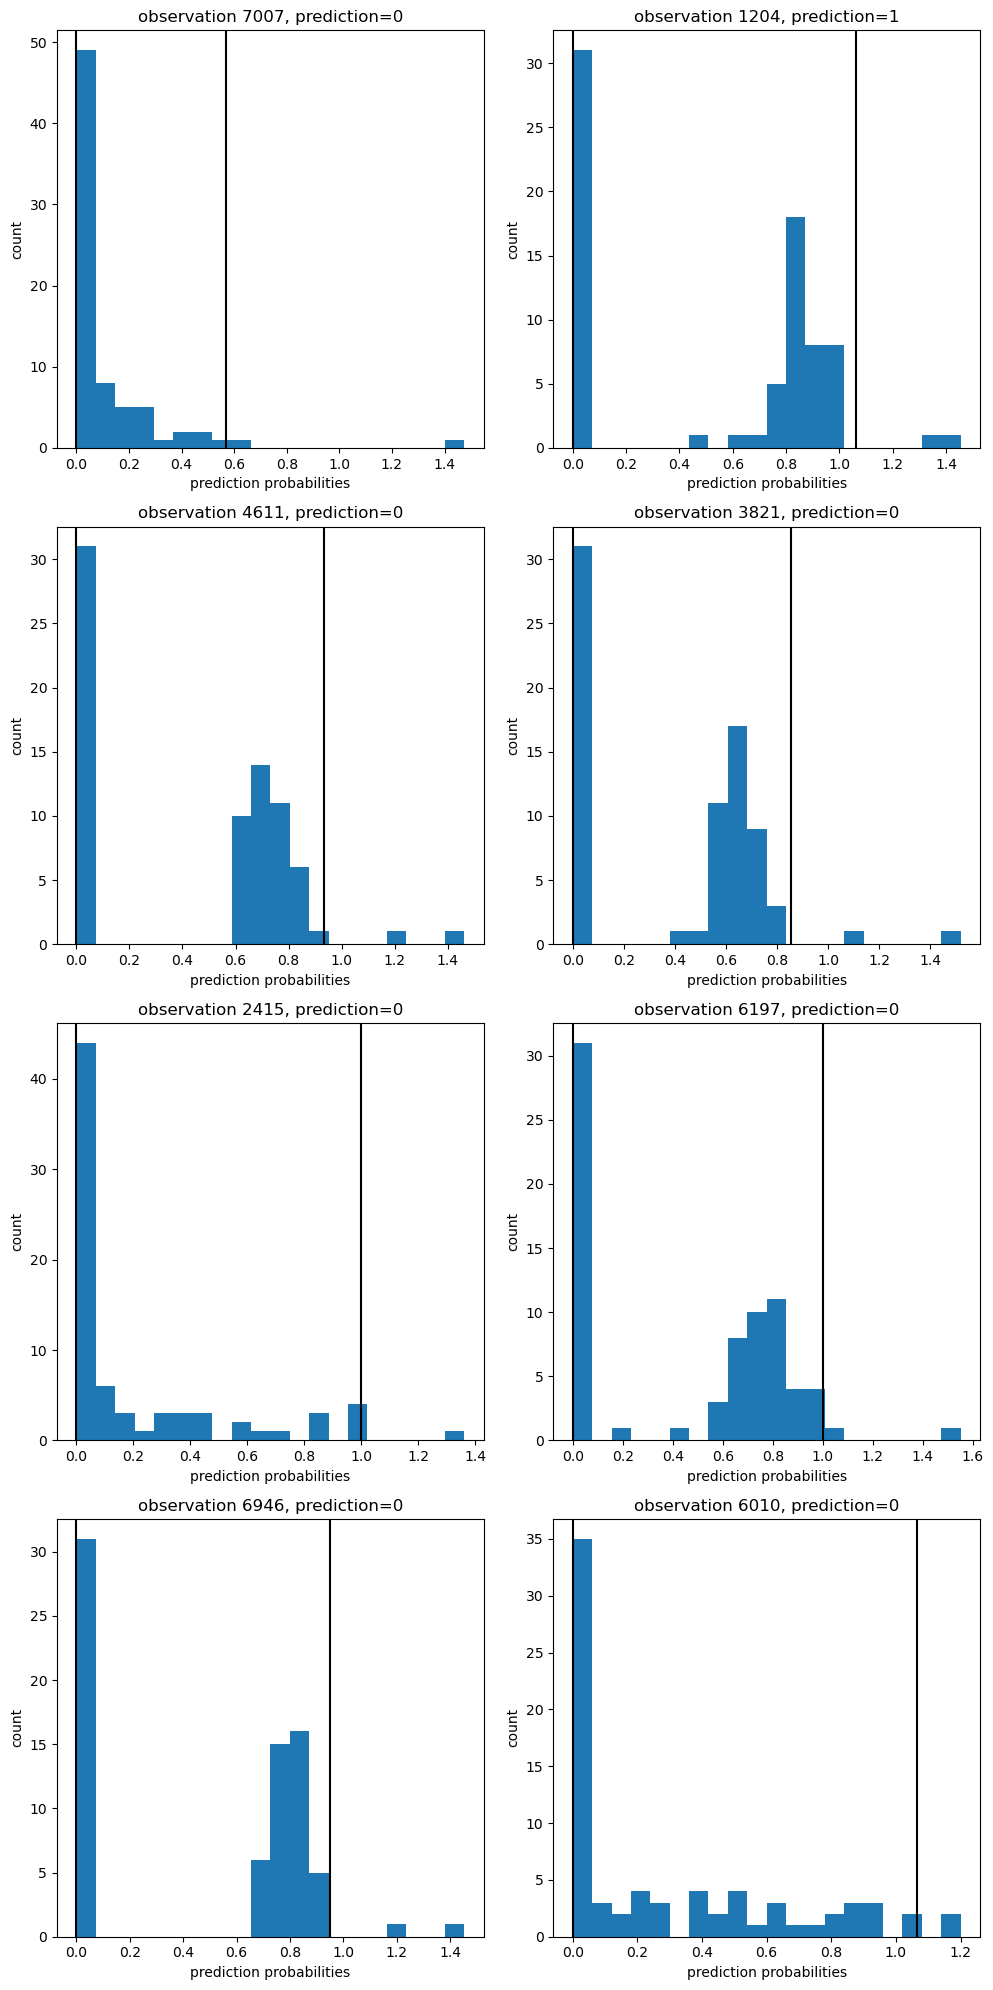

In [34]:
# Reshape bootstrap predictions
bootstrap_preds = np.array(bootstrap_preds).reshape(n_bootstrap, X_test.shape[0])

# Generate random observations for plotting
obs = [np.random.randint(X_train.shape[0]) for i in range(8)]

# Create subplots
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(10, 20))
axs = axs.flatten()

# Iterate over observations
for i, o in enumerate(obs):
    # Get bootstrap predictions for the observation
    obs_pred = bootstrap_preds[:, i]
    
    # Calculate prediction based on bootstrap mean
    res = 1*(np.mean(obs_pred)>0.5)
    
    # Plot histogram of prediction probabilities
    axs[i].hist(obs_pred, bins=20)
    
    # Add vertical lines for confidence intervals
    axs[i].axvline(np.quantile(obs_pred, 0.025), color='black')
    axs[i].axvline(np.quantile(obs_pred, 0.975), color='black')
    
    # Set axis labels and title
    axs[i].set_xlabel("prediction probabilities")
    axs[i].set_ylabel("count")
    axs[i].set_title("observation {}, prediction={}".format(o, res))

# Adjust layout and display plot
plt.tight_layout()
plt.show()


<div class='exercise-r'>

**1.6**  **Build an "abstain" bagging model**

Using the probability distribution of the predictions obtained from the bootstrapped samples above, we can evaluate how confident we should be in our bagged (i.e. bootstrap-aggregated) predictions for each test observation.

To accomplish this, you will first calculate a metric we'll call the **Posterior Prediction Dissent (PPD)** related to the proportion of predictions a given test observation receives for the minority opinion. Some examples: if 10% of the bootstrapped models predict $\hat{y} = 0$ with the remaining 90% predicting $\hat{y}=1$, then the $PPD=0.1$. When a bagged prediction's $PPD=0$, all predictions are compatible (i.e. all bootstrapped probabilities for that test observation are on the same side of $\hat{p}=0.5$). Likewise, when the $PPD=0.5$, half of the bootstrapped predictions for that test observation are $\hat{y}=0$, and the other half are $\hat{y}=1$. After calculating your $PPD$ values for all test observations, you should have $n=2000$ $PPD$ values (i.e. one for each test observation).

Next, to get more accurate predictions, we can create an **abstain** model that will abstain from making a prediction for a particular observation if some defined threshold for lack-of-confidence (i.e. maximum permissible $PPD$ value) is crossed. (If you'd like to learn more about abstain models, you can read more [here](https://openreview.net/forum?id=rJxF73R9tX).)

Let's explore how your resulting test accuracies might change by using your bootstrapped prediction results from question 1.5 for an **abstain bagging model** (i.e. a bootstrap aggregated model where some test observations are simply not predicted based on a given $PPD$ threshold). You can make your abstain model *stricter* by using smaller $PPD$ threshold values.

- Print the test accuracy for your **bagging model** predictions from question 1.5 using predictions for all 2,000 of our test observations. 

- Plot the test accuracies for an **abstain bagging model** using your predictions from question 1.5 as a function of increasing $PPD$.

- Also, plot the proportion of test observations not abstained (i.e. the proportion of those predicted) for your **abstain bagging model** as a function of increasing $PPD$.

- Interpret what you see in 3-5 sentences.

**NOTE**: You should observe that as $PPD$ decreases (more confident predictions), you must also compromise on the number of points that your abstain model is permitted to predict on. 

**HINT:** 
- What is the range of values PPD can take on? Is it the same as the range of our predictions themselves?
- When calculating accuracies, you should only consider those observations that received predictions (i.e., not the abstained observations)
</div>

Upon analysis, we observe that the test accuracy for the bagging model has improved compared to previous results. However, the new model that incorporates the technique of abstaining does not appear to be very effective in this context. We notice that as the threshold for abstaining increases, the proportion of test observations that are not abstained also decreases, but this is accompanied by a decline in accuracy. This could potentially be attributed to the fact that our previous findings revealed that the various bootstrapped predictions for a given observation were not distributed normally.

In [35]:
y_test_pred = (NN_model.predict(X_test) > 0.5).astype("int32")
y_test_pred = np.argmax(y_test_pred, axis=1)

63/63 [==============================] - 0s 743us/step


Test bagging accuracy: 0.878


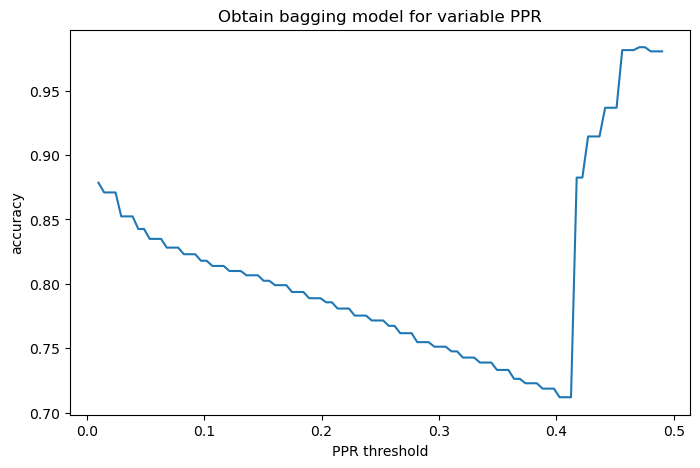

In [36]:
# your code here

# Calculate the number of times each observation was predicted as the negative class
v0 = np.sum(bootstrap_preds<0.5, axis=0)
# Calculate the number of times each observation was predicted as the positive class
v1 = n_bootstrap - v0
# Stack v0 and v1 into a 2D array
v = np.stack((v0, v1))
# Calculate the per point relative frequency of choosing the minority class for each observation
PPR = np.min(v, axis=0)/n_bootstrap

# Obtain bagging predictions by taking the mean of all bootstrap predictions and thresholding at 0.5
bagg_pred = 1*(np.mean(bootstrap_preds, axis=0)>0.5)
# Calculate accuracy of bagging predictions
bagg_acc = accuracy_score(y_test_pred, bagg_pred)

# Flatten y_test_pred
y_test_pred = y_test_pred.flatten()
# Obtain predictions by taking the mean of all bootstrap predictions and thresholding at 0.5
pred = 1*(np.mean(bootstrap_preds, axis=0)>0.5)

# Print the accuracy of bagging predictions
print("Test bagging accuracy: {:.3f}".format(bagg_acc))

# Generate a sequence of thresholds to test
thresh = np.linspace(0.01, .49, 100)
kept = []
abs_bagg_acc = []

# For each threshold, keep all observations whose PPR is above the threshold, 
# and calculate the accuracy of the resulting predictions
for t in thresh:
    to_keep = PPR>t
    kept.append(np.sum(to_keep))
    acc = accuracy_score(y_test_pred[to_keep], pred[to_keep])
    abs_bagg_acc.append(acc)

# Plot the accuracy of predictions obtained by keeping observations with PPR above each threshold
plt.figure(figsize=(8, 5))
plt.plot(thresh, abs_bagg_acc)
plt.xlabel("PPR threshold")
plt.ylabel("accuracy")
plt.title("Obtain bagging model for variable PPR")
plt.show()

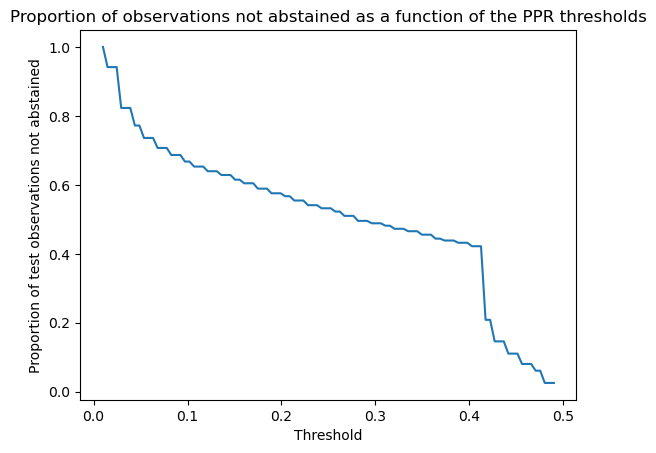

In [37]:
# your code here
plt.plot(thresh,np.array(kept)/len(y_test))
plt.xlabel("Threshold")
plt.ylabel("Proportion of test observations not abstained")
plt.title("Proportion of observations not abstained as a function of the PPR thresholds")
plt.show()

In [38]:
# your code here
...

<a id="part2"></a>

<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 2 [35 pts]: Kannada MNIST Kaggle competition

[Return to contents](#contents)


<a id="part2intro"></a>

## Problem Statement

[Return to contents](#contents)


Artificial neural networks (ANNs) can be prone to overfitting, where they learn specific patterns present in the training data, but the patterns do not generalize to new data.

There are several methods used to improve ANN generalization. 

One approach is to use an architecture just barely wide or deep enough to fit the data. The idea here is that smaller networks are less expressive and thus less able to overfit the data.

However, it is difficult to know a priori the correct size of the ANN, and it is computationally costly to hunt for the correct size. Given this, other methodologies are used to prevent overfitting and improve ANNs' generalizability. These methodologies, like other techniques that combat overfitting, fall under the umbrella term of "regularization".

In this problem, you are asked to regularize a network of a given architecture.

<a id="part2about"></a>

## The Kannada MNIST Dataset

[Return to contents](#contents)


![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F1e01bcc28b5ccb7ad38a4ffefb13cde0%2Fwondu.png?generation=1603204077179447&alt=media)


For this problem, we will be working with a modified version of the [Kannada MNIST dataset](https://arxiv.org/pdf/1908.01242.pdf), which is a large database of handwritten digits in the indigenous language *Kannada*.

This dataset consists of 60,000 28x28 grayscale images of the ten digits, along with a test set of 10,000 images. 

For this homework, we will simplify the problem by only using the digits labeled `0` and `1` owing to the similarity of the two symbols, and we will use a total of 1,200 samples for training (this includes the data you will use for validation).

To understand the dataset better, we recommend this [article](https://towardsdatascience.com/a-new-handwritten-digits-dataset-in-ml-town-kannada-mnist-69df0f2d1456) by Vinay Prabhu, the curator of the dataset.

<a id="part2data"></a>

## Downloading the Data Files

[Return to contents](#contents)


**Please download the specific `kmnist_train.csv` and `kmnist_test.csv` data files available on [the "Data" tab of the CS109B HW3 Kaggle Competition website](https://www.kaggle.com/t/91152696a0cf4872adedafbaff0f7f15). (DO NOT USE DATA FROM ANY OTHER SOURCE!)**

Here's a brief description of the data files:

- `kmnist_train.csv` is our training dataset and the last column contains our response class. The 784 other columns correspond to the pixel values of the 28x28 dimension image. Class 0 means a sample is the handwritten digit `0` and class 1 means a sample is the handwritten digit `1` in the Kannada written language. `kmnist_train.csv` has 1,200 samples.


- `kmnist_test.csv` has a structure similar to `kmnist_train.csv`, however the class label column is NOT included in with the test set. `kmnist_test.csv` has 2,000 samples. 


Kaggle leaderboard scores are accuracy scores calculated by Kaggle when you upload your predictions on this test set.

- `sample_submission.csv` is the format that kaggle will accept. The uploaded `.csv` must contain 2 columns. The first column must be named `id` and needs to contain the test observation index numbers for each prediction, the second must be named `category` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location. 

<a id="part2kaggle"></a>

## CS109B Kaggle Competition

[Return to contents](#contents)

**ACCESS AND JOIN THE COMPETITION**:

**You need to create an account on Kaggle and [join the competition via this link](https://www.kaggle.com/t/91152696a0cf4872adedafbaff0f7f15). This is a limited participation competition. Please DO NOT share this link.**

**For more information on the rules** governing this CS109B Kaggle competition, please see below and also review [the modelling restrictions DOS and DON'TS outlined in question 2.3.1](#q2.3.1).

**IMPORTANT NOTES ABOUT SCORING**:

- The **public leaderboard** on Kaggle displays your performance on only 30% of the test set.


- After the competition is complete, the **private leaderboard** will show your performance on the remaining 70% of the test set.

- Question 2.3.5 is worth 5 points (the entire notebook is scored out of 100). Points for this questions will be awarded based on the **private leaderboard** as follows.

|Private Leaderboard Score   | Points|
|----------------------------|-------|
|$0.945 \leq \text{score}$ |5|
|$0.944 \leq \text{score} \lt 0.945$|4|
|$0.93 \leq \text{score} \lt 0.94$|3|
|$0.92 \leq \text{score} \lt 0.93$|2|
|$0.889 \leq \text{score} \lt 0.92$|1|

**🏆 Grand Prize(s):** The **Top-4** students on the private leaderboard will win an invitation to dinner with Pavlos and some of the CS109B teaching staff. This refers to the top 4 individuals on the board. The invitation will be extended to 5 students if the restriction to 4 would otherwise divide a group (e.g., 3 single submissions at the top followed by a group of 2).

**ADDITIONAL COMPETITION RULES:**

- Multiple Kaggle submissions are permitted (with a maximum of 20 submissions per-participant per-day), **just note that you will need to choose, on Kaggle, the ONE single submission to use for final scoring prior to the final HW3 submission deadline**, and **your submitted notebook MUST contain the matching code and model that generated your ONE chosen submission.**


- **To repeat this point, the version of your final HW3 notebook submitted on Canvas MUST contain the same code and exact same model used to generate your ONE chosen Kaggle submission.** (TFs may rerun your notebook code to ensure comparable final leaderboard results.)


- **Please do not manually label your submissions.** In other words, the labels should only be the outcome of your model.


- **No external data are allowed, you MUST USE ONLY the KMNIST training and test data downloaded via the "Data" tab of [the CS109B competition page linked above](#part2data).**


- **Do not** create multiple accounts on Kaggle.


<div class='exercise-r'>

**2.1**  **Get and visualize the data**

- Download the train and test data from [the competition page](#part2data).
- We will utilize `kmnist_test.csv` in question 2.3.4 only. 
- Load the data and use the matplotlib function `imshow` to display a handwritten 0 and a handwritten 1 from the training set.
- You are responsible for any preprocessing you deem necessary to help in your prediction task.

<a id="q22"></a>



</div>

In [39]:
# your code here
df_train = pd.read_csv("/Users/jamesliounis/Documents/Harvard SM DS/AC209b/Data/kmnist_train.csv")
df_test = pd.read_csv("/Users/jamesliounis/Documents/Harvard SM DS/AC209b/Data/kmnist_test.csv")

In [40]:
# your code here
x_train, y_train = df_train.drop(["output"],axis=1), df_train["output"]
x_test = df_test

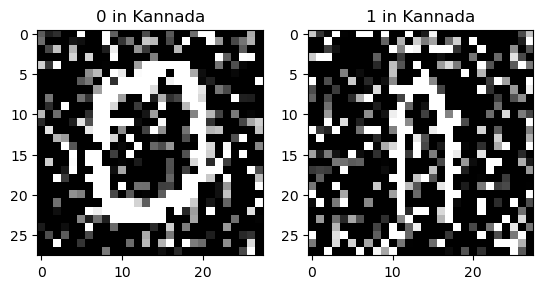

In [41]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.reshape(x_train.loc[2].values,(28,28)),cmap="gray")
ax[0].set_title("0 in Kannada")
ax[1].imshow(np.reshape(x_train.loc[0].values,(28,28)),cmap="gray")
ax[1].set_title("1 in Kannada")
plt.show()

<div class='exercise-r'>

**2.2**  **Overfit an ANN** 

Build and fit a fully-connected network (FCN) with the architecture given below using `tensorflow.keras` and assign it to a variable called `model_overfit`:

- Number of hidden layers: 3
- Nodes per hidden layer: 100, 100, 100
- Activation function: ReLU 
- Loss function: binary_crossentropy
- Output unit: Sigmoid 
- Optimizer: adam (use the defaults; no other tuning)
- Epochs: 1,000
- Batch size: 128
- Validation size: 0.3

![diagram](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F6a491ff8d4ff590dc8ded9a25461cd4b%2FScreenshot%202020-10-20%20at%209.42.36%20PM.png?generation=1603210420701577&alt=media) 
    
This ANN, when trained on the dataset, will overfit to the training set. Plot the training accuracy and validation accuracy (the x-axis should represent the number of epochs, and the y-axis should represent the accuracy). Explain how you can tell the model is overfitting. 




</div>

**Answer to Q2.2**

One can observe that the model is overfitting when the training accuracy reaches 100% and stops changing after just a few epochs. Additionally, the validation accuracy remains relatively low and remains nearly constant after approximately 300 epochs.

In [42]:
# your code here
inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(100,activation="relu")(inputs)
x = tf.keras.layers.Dense(100,activation="relu")(x)
x = tf.keras.layers.Dense(100,activation="relu")(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model_overfit = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model_overfit")
model_overfit.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])

In [43]:
%%time 
# your code here
epochs = 1000
history=model_overfit.fit(x_train, y_train, epochs=epochs,
                          batch_size=128,
                          validation_split=0.3)

Epoch 1/1000
7/7 [==============================] - 1s 26ms/step - loss: 11.6712 - accuracy: 0.5083 - val_loss: 3.1173 - val_accuracy: 0.5194
Epoch 2/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.7127 - accuracy: 0.5321 - val_loss: 1.1544 - val_accuracy: 0.6333
Epoch 3/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.5686 - accuracy: 0.5679 - val_loss: 1.6860 - val_accuracy: 0.5944
Epoch 4/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.1431 - accuracy: 0.6357 - val_loss: 0.7778 - val_accuracy: 0.6944
Epoch 5/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.7808 - accuracy: 0.6929 - val_loss: 0.8688 - val_accuracy: 0.6833
Epoch 6/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.6293 - accuracy: 0.7202 - val_loss: 0.6167 - val_accuracy: 0.7472
Epoch 7/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.4685 - accuracy: 0.7857 - val_loss: 0.5491 - val_accuracy: 0.7806
Epoch 8/1000
7/7 [

7/7 [==============================] - 0s 6ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.4275 - val_accuracy: 0.8833
Epoch 60/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.4284 - val_accuracy: 0.8861
Epoch 61/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.4291 - val_accuracy: 0.8806
Epoch 62/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.4297 - val_accuracy: 0.8833
Epoch 63/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.4322 - val_accuracy: 0.8806
Epoch 64/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.4312 - val_accuracy: 0.8806
Epoch 65/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.4324 - val_accuracy: 0.8806
Epoch 66/1000
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 6.4018e-04 - accuracy: 1.0000 - val_loss: 0.4692 - val_accuracy: 0.8833
Epoch 117/1000
7/7 [==============================] - 0s 9ms/step - loss: 6.2729e-04 - accuracy: 1.0000 - val_loss: 0.4708 - val_accuracy: 0.8861
Epoch 118/1000
7/7 [==============================] - 0s 8ms/step - loss: 6.1326e-04 - accuracy: 1.0000 - val_loss: 0.4721 - val_accuracy: 0.8861
Epoch 119/1000
7/7 [==============================] - 0s 7ms/step - loss: 6.0057e-04 - accuracy: 1.0000 - val_loss: 0.4727 - val_accuracy: 0.8861
Epoch 120/1000
7/7 [==============================] - 0s 7ms/step - loss: 5.8701e-04 - accuracy: 1.0000 - val_loss: 0.4728 - val_accuracy: 0.8833
Epoch 121/1000
7/7 [==============================] - 0s 6ms/step - loss: 5.7546e-04 - accuracy: 1.0000 - val_loss: 0.4733 - val_accuracy: 0.8806
Epoch 122/1000
7/7 [==============================] - 0s 6ms/step - loss: 5.6488e-04 - accuracy: 1.0000 - val_loss: 0.4747 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 2.3947e-04 - accuracy: 1.0000 - val_loss: 0.5068 - val_accuracy: 0.8861
Epoch 173/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.3635e-04 - accuracy: 1.0000 - val_loss: 0.5082 - val_accuracy: 0.8861
Epoch 174/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.3288e-04 - accuracy: 1.0000 - val_loss: 0.5082 - val_accuracy: 0.8861
Epoch 175/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.2976e-04 - accuracy: 1.0000 - val_loss: 0.5087 - val_accuracy: 0.8861
Epoch 176/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.2643e-04 - accuracy: 1.0000 - val_loss: 0.5092 - val_accuracy: 0.8861
Epoch 177/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.2316e-04 - accuracy: 1.0000 - val_loss: 0.5098 - val_accuracy: 0.8861
Epoch 178/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.2021e-04 - accuracy: 1.0000 - val_loss: 0.5101 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 1.1745e-04 - accuracy: 1.0000 - val_loss: 0.5351 - val_accuracy: 0.8861
Epoch 229/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.1611e-04 - accuracy: 1.0000 - val_loss: 0.5355 - val_accuracy: 0.8861
Epoch 230/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.1479e-04 - accuracy: 1.0000 - val_loss: 0.5353 - val_accuracy: 0.8861
Epoch 231/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.1358e-04 - accuracy: 1.0000 - val_loss: 0.5359 - val_accuracy: 0.8861
Epoch 232/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.1211e-04 - accuracy: 1.0000 - val_loss: 0.5368 - val_accuracy: 0.8861
Epoch 233/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.1093e-04 - accuracy: 1.0000 - val_loss: 0.5373 - val_accuracy: 0.8861
Epoch 234/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.0972e-04 - accuracy: 1.0000 - val_loss: 0.5376 - val_accuracy: 

7/7 [==============================] - 0s 7ms/step - loss: 6.5615e-05 - accuracy: 1.0000 - val_loss: 0.5593 - val_accuracy: 0.8889
Epoch 285/1000
7/7 [==============================] - 0s 6ms/step - loss: 6.5094e-05 - accuracy: 1.0000 - val_loss: 0.5596 - val_accuracy: 0.8889
Epoch 286/1000
7/7 [==============================] - 0s 6ms/step - loss: 6.4406e-05 - accuracy: 1.0000 - val_loss: 0.5601 - val_accuracy: 0.8889
Epoch 287/1000
7/7 [==============================] - 0s 6ms/step - loss: 6.3840e-05 - accuracy: 1.0000 - val_loss: 0.5606 - val_accuracy: 0.8889
Epoch 288/1000
7/7 [==============================] - 0s 6ms/step - loss: 6.3264e-05 - accuracy: 1.0000 - val_loss: 0.5611 - val_accuracy: 0.8889
Epoch 289/1000
7/7 [==============================] - 0s 6ms/step - loss: 6.2740e-05 - accuracy: 1.0000 - val_loss: 0.5613 - val_accuracy: 0.8889
Epoch 290/1000
7/7 [==============================] - 0s 5ms/step - loss: 6.2072e-05 - accuracy: 1.0000 - val_loss: 0.5615 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 4.0519e-05 - accuracy: 1.0000 - val_loss: 0.5806 - val_accuracy: 0.8917
Epoch 341/1000
7/7 [==============================] - 0s 6ms/step - loss: 4.0207e-05 - accuracy: 1.0000 - val_loss: 0.5808 - val_accuracy: 0.8944
Epoch 342/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.9926e-05 - accuracy: 1.0000 - val_loss: 0.5814 - val_accuracy: 0.8917
Epoch 343/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.9585e-05 - accuracy: 1.0000 - val_loss: 0.5816 - val_accuracy: 0.8917
Epoch 344/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.9278e-05 - accuracy: 1.0000 - val_loss: 0.5820 - val_accuracy: 0.8944
Epoch 345/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.8978e-05 - accuracy: 1.0000 - val_loss: 0.5826 - val_accuracy: 0.8917
Epoch 346/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.8726e-05 - accuracy: 1.0000 - val_loss: 0.5829 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 2.6891e-05 - accuracy: 1.0000 - val_loss: 0.5986 - val_accuracy: 0.8944
Epoch 397/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.6799e-05 - accuracy: 1.0000 - val_loss: 0.5987 - val_accuracy: 0.8944
Epoch 398/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.6576e-05 - accuracy: 1.0000 - val_loss: 0.5992 - val_accuracy: 0.8944
Epoch 399/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.6379e-05 - accuracy: 1.0000 - val_loss: 0.5995 - val_accuracy: 0.8944
Epoch 400/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.6166e-05 - accuracy: 1.0000 - val_loss: 0.5995 - val_accuracy: 0.8944
Epoch 401/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.6039e-05 - accuracy: 1.0000 - val_loss: 0.5994 - val_accuracy: 0.8944
Epoch 402/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.5826e-05 - accuracy: 1.0000 - val_loss: 0.6001 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 1.8582e-05 - accuracy: 1.0000 - val_loss: 0.6138 - val_accuracy: 0.8944
Epoch 453/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.8458e-05 - accuracy: 1.0000 - val_loss: 0.6138 - val_accuracy: 0.8944
Epoch 454/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.8324e-05 - accuracy: 1.0000 - val_loss: 0.6142 - val_accuracy: 0.8944
Epoch 455/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.8213e-05 - accuracy: 1.0000 - val_loss: 0.6148 - val_accuracy: 0.8944
Epoch 456/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.8096e-05 - accuracy: 1.0000 - val_loss: 0.6151 - val_accuracy: 0.8944
Epoch 457/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.7983e-05 - accuracy: 1.0000 - val_loss: 0.6153 - val_accuracy: 0.8944
Epoch 458/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.7849e-05 - accuracy: 1.0000 - val_loss: 0.6155 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 1.2987e-05 - accuracy: 1.0000 - val_loss: 0.6294 - val_accuracy: 0.8972
Epoch 509/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.2921e-05 - accuracy: 1.0000 - val_loss: 0.6292 - val_accuracy: 0.8944
Epoch 510/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.2853e-05 - accuracy: 1.0000 - val_loss: 0.6296 - val_accuracy: 0.8944
Epoch 511/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.2781e-05 - accuracy: 1.0000 - val_loss: 0.6298 - val_accuracy: 0.8944
Epoch 512/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.2694e-05 - accuracy: 1.0000 - val_loss: 0.6304 - val_accuracy: 0.8972
Epoch 513/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.2613e-05 - accuracy: 1.0000 - val_loss: 0.6306 - val_accuracy: 0.8972
Epoch 514/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.2539e-05 - accuracy: 1.0000 - val_loss: 0.6309 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 9.3126e-06 - accuracy: 1.0000 - val_loss: 0.6440 - val_accuracy: 0.8944
Epoch 565/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.2541e-06 - accuracy: 1.0000 - val_loss: 0.6444 - val_accuracy: 0.8944
Epoch 566/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.2065e-06 - accuracy: 1.0000 - val_loss: 0.6450 - val_accuracy: 0.8944
Epoch 567/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.1492e-06 - accuracy: 1.0000 - val_loss: 0.6450 - val_accuracy: 0.8944
Epoch 568/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.1007e-06 - accuracy: 1.0000 - val_loss: 0.6455 - val_accuracy: 0.8944
Epoch 569/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.0392e-06 - accuracy: 1.0000 - val_loss: 0.6455 - val_accuracy: 0.8944
Epoch 570/1000
7/7 [==============================] - 0s 6ms/step - loss: 8.9944e-06 - accuracy: 1.0000 - val_loss: 0.6458 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 6.7927e-06 - accuracy: 1.0000 - val_loss: 0.6584 - val_accuracy: 0.8944
Epoch 621/1000
7/7 [==============================] - 0s 6ms/step - loss: 6.7556e-06 - accuracy: 1.0000 - val_loss: 0.6588 - val_accuracy: 0.8944
Epoch 622/1000
7/7 [==============================] - 0s 6ms/step - loss: 6.7185e-06 - accuracy: 1.0000 - val_loss: 0.6590 - val_accuracy: 0.8944
Epoch 623/1000
7/7 [==============================] - 0s 6ms/step - loss: 6.6865e-06 - accuracy: 1.0000 - val_loss: 0.6593 - val_accuracy: 0.8972
Epoch 624/1000
7/7 [==============================] - 0s 6ms/step - loss: 6.6475e-06 - accuracy: 1.0000 - val_loss: 0.6593 - val_accuracy: 0.8944
Epoch 625/1000
7/7 [==============================] - 0s 5ms/step - loss: 6.6119e-06 - accuracy: 1.0000 - val_loss: 0.6596 - val_accuracy: 0.8944
Epoch 626/1000
7/7 [==============================] - 0s 6ms/step - loss: 6.5740e-06 - accuracy: 1.0000 - val_loss: 0.6600 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 5.0559e-06 - accuracy: 1.0000 - val_loss: 0.6727 - val_accuracy: 0.8972
Epoch 677/1000
7/7 [==============================] - 0s 5ms/step - loss: 5.0341e-06 - accuracy: 1.0000 - val_loss: 0.6730 - val_accuracy: 0.8972
Epoch 678/1000
7/7 [==============================] - 0s 6ms/step - loss: 5.0012e-06 - accuracy: 1.0000 - val_loss: 0.6729 - val_accuracy: 0.8972
Epoch 679/1000
7/7 [==============================] - 0s 5ms/step - loss: 4.9774e-06 - accuracy: 1.0000 - val_loss: 0.6730 - val_accuracy: 0.8972
Epoch 680/1000
7/7 [==============================] - 0s 5ms/step - loss: 4.9533e-06 - accuracy: 1.0000 - val_loss: 0.6735 - val_accuracy: 0.8972
Epoch 681/1000
7/7 [==============================] - 0s 6ms/step - loss: 4.9244e-06 - accuracy: 1.0000 - val_loss: 0.6738 - val_accuracy: 0.8972
Epoch 682/1000
7/7 [==============================] - 0s 5ms/step - loss: 4.8978e-06 - accuracy: 1.0000 - val_loss: 0.6742 - val_accuracy: 

7/7 [==============================] - 0s 5ms/step - loss: 3.7903e-06 - accuracy: 1.0000 - val_loss: 0.6863 - val_accuracy: 0.8972
Epoch 733/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.7706e-06 - accuracy: 1.0000 - val_loss: 0.6863 - val_accuracy: 0.8972
Epoch 734/1000
7/7 [==============================] - 0s 5ms/step - loss: 3.7503e-06 - accuracy: 1.0000 - val_loss: 0.6866 - val_accuracy: 0.8972
Epoch 735/1000
7/7 [==============================] - 0s 5ms/step - loss: 3.7305e-06 - accuracy: 1.0000 - val_loss: 0.6870 - val_accuracy: 0.8972
Epoch 736/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.7126e-06 - accuracy: 1.0000 - val_loss: 0.6874 - val_accuracy: 0.8972
Epoch 737/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.6930e-06 - accuracy: 1.0000 - val_loss: 0.6877 - val_accuracy: 0.8972
Epoch 738/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.6744e-06 - accuracy: 1.0000 - val_loss: 0.6877 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 2.8654e-06 - accuracy: 1.0000 - val_loss: 0.6995 - val_accuracy: 0.8944
Epoch 789/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.8495e-06 - accuracy: 1.0000 - val_loss: 0.6998 - val_accuracy: 0.8944
Epoch 790/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.8350e-06 - accuracy: 1.0000 - val_loss: 0.6999 - val_accuracy: 0.8944
Epoch 791/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.8217e-06 - accuracy: 1.0000 - val_loss: 0.7004 - val_accuracy: 0.8944
Epoch 792/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.8074e-06 - accuracy: 1.0000 - val_loss: 0.7004 - val_accuracy: 0.8944
Epoch 793/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.7943e-06 - accuracy: 1.0000 - val_loss: 0.7006 - val_accuracy: 0.8944
Epoch 794/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.7798e-06 - accuracy: 1.0000 - val_loss: 0.7009 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 2.1739e-06 - accuracy: 1.0000 - val_loss: 0.7133 - val_accuracy: 0.8944
Epoch 845/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.1654e-06 - accuracy: 1.0000 - val_loss: 0.7139 - val_accuracy: 0.8944
Epoch 846/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.1533e-06 - accuracy: 1.0000 - val_loss: 0.7139 - val_accuracy: 0.8944
Epoch 847/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.1419e-06 - accuracy: 1.0000 - val_loss: 0.7138 - val_accuracy: 0.8944
Epoch 848/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.1320e-06 - accuracy: 1.0000 - val_loss: 0.7142 - val_accuracy: 0.8944
Epoch 849/1000
7/7 [==============================] - 0s 5ms/step - loss: 2.1229e-06 - accuracy: 1.0000 - val_loss: 0.7143 - val_accuracy: 0.8944
Epoch 850/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.1117e-06 - accuracy: 1.0000 - val_loss: 0.7146 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 1.6635e-06 - accuracy: 1.0000 - val_loss: 0.7264 - val_accuracy: 0.8944
Epoch 901/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.6553e-06 - accuracy: 1.0000 - val_loss: 0.7267 - val_accuracy: 0.8944
Epoch 902/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.6470e-06 - accuracy: 1.0000 - val_loss: 0.7268 - val_accuracy: 0.8944
Epoch 903/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.6401e-06 - accuracy: 1.0000 - val_loss: 0.7272 - val_accuracy: 0.8944
Epoch 904/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.6319e-06 - accuracy: 1.0000 - val_loss: 0.7274 - val_accuracy: 0.8944
Epoch 905/1000
7/7 [==============================] - 0s 5ms/step - loss: 1.6242e-06 - accuracy: 1.0000 - val_loss: 0.7277 - val_accuracy: 0.8944
Epoch 906/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.6170e-06 - accuracy: 1.0000 - val_loss: 0.7280 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 1.2823e-06 - accuracy: 1.0000 - val_loss: 0.7398 - val_accuracy: 0.8944
Epoch 957/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.2767e-06 - accuracy: 1.0000 - val_loss: 0.7400 - val_accuracy: 0.8944
Epoch 958/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.2718e-06 - accuracy: 1.0000 - val_loss: 0.7404 - val_accuracy: 0.8944
Epoch 959/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.2647e-06 - accuracy: 1.0000 - val_loss: 0.7404 - val_accuracy: 0.8944
Epoch 960/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.2585e-06 - accuracy: 1.0000 - val_loss: 0.7406 - val_accuracy: 0.8944
Epoch 961/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.2539e-06 - accuracy: 1.0000 - val_loss: 0.7410 - val_accuracy: 0.8944
Epoch 962/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.2484e-06 - accuracy: 1.0000 - val_loss: 0.7409 - val_accuracy: 

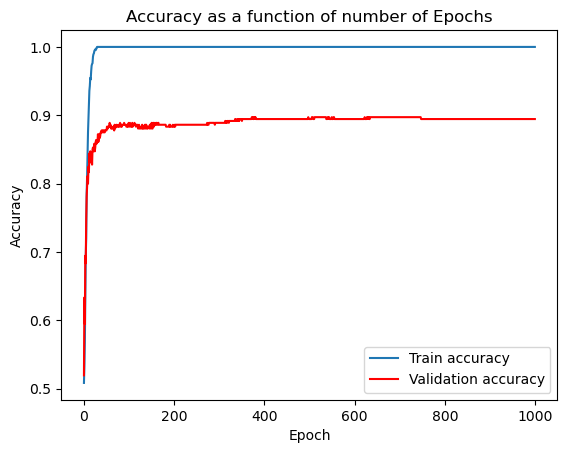

In [44]:
# your code here

epochs = [i for i in range(epochs)]
plt.plot(epochs,history.history['accuracy'],label="Train accuracy")
plt.plot(epochs,history.history['val_accuracy'],label="Validation accuracy", color='red')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy as a function of number of Epochs")
plt.show()

In [45]:
model_overfit.summary()

Model: "model_overfit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_228 (Dense)           (None, 100)               78500     
                                                                 
 dense_229 (Dense)           (None, 100)               10100     
                                                                 
 dense_230 (Dense)           (None, 100)               10100     
                                                                 
 dense_231 (Dense)           (None, 1)                 101       
                                                                 
Total params: 98,801
Trainable params: 98,801
Non-trainable params: 0
_________________________________________________________________


<div class='exercise-r'>

**2.3.1**  **Regularize the overfit network**

Create an ANN that doesn't overfit and use it to [compete on Kaggle](#part2kaggle).

<a id="q2.3.1"></a>
    
**DON'TS**

- **DO NOT change the architecture**. In other words, keep the same number of layers, same number of nodes, same activation function, and same loss function and output unit as was used in your question 2.2 overfit model. **No CNNs, RNNs, ensembles, or fancy enhancements.**

- **DO NOT manually label your submissions.** In other words, the labels should only be the outcome of your model.

- **DO NOT use any external data.** Please use ONLY the specific KMNIST datasets provided to you (via the CS109B [data link above](#part2data)) for training your model and for generating your test predictions.

**DOS**

 - **YOU CAN change the** number of epochs (max 2000), batch size, optimizer, and of course, add elements that can help to regularize your model (e.g., dropout, L2 norm, etc.).
 - **YOU CAN also** do data augmentation using the provided training data. 
 - **YOU CAN** add flatten layers as you see fit.

**IMPORTANT: YOU MUST** ensure that the version of the code and model in your final submitted notebook is the **EXACT SAME** code and model used to generate your Kaggle submission. TFs may run your submitted model to ensure comparable results. **Other Kaggle competition rules and scoring details [are listed here](#part2kaggle).**



</div>

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GaussianNoise

## Regularization

We start by varying the $C$ parameter to find out which value of $C$ and which form of regularization is most appropriate. 

In a neural network with L1 regularization, the regularization term is added to the cost function in the following form:

$J(w) = \frac{1}{m} \sum_{i=1}^m L(y_i, \hat{y}i) + \frac{C}{m} \sum{l=1}^L ||w^{(l)}||_1$

where $J(w)$ is the cost function, $m$ is the number of training examples, $L(y_i, \hat{y}_i)$ is the loss function for the $i$-th example, $w^{(l)}$ are the weights of layer $l$ in the neural network, $L$ is the number of layers, $C$ is the regularization parameter, and $||w^{(l)}||_1$ is the L1 norm of the weights in layer $l$.

The L1 norm is defined as:

$||w||1 = \sum{i=1}^n |w_i|$

where $w_i$ are the individual elements of the weight vector $w$.

The effect of varying the C parameter on the L1 regularization is straightforward. Increasing the value of C will increase the weight of the regularization term in the cost function. This means that the algorithm will prefer models with smaller weights, which leads to sparsity in the weight vector. As a result, some of the weights will be set to zero, effectively eliminating some of the input features that are not important for the prediction.

In [50]:
%%time 

# Define an early stopping callback that will stop training when the validation loss has not improved for 75 epochs and restore the weights from the best epoch
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=75, restore_best_weights=True, verbose=1)

# Define a list of regularization strengths to test
Cs = [10**i for i in range(-4, 2)]

validation_accuracies_L1 = []
for l in Cs:
    l_reg = tf.keras.regularizers.L1(l)
    
    inputs = tf.keras.layers.Input(shape=(784,))
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy',metrics=["accuracy"])
    history=model.fit(x_train,y_train,epochs=300,batch_size=128,validation_split=0.3,callbacks = callback )
    validation_accuracies_L1.append(max(history.history['val_accuracy']))

Epoch 1/300
7/7 [==============================] - 1s 31ms/step - loss: 13.9781 - accuracy: 0.5500 - val_loss: 6.2764 - val_accuracy: 0.4778
Epoch 2/300
7/7 [==============================] - 0s 7ms/step - loss: 4.3656 - accuracy: 0.5036 - val_loss: 3.6686 - val_accuracy: 0.5028
Epoch 3/300
7/7 [==============================] - 0s 6ms/step - loss: 2.1515 - accuracy: 0.5726 - val_loss: 1.7229 - val_accuracy: 0.6056
Epoch 4/300
7/7 [==============================] - 0s 6ms/step - loss: 1.5140 - accuracy: 0.6524 - val_loss: 1.6257 - val_accuracy: 0.6222
Epoch 5/300
7/7 [==============================] - 0s 6ms/step - loss: 1.2649 - accuracy: 0.7345 - val_loss: 1.0616 - val_accuracy: 0.7528
Epoch 6/300
7/7 [==============================] - 0s 6ms/step - loss: 1.0016 - accuracy: 0.7690 - val_loss: 1.0222 - val_accuracy: 0.7472
Epoch 7/300
7/7 [==============================] - 0s 6ms/step - loss: 0.9261 - accuracy: 0.8024 - val_loss: 0.9231 - val_accuracy: 0.8167
Epoch 8/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.4279 - accuracy: 1.0000 - val_loss: 0.7210 - val_accuracy: 0.9111
Epoch 60/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4271 - accuracy: 1.0000 - val_loss: 0.7246 - val_accuracy: 0.9083
Epoch 61/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4262 - accuracy: 1.0000 - val_loss: 0.7230 - val_accuracy: 0.9111
Epoch 62/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4254 - accuracy: 1.0000 - val_loss: 0.7256 - val_accuracy: 0.9083
Epoch 63/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4247 - accuracy: 1.0000 - val_loss: 0.7255 - val_accuracy: 0.9083
Epoch 64/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4239 - accuracy: 1.0000 - val_loss: 0.7217 - val_accuracy: 0.9139
Epoch 65/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4233 - accuracy: 1.0000 - val_loss: 0.7287 - val_accuracy: 0.9111
Epoch 66/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 4.3809 - accuracy: 0.9714 - val_loss: 4.6601 - val_accuracy: 0.8583
Epoch 14/300
7/7 [==============================] - 0s 6ms/step - loss: 4.3283 - accuracy: 0.9738 - val_loss: 4.6157 - val_accuracy: 0.8667
Epoch 15/300
7/7 [==============================] - 0s 6ms/step - loss: 4.2628 - accuracy: 0.9810 - val_loss: 4.5872 - val_accuracy: 0.8778
Epoch 16/300
7/7 [==============================] - 0s 6ms/step - loss: 4.2114 - accuracy: 0.9893 - val_loss: 4.5447 - val_accuracy: 0.8667
Epoch 17/300
7/7 [==============================] - 0s 6ms/step - loss: 4.1588 - accuracy: 0.9929 - val_loss: 4.4946 - val_accuracy: 0.8944
Epoch 18/300
7/7 [==============================] - 0s 6ms/step - loss: 4.1113 - accuracy: 0.9940 - val_loss: 4.4680 - val_accuracy: 0.8861
Epoch 19/300
7/7 [==============================] - 0s 6ms/step - loss: 4.0688 - accuracy: 0.9952 - val_loss: 4.4066 - val_accuracy: 0.8944
Epoch 20/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 2.7598 - accuracy: 1.0000 - val_loss: 3.1079 - val_accuracy: 0.9111
Epoch 72/300
7/7 [==============================] - 0s 6ms/step - loss: 2.7394 - accuracy: 1.0000 - val_loss: 3.0821 - val_accuracy: 0.9111
Epoch 73/300
7/7 [==============================] - 0s 6ms/step - loss: 2.7191 - accuracy: 1.0000 - val_loss: 3.0634 - val_accuracy: 0.9111
Epoch 74/300
7/7 [==============================] - 0s 6ms/step - loss: 2.6989 - accuracy: 1.0000 - val_loss: 3.0410 - val_accuracy: 0.9111
Epoch 75/300
7/7 [==============================] - 0s 6ms/step - loss: 2.6787 - accuracy: 1.0000 - val_loss: 3.0162 - val_accuracy: 0.9083
Epoch 76/300
7/7 [==============================] - 0s 6ms/step - loss: 2.6590 - accuracy: 1.0000 - val_loss: 2.9971 - val_accuracy: 0.9139
Epoch 77/300
7/7 [==============================] - 0s 6ms/step - loss: 2.6388 - accuracy: 1.0000 - val_loss: 2.9804 - val_accuracy: 0.9111
Epoch 78/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 1.7431 - accuracy: 1.0000 - val_loss: 2.0231 - val_accuracy: 0.9222
Epoch 130/300
7/7 [==============================] - 0s 6ms/step - loss: 1.7283 - accuracy: 1.0000 - val_loss: 1.9981 - val_accuracy: 0.9278
Epoch 131/300
7/7 [==============================] - 0s 6ms/step - loss: 1.7135 - accuracy: 1.0000 - val_loss: 1.9813 - val_accuracy: 0.9278
Epoch 132/300
7/7 [==============================] - 0s 6ms/step - loss: 1.6989 - accuracy: 1.0000 - val_loss: 1.9654 - val_accuracy: 0.9306
Epoch 133/300
7/7 [==============================] - 0s 6ms/step - loss: 1.6843 - accuracy: 1.0000 - val_loss: 1.9484 - val_accuracy: 0.9306
Epoch 134/300
7/7 [==============================] - 0s 6ms/step - loss: 1.6700 - accuracy: 1.0000 - val_loss: 1.9361 - val_accuracy: 0.9278
Epoch 135/300
7/7 [==============================] - 0s 6ms/step - loss: 1.6554 - accuracy: 1.0000 - val_loss: 1.9168 - val_accuracy: 0.9306
Epoch 136/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 1.4903 - accuracy: 0.9798 - val_loss: 1.6442 - val_accuracy: 0.9167
Epoch 188/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4683 - accuracy: 0.9798 - val_loss: 1.5755 - val_accuracy: 0.9361
Epoch 189/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4394 - accuracy: 0.9905 - val_loss: 1.5625 - val_accuracy: 0.9472
Epoch 190/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4173 - accuracy: 0.9893 - val_loss: 1.5511 - val_accuracy: 0.9444
Epoch 191/300
7/7 [==============================] - 0s 6ms/step - loss: 1.3958 - accuracy: 0.9952 - val_loss: 1.5400 - val_accuracy: 0.9472
Epoch 192/300
7/7 [==============================] - 0s 6ms/step - loss: 1.3767 - accuracy: 0.9952 - val_loss: 1.5359 - val_accuracy: 0.9361
Epoch 193/300
7/7 [==============================] - 0s 6ms/step - loss: 1.3587 - accuracy: 0.9952 - val_loss: 1.5212 - val_accuracy: 0.9389
Epoch 194/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.8602 - accuracy: 1.0000 - val_loss: 1.0798 - val_accuracy: 0.9472
Epoch 246/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8535 - accuracy: 1.0000 - val_loss: 1.0731 - val_accuracy: 0.9472
Epoch 247/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8467 - accuracy: 1.0000 - val_loss: 1.0660 - val_accuracy: 0.9472
Epoch 248/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8402 - accuracy: 1.0000 - val_loss: 1.0617 - val_accuracy: 0.9472
Epoch 249/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8337 - accuracy: 1.0000 - val_loss: 1.0531 - val_accuracy: 0.9472
Epoch 250/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8271 - accuracy: 1.0000 - val_loss: 1.0486 - val_accuracy: 0.9472
Epoch 251/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8207 - accuracy: 1.0000 - val_loss: 1.0419 - val_accuracy: 0.9472
Epoch 252/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 47.7879 - accuracy: 0.5810 - val_loss: 46.1093 - val_accuracy: 0.6500
Epoch 4/300
7/7 [==============================] - 0s 6ms/step - loss: 45.5859 - accuracy: 0.6036 - val_loss: 44.4305 - val_accuracy: 0.6222
Epoch 5/300
7/7 [==============================] - 0s 6ms/step - loss: 43.8531 - accuracy: 0.6548 - val_loss: 42.9340 - val_accuracy: 0.6417
Epoch 6/300
7/7 [==============================] - 0s 6ms/step - loss: 42.1200 - accuracy: 0.6857 - val_loss: 41.1561 - val_accuracy: 0.6750
Epoch 7/300
7/7 [==============================] - 0s 6ms/step - loss: 40.4157 - accuracy: 0.7107 - val_loss: 39.4795 - val_accuracy: 0.7111
Epoch 8/300
7/7 [==============================] - 0s 6ms/step - loss: 38.7615 - accuracy: 0.7905 - val_loss: 37.9072 - val_accuracy: 0.7583
Epoch 9/300
7/7 [==============================] - 0s 6ms/step - loss: 37.2002 - accuracy: 0.8214 - val_loss: 36.3975 - val_accuracy: 0.7722
Epoch 10/300
7/7 [=======

Epoch 61/300
7/7 [==============================] - 0s 6ms/step - loss: 7.3854 - accuracy: 1.0000 - val_loss: 7.4276 - val_accuracy: 0.9389
Epoch 62/300
7/7 [==============================] - 0s 6ms/step - loss: 7.2034 - accuracy: 0.9988 - val_loss: 7.2110 - val_accuracy: 0.9528
Epoch 63/300
7/7 [==============================] - 0s 6ms/step - loss: 7.0176 - accuracy: 1.0000 - val_loss: 7.0348 - val_accuracy: 0.9528
Epoch 64/300
7/7 [==============================] - 0s 6ms/step - loss: 6.8492 - accuracy: 0.9976 - val_loss: 6.8563 - val_accuracy: 0.9667
Epoch 65/300
7/7 [==============================] - 0s 6ms/step - loss: 6.6860 - accuracy: 0.9976 - val_loss: 6.6909 - val_accuracy: 0.9583
Epoch 66/300
7/7 [==============================] - 0s 6ms/step - loss: 6.5165 - accuracy: 1.0000 - val_loss: 6.5299 - val_accuracy: 0.9639
Epoch 67/300
7/7 [==============================] - 0s 6ms/step - loss: 6.3562 - accuracy: 0.9988 - val_loss: 6.3722 - val_accuracy: 0.9611
Epoch 68/300
7/7 [==

7/7 [==============================] - 0s 6ms/step - loss: 2.5850 - accuracy: 0.9393 - val_loss: 2.6863 - val_accuracy: 0.9083
Epoch 120/300
7/7 [==============================] - 0s 6ms/step - loss: 2.4681 - accuracy: 0.9786 - val_loss: 2.5177 - val_accuracy: 0.9417
Epoch 121/300
7/7 [==============================] - 0s 6ms/step - loss: 2.3897 - accuracy: 0.9857 - val_loss: 2.4363 - val_accuracy: 0.9556
Epoch 122/300
7/7 [==============================] - 0s 6ms/step - loss: 2.3308 - accuracy: 0.9905 - val_loss: 2.3929 - val_accuracy: 0.9528
Epoch 123/300
7/7 [==============================] - 0s 6ms/step - loss: 2.2882 - accuracy: 0.9929 - val_loss: 2.3537 - val_accuracy: 0.9528
Epoch 124/300
7/7 [==============================] - 0s 6ms/step - loss: 2.2398 - accuracy: 0.9976 - val_loss: 2.3213 - val_accuracy: 0.9583
Epoch 125/300
7/7 [==============================] - 0s 6ms/step - loss: 2.2135 - accuracy: 0.9940 - val_loss: 2.2976 - val_accuracy: 0.9528
Epoch 126/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 1.2892 - accuracy: 0.9988 - val_loss: 1.4001 - val_accuracy: 0.9528
Epoch 178/300
7/7 [==============================] - 0s 6ms/step - loss: 1.2777 - accuracy: 0.9952 - val_loss: 1.3832 - val_accuracy: 0.9528
Epoch 179/300
7/7 [==============================] - 0s 6ms/step - loss: 1.2657 - accuracy: 0.9988 - val_loss: 1.3802 - val_accuracy: 0.9444
Epoch 180/300
7/7 [==============================] - 0s 6ms/step - loss: 1.2663 - accuracy: 0.9976 - val_loss: 1.3973 - val_accuracy: 0.9444
Epoch 181/300
7/7 [==============================] - 0s 6ms/step - loss: 1.2728 - accuracy: 0.9869 - val_loss: 1.3633 - val_accuracy: 0.9472
Epoch 182/300
7/7 [==============================] - 0s 6ms/step - loss: 1.2540 - accuracy: 0.9905 - val_loss: 1.3541 - val_accuracy: 0.9472
Epoch 183/300
7/7 [==============================] - 0s 6ms/step - loss: 1.2542 - accuracy: 0.9857 - val_loss: 1.3518 - val_accuracy: 0.9528
Epoch 184/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.8200 - accuracy: 1.0000 - val_loss: 0.9825 - val_accuracy: 0.9194
Epoch 236/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8265 - accuracy: 0.9952 - val_loss: 0.9536 - val_accuracy: 0.9472
Epoch 237/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8144 - accuracy: 0.9976 - val_loss: 0.9530 - val_accuracy: 0.9361
Epoch 238/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8060 - accuracy: 1.0000 - val_loss: 0.9364 - val_accuracy: 0.9472
Epoch 239/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8027 - accuracy: 0.9976 - val_loss: 0.9406 - val_accuracy: 0.9389
Epoch 240/300
7/7 [==============================] - 0s 6ms/step - loss: 0.7947 - accuracy: 1.0000 - val_loss: 0.9298 - val_accuracy: 0.9417
Epoch 241/300
7/7 [==============================] - 0s 6ms/step - loss: 0.7882 - accuracy: 1.0000 - val_loss: 0.9185 - val_accuracy: 0.9500
Epoch 242/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.5798 - accuracy: 1.0000 - val_loss: 0.7288 - val_accuracy: 0.9389
Epoch 294/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5807 - accuracy: 0.9976 - val_loss: 0.7206 - val_accuracy: 0.9500
Epoch 295/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5769 - accuracy: 0.9952 - val_loss: 0.7268 - val_accuracy: 0.9333
Epoch 296/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5776 - accuracy: 0.9976 - val_loss: 0.7217 - val_accuracy: 0.9472
Epoch 297/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5904 - accuracy: 0.9881 - val_loss: 0.7094 - val_accuracy: 0.9500
Epoch 298/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5733 - accuracy: 0.9988 - val_loss: 0.7221 - val_accuracy: 0.9389
Epoch 299/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5629 - accuracy: 0.9988 - val_loss: 0.7173 - val_accuracy: 0.9361
Epoch 300/300
7/7 [========

Epoch 51/300
7/7 [==============================] - 0s 6ms/step - loss: 9.5804 - accuracy: 0.9321 - val_loss: 9.3500 - val_accuracy: 0.9472
Epoch 52/300
7/7 [==============================] - 0s 6ms/step - loss: 9.2428 - accuracy: 0.9286 - val_loss: 9.0286 - val_accuracy: 0.9472
Epoch 53/300
7/7 [==============================] - 0s 6ms/step - loss: 8.9250 - accuracy: 0.9321 - val_loss: 8.7163 - val_accuracy: 0.9472
Epoch 54/300
7/7 [==============================] - 0s 6ms/step - loss: 8.6041 - accuracy: 0.9333 - val_loss: 8.4104 - val_accuracy: 0.9528
Epoch 55/300
7/7 [==============================] - 0s 6ms/step - loss: 8.3450 - accuracy: 0.9024 - val_loss: 8.1782 - val_accuracy: 0.8889
Epoch 56/300
7/7 [==============================] - 0s 6ms/step - loss: 8.0558 - accuracy: 0.9250 - val_loss: 7.8621 - val_accuracy: 0.9528
Epoch 57/300
7/7 [==============================] - 0s 6ms/step - loss: 7.7696 - accuracy: 0.9345 - val_loss: 7.6022 - val_accuracy: 0.9528
Epoch 58/300
7/7 [==

7/7 [==============================] - 0s 6ms/step - loss: 2.4358 - accuracy: 0.9429 - val_loss: 2.4399 - val_accuracy: 0.9083
Epoch 110/300
7/7 [==============================] - 0s 8ms/step - loss: 2.4178 - accuracy: 0.9357 - val_loss: 2.3922 - val_accuracy: 0.9583
Epoch 111/300
7/7 [==============================] - 0s 8ms/step - loss: 2.3854 - accuracy: 0.9500 - val_loss: 2.3477 - val_accuracy: 0.9583
Epoch 112/300
7/7 [==============================] - 0s 9ms/step - loss: 2.3484 - accuracy: 0.9393 - val_loss: 2.3343 - val_accuracy: 0.9444
Epoch 113/300
7/7 [==============================] - 0s 9ms/step - loss: 2.3322 - accuracy: 0.9333 - val_loss: 2.3472 - val_accuracy: 0.8944
Epoch 114/300
7/7 [==============================] - 0s 8ms/step - loss: 2.3307 - accuracy: 0.9131 - val_loss: 2.2701 - val_accuracy: 0.9500
Epoch 115/300
7/7 [==============================] - 0s 8ms/step - loss: 2.2633 - accuracy: 0.9381 - val_loss: 2.2252 - val_accuracy: 0.9556
Epoch 116/300
7/7 [========

7/7 [==============================] - 0s 9ms/step - loss: 1.5672 - accuracy: 0.9548 - val_loss: 1.5863 - val_accuracy: 0.9194
Epoch 168/300
7/7 [==============================] - 0s 10ms/step - loss: 1.5512 - accuracy: 0.9476 - val_loss: 1.6186 - val_accuracy: 0.9389
Epoch 169/300
7/7 [==============================] - 0s 8ms/step - loss: 1.6150 - accuracy: 0.9083 - val_loss: 1.5446 - val_accuracy: 0.9528
Epoch 170/300
7/7 [==============================] - 0s 8ms/step - loss: 1.5493 - accuracy: 0.9571 - val_loss: 1.5657 - val_accuracy: 0.9333
Epoch 171/300
7/7 [==============================] - 0s 8ms/step - loss: 1.5661 - accuracy: 0.9405 - val_loss: 1.5430 - val_accuracy: 0.9556
Epoch 172/300
7/7 [==============================] - 0s 8ms/step - loss: 1.5466 - accuracy: 0.9560 - val_loss: 1.5522 - val_accuracy: 0.9361
Epoch 173/300
7/7 [==============================] - 0s 8ms/step - loss: 1.5318 - accuracy: 0.9548 - val_loss: 1.5345 - val_accuracy: 0.9556
Epoch 174/300
7/7 [=======

7/7 [==============================] - 0s 7ms/step - loss: 1.4658 - accuracy: 0.9607 - val_loss: 1.4726 - val_accuracy: 0.9528
Epoch 226/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4621 - accuracy: 0.9667 - val_loss: 1.5102 - val_accuracy: 0.9194
Epoch 227/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4784 - accuracy: 0.9488 - val_loss: 1.5353 - val_accuracy: 0.9361
Epoch 228/300
7/7 [==============================] - 0s 7ms/step - loss: 1.5181 - accuracy: 0.9333 - val_loss: 1.5820 - val_accuracy: 0.8944
Epoch 229/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4871 - accuracy: 0.9524 - val_loss: 1.5152 - val_accuracy: 0.9500
Epoch 230/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4703 - accuracy: 0.9595 - val_loss: 1.5639 - val_accuracy: 0.9000
Epoch 231/300
7/7 [==============================] - 0s 8ms/step - loss: 1.4901 - accuracy: 0.9488 - val_loss: 1.4792 - val_accuracy: 0.9611
Epoch 232/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 1.4317 - accuracy: 0.9690 - val_loss: 1.4730 - val_accuracy: 0.9278
Epoch 284/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4418 - accuracy: 0.9560 - val_loss: 1.4456 - val_accuracy: 0.9556
Epoch 285/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4345 - accuracy: 0.9631 - val_loss: 1.4537 - val_accuracy: 0.9500
Epoch 286/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4336 - accuracy: 0.9679 - val_loss: 1.4495 - val_accuracy: 0.9500
Epoch 287/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4405 - accuracy: 0.9595 - val_loss: 1.4582 - val_accuracy: 0.9444
Epoch 288/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4725 - accuracy: 0.9452 - val_loss: 1.4964 - val_accuracy: 0.9528
Epoch 289/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4771 - accuracy: 0.9452 - val_loss: 1.4560 - val_accuracy: 0.9472
Epoch 290/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 13.8507 - accuracy: 0.5250 - val_loss: 13.6364 - val_accuracy: 0.4944
Epoch 41/300
7/7 [==============================] - 0s 6ms/step - loss: 13.5250 - accuracy: 0.5250 - val_loss: 13.3475 - val_accuracy: 0.4944
Epoch 42/300
7/7 [==============================] - 0s 6ms/step - loss: 13.2301 - accuracy: 0.5250 - val_loss: 13.0794 - val_accuracy: 0.4944
Epoch 43/300
7/7 [==============================] - 0s 6ms/step - loss: 13.0168 - accuracy: 0.5250 - val_loss: 12.9348 - val_accuracy: 0.4944
Epoch 44/300
7/7 [==============================] - 0s 6ms/step - loss: 12.8555 - accuracy: 0.5250 - val_loss: 12.7371 - val_accuracy: 0.4944
Epoch 45/300
7/7 [==============================] - 0s 6ms/step - loss: 12.6696 - accuracy: 0.5250 - val_loss: 12.5752 - val_accuracy: 0.4944
Epoch 46/300
7/7 [==============================] - 0s 6ms/step - loss: 12.5196 - accuracy: 0.5250 - val_loss: 12.4258 - val_accuracy: 0.4944
Epoch 47/300
7/7 [=

Epoch 98/300
7/7 [==============================] - 0s 6ms/step - loss: 11.8918 - accuracy: 0.5250 - val_loss: 11.8815 - val_accuracy: 0.4944
Epoch 99/300
7/7 [==============================] - 0s 6ms/step - loss: 11.8890 - accuracy: 0.5250 - val_loss: 11.8996 - val_accuracy: 0.4944
Epoch 100/300
7/7 [==============================] - 0s 6ms/step - loss: 11.8924 - accuracy: 0.5250 - val_loss: 11.9103 - val_accuracy: 0.4944
Epoch 101/300
7/7 [==============================] - 0s 6ms/step - loss: 11.8900 - accuracy: 0.5250 - val_loss: 11.8663 - val_accuracy: 0.4944
Epoch 102/300
7/7 [==============================] - 0s 6ms/step - loss: 11.8828 - accuracy: 0.5250 - val_loss: 11.8744 - val_accuracy: 0.4944
Epoch 103/300
7/7 [==============================] - 0s 6ms/step - loss: 11.8857 - accuracy: 0.5250 - val_loss: 11.9014 - val_accuracy: 0.4944
Epoch 104/300
7/7 [==============================] - 0s 6ms/step - loss: 11.9000 - accuracy: 0.5250 - val_loss: 11.9394 - val_accuracy: 0.4944
E

Epoch 17/300
7/7 [==============================] - 0s 6ms/step - loss: 2198.7571 - accuracy: 0.5250 - val_loss: 1912.0000 - val_accuracy: 0.4944
Epoch 18/300
7/7 [==============================] - 0s 6ms/step - loss: 1737.6986 - accuracy: 0.5250 - val_loss: 1488.7637 - val_accuracy: 0.4944
Epoch 19/300
7/7 [==============================] - 0s 6ms/step - loss: 1339.9244 - accuracy: 0.5250 - val_loss: 1127.7412 - val_accuracy: 0.4944
Epoch 20/300
7/7 [==============================] - 0s 6ms/step - loss: 1001.6247 - accuracy: 0.5250 - val_loss: 823.7305 - val_accuracy: 0.4944
Epoch 21/300
7/7 [==============================] - 0s 6ms/step - loss: 720.6862 - accuracy: 0.5250 - val_loss: 577.0306 - val_accuracy: 0.4944
Epoch 22/300
7/7 [==============================] - 0s 6ms/step - loss: 497.1481 - accuracy: 0.5250 - val_loss: 388.4667 - val_accuracy: 0.4944
Epoch 23/300
7/7 [==============================] - 0s 6ms/step - loss: 330.2539 - accuracy: 0.5250 - val_loss: 256.4297 - val_ac

Epoch 74/300
7/7 [==============================] - 0s 6ms/step - loss: 123.3093 - accuracy: 0.5250 - val_loss: 122.5737 - val_accuracy: 0.4944
Epoch 75/300
7/7 [==============================] - 0s 6ms/step - loss: 122.4656 - accuracy: 0.5250 - val_loss: 122.0912 - val_accuracy: 0.4944
Epoch 76/300
7/7 [==============================] - 0s 6ms/step - loss: 122.5240 - accuracy: 0.5250 - val_loss: 123.6134 - val_accuracy: 0.4944
Epoch 77/300
7/7 [==============================] - 0s 6ms/step - loss: 123.0684 - accuracy: 0.5250 - val_loss: 123.2796 - val_accuracy: 0.4944
Epoch 78/300
7/7 [==============================] - 0s 6ms/step - loss: 123.1050 - accuracy: 0.5250 - val_loss: 122.8699 - val_accuracy: 0.4944
Epoch 79/300
7/7 [==============================] - 0s 6ms/step - loss: 122.8259 - accuracy: 0.5250 - val_loss: 122.5918 - val_accuracy: 0.4944
Epoch 80/300
7/7 [==============================] - 0s 6ms/step - loss: 122.6359 - accuracy: 0.5250 - val_loss: 122.5683 - val_accuracy:

Epoch 131/300
7/7 [==============================] - 0s 6ms/step - loss: 122.7967 - accuracy: 0.5250 - val_loss: 122.4780 - val_accuracy: 0.4944
Epoch 132/300
7/7 [==============================] - 0s 6ms/step - loss: 122.5230 - accuracy: 0.5250 - val_loss: 123.4645 - val_accuracy: 0.4944
Epoch 133/300
7/7 [==============================] - 0s 6ms/step - loss: 123.1255 - accuracy: 0.5250 - val_loss: 122.7987 - val_accuracy: 0.4944
Epoch 134/300
7/7 [==============================] - 0s 6ms/step - loss: 123.1886 - accuracy: 0.5250 - val_loss: 122.6030 - val_accuracy: 0.4944
Epoch 135/300
7/7 [==============================] - 0s 6ms/step - loss: 122.6700 - accuracy: 0.5250 - val_loss: 122.4093 - val_accuracy: 0.4944
Epoch 136/300
7/7 [==============================] - 0s 6ms/step - loss: 122.4908 - accuracy: 0.5250 - val_loss: 123.2473 - val_accuracy: 0.4944
Epoch 137/300
7/7 [==============================] - 0s 6ms/step - loss: 122.8083 - accuracy: 0.5250 - val_loss: 123.4689 - val_ac

In a neural network with L2 regularization, the regularization term is added to the cost function in the following form:

$J(w) = \frac{1}{m} \sum_{i=1}^m L(y_i, \hat{y}i) + \frac{C}{2m} \sum{l=1}^L ||w^{(l)}||_2^2$

where $J(w)$ is the cost function, $m$ is the number of training examples, $L(y_i, \hat{y}_i)$ is the loss function for the $i$-th example, $w^{(l)}$ are the weights of layer $l$ in the neural network, $L$ is the number of layers, $C$ is the regularization parameter, and $||w^{(l)}||_2$ is the L2 norm of the weights in layer $l$.

The L2 norm is defined as:

$||w||2 = \sqrt{\sum{i=1}^n w_i^2}$

where $w_i$ are the individual elements of the weight vector $w$.

The effect of varying the C parameter on the L2 regularization is also straightforward. Increasing the value of C will increase the weight of the regularization term in the cost function, but in this case, it will penalize large weights in the model. This means that the algorithm will prefer models with smaller weights, but it will not force them to be exactly zero, as is the case with L1 regularization.

In [51]:
%%time

# Create an empty list to store the best validation accuracy achieved for each value of C
validation_accuracies_L2 = []

# Loop through each value of C
for l in Cs:
    
    # Define an L2 regularization object with strength l
    l_reg = tf.keras.regularizers.L2(l)
    
    # Define the model architecture
    inputs = tf.keras.layers.Input(shape=(784,))
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])
    
    # Train the model with early stopping callback
    history=model.fit(x_train,y_train,epochs=300,batch_size=128,validation_split=0.3,callbacks = callback )
    
    # Append the best validation accuracy achieved for this value of C to the list
    validation_accuracies_L2.append(max(history.history['val_accuracy']))



Epoch 1/300
7/7 [==============================] - 1s 28ms/step - loss: 7.4207 - accuracy: 0.5631 - val_loss: 1.9942 - val_accuracy: 0.6694
Epoch 2/300
7/7 [==============================] - 0s 7ms/step - loss: 1.2259 - accuracy: 0.7155 - val_loss: 1.0044 - val_accuracy: 0.7611
Epoch 3/300
7/7 [==============================] - 0s 6ms/step - loss: 0.7307 - accuracy: 0.8024 - val_loss: 0.8220 - val_accuracy: 0.8167
Epoch 4/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4725 - accuracy: 0.8548 - val_loss: 0.7304 - val_accuracy: 0.7944
Epoch 5/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4733 - accuracy: 0.8595 - val_loss: 0.9750 - val_accuracy: 0.7944
Epoch 6/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4148 - accuracy: 0.8714 - val_loss: 0.6319 - val_accuracy: 0.8417
Epoch 7/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2605 - accuracy: 0.9036 - val_loss: 0.5373 - val_accuracy: 0.8528
Epoch 8/300
7/7 [=========

7/7 [==============================] - 0s 6ms/step - loss: 0.0336 - accuracy: 1.0000 - val_loss: 0.5114 - val_accuracy: 0.8861
Epoch 60/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0335 - accuracy: 1.0000 - val_loss: 0.5110 - val_accuracy: 0.8861
Epoch 61/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0335 - accuracy: 1.0000 - val_loss: 0.5146 - val_accuracy: 0.8889
Epoch 62/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0334 - accuracy: 1.0000 - val_loss: 0.5134 - val_accuracy: 0.8861
Epoch 63/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0333 - accuracy: 1.0000 - val_loss: 0.5151 - val_accuracy: 0.8861
Epoch 64/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0333 - accuracy: 1.0000 - val_loss: 0.5160 - val_accuracy: 0.8861
Epoch 65/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0332 - accuracy: 1.0000 - val_loss: 0.5150 - val_accuracy: 0.8861
Epoch 66/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 0.3261 - accuracy: 1.0000 - val_loss: 0.6887 - val_accuracy: 0.8917
Epoch 30/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3252 - accuracy: 1.0000 - val_loss: 0.6890 - val_accuracy: 0.8917
Epoch 31/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3233 - accuracy: 1.0000 - val_loss: 0.7011 - val_accuracy: 0.9083
Epoch 32/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3223 - accuracy: 1.0000 - val_loss: 0.6907 - val_accuracy: 0.8889
Epoch 33/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3206 - accuracy: 1.0000 - val_loss: 0.6977 - val_accuracy: 0.9111
Epoch 34/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3190 - accuracy: 1.0000 - val_loss: 0.6940 - val_accuracy: 0.8889
Epoch 35/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3178 - accuracy: 1.0000 - val_loss: 0.7065 - val_accuracy: 0.9083
Epoch 36/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 0.2722 - accuracy: 1.0000 - val_loss: 0.7062 - val_accuracy: 0.9000
Epoch 88/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2715 - accuracy: 1.0000 - val_loss: 0.7037 - val_accuracy: 0.9000
Epoch 89/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2708 - accuracy: 1.0000 - val_loss: 0.7068 - val_accuracy: 0.9000
Epoch 90/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2701 - accuracy: 1.0000 - val_loss: 0.7016 - val_accuracy: 0.8972
Epoch 91/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2694 - accuracy: 1.0000 - val_loss: 0.7032 - val_accuracy: 0.9000
Epoch 92/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2686 - accuracy: 1.0000 - val_loss: 0.7020 - val_accuracy: 0.9028
Epoch 93/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2679 - accuracy: 1.0000 - val_loss: 0.7078 - val_accuracy: 0.9111
Epoch 93: early stopping
Epoch 1/

7/7 [==============================] - 0s 6ms/step - loss: 2.1468 - accuracy: 1.0000 - val_loss: 2.5218 - val_accuracy: 0.9000
Epoch 52/300
7/7 [==============================] - 0s 6ms/step - loss: 2.1277 - accuracy: 1.0000 - val_loss: 2.5022 - val_accuracy: 0.8972
Epoch 53/300
7/7 [==============================] - 0s 6ms/step - loss: 2.1094 - accuracy: 1.0000 - val_loss: 2.4934 - val_accuracy: 0.9028
Epoch 54/300
7/7 [==============================] - 0s 6ms/step - loss: 2.0913 - accuracy: 1.0000 - val_loss: 2.4808 - val_accuracy: 0.9056
Epoch 55/300
7/7 [==============================] - 0s 6ms/step - loss: 2.0735 - accuracy: 1.0000 - val_loss: 2.4722 - val_accuracy: 0.9111
Epoch 56/300
7/7 [==============================] - 0s 6ms/step - loss: 2.0559 - accuracy: 1.0000 - val_loss: 2.4435 - val_accuracy: 0.9028
Epoch 57/300
7/7 [==============================] - 0s 6ms/step - loss: 2.0378 - accuracy: 1.0000 - val_loss: 2.4264 - val_accuracy: 0.9056
Epoch 58/300
7/7 [===============

7/7 [==============================] - 0s 7ms/step - loss: 1.3168 - accuracy: 1.0000 - val_loss: 1.6840 - val_accuracy: 0.9000
Epoch 110/300
7/7 [==============================] - 0s 6ms/step - loss: 1.3060 - accuracy: 1.0000 - val_loss: 1.6729 - val_accuracy: 0.9000
Epoch 111/300
7/7 [==============================] - 0s 7ms/step - loss: 1.2951 - accuracy: 1.0000 - val_loss: 1.6628 - val_accuracy: 0.8944
Epoch 112/300
7/7 [==============================] - 0s 7ms/step - loss: 1.2845 - accuracy: 1.0000 - val_loss: 1.6566 - val_accuracy: 0.9056
Epoch 113/300
7/7 [==============================] - 0s 6ms/step - loss: 1.2739 - accuracy: 1.0000 - val_loss: 1.6457 - val_accuracy: 0.9028
Epoch 114/300
7/7 [==============================] - 0s 6ms/step - loss: 1.2634 - accuracy: 1.0000 - val_loss: 1.6347 - val_accuracy: 0.9000
Epoch 115/300
7/7 [==============================] - 0s 6ms/step - loss: 1.2530 - accuracy: 1.0000 - val_loss: 1.6213 - val_accuracy: 0.9028
Epoch 116/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.8950 - accuracy: 1.0000 - val_loss: 1.2326 - val_accuracy: 0.9250
Epoch 168/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8888 - accuracy: 1.0000 - val_loss: 1.2272 - val_accuracy: 0.9250
Epoch 169/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8825 - accuracy: 1.0000 - val_loss: 1.2251 - val_accuracy: 0.9250
Epoch 170/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8765 - accuracy: 1.0000 - val_loss: 1.2177 - val_accuracy: 0.9278
Epoch 171/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8701 - accuracy: 1.0000 - val_loss: 1.2133 - val_accuracy: 0.9250
Epoch 172/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8639 - accuracy: 1.0000 - val_loss: 1.2082 - val_accuracy: 0.9278
Epoch 173/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8579 - accuracy: 1.0000 - val_loss: 1.2042 - val_accuracy: 0.9250
Epoch 174/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.6008 - accuracy: 1.0000 - val_loss: 0.9608 - val_accuracy: 0.9306
Epoch 226/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5968 - accuracy: 1.0000 - val_loss: 0.9569 - val_accuracy: 0.9278
Epoch 227/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5928 - accuracy: 1.0000 - val_loss: 0.9529 - val_accuracy: 0.9306
Epoch 228/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5888 - accuracy: 1.0000 - val_loss: 0.9490 - val_accuracy: 0.9278
Epoch 229/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5848 - accuracy: 1.0000 - val_loss: 0.9452 - val_accuracy: 0.9278
Epoch 230/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5809 - accuracy: 1.0000 - val_loss: 0.9411 - val_accuracy: 0.9306
Epoch 231/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5770 - accuracy: 1.0000 - val_loss: 0.9372 - val_accuracy: 0.9278
Epoch 232/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.4081 - accuracy: 1.0000 - val_loss: 0.7668 - val_accuracy: 0.9278
Epoch 284/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4054 - accuracy: 1.0000 - val_loss: 0.7634 - val_accuracy: 0.9278
Epoch 285/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4028 - accuracy: 1.0000 - val_loss: 0.7604 - val_accuracy: 0.9306
Epoch 286/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4001 - accuracy: 1.0000 - val_loss: 0.7575 - val_accuracy: 0.9278
Epoch 287/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3975 - accuracy: 1.0000 - val_loss: 0.7541 - val_accuracy: 0.9306
Epoch 288/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3949 - accuracy: 1.0000 - val_loss: 0.7513 - val_accuracy: 0.9278
Epoch 289/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3923 - accuracy: 1.0000 - val_loss: 0.7487 - val_accuracy: 0.9278
Epoch 290/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 8.1788 - accuracy: 1.0000 - val_loss: 8.2240 - val_accuracy: 0.9278
Epoch 42/300
7/7 [==============================] - 0s 6ms/step - loss: 7.9610 - accuracy: 1.0000 - val_loss: 8.0168 - val_accuracy: 0.9222
Epoch 43/300
7/7 [==============================] - 0s 6ms/step - loss: 7.7515 - accuracy: 1.0000 - val_loss: 7.8066 - val_accuracy: 0.9417
Epoch 44/300
7/7 [==============================] - 0s 6ms/step - loss: 7.5482 - accuracy: 1.0000 - val_loss: 7.6108 - val_accuracy: 0.9361
Epoch 45/300
7/7 [==============================] - 0s 6ms/step - loss: 7.3501 - accuracy: 1.0000 - val_loss: 7.4169 - val_accuracy: 0.9361
Epoch 46/300
7/7 [==============================] - 0s 6ms/step - loss: 7.1594 - accuracy: 1.0000 - val_loss: 7.2286 - val_accuracy: 0.9417
Epoch 47/300
7/7 [==============================] - 0s 6ms/step - loss: 6.9751 - accuracy: 1.0000 - val_loss: 7.0500 - val_accuracy: 0.9333
Epoch 48/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 2.5037 - accuracy: 0.9369 - val_loss: 2.5232 - val_accuracy: 0.9194
Epoch 100/300
7/7 [==============================] - 0s 6ms/step - loss: 2.4500 - accuracy: 0.9452 - val_loss: 2.4213 - val_accuracy: 0.9500
Epoch 101/300
7/7 [==============================] - 0s 6ms/step - loss: 2.3501 - accuracy: 0.9702 - val_loss: 2.3696 - val_accuracy: 0.9417
Epoch 102/300
7/7 [==============================] - 0s 6ms/step - loss: 2.2914 - accuracy: 0.9679 - val_loss: 2.3360 - val_accuracy: 0.9306
Epoch 103/300
7/7 [==============================] - 0s 6ms/step - loss: 2.2225 - accuracy: 0.9869 - val_loss: 2.2925 - val_accuracy: 0.9306
Epoch 104/300
7/7 [==============================] - 0s 6ms/step - loss: 2.1685 - accuracy: 0.9917 - val_loss: 2.2361 - val_accuracy: 0.9500
Epoch 105/300
7/7 [==============================] - 0s 6ms/step - loss: 2.1186 - accuracy: 0.9952 - val_loss: 2.2000 - val_accuracy: 0.9472
Epoch 106/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.9014 - accuracy: 1.0000 - val_loss: 1.0480 - val_accuracy: 0.9361
Epoch 158/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8880 - accuracy: 1.0000 - val_loss: 1.0309 - val_accuracy: 0.9444
Epoch 159/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8756 - accuracy: 1.0000 - val_loss: 1.0188 - val_accuracy: 0.9444
Epoch 160/300
7/7 [==============================] - 0s 9ms/step - loss: 0.8634 - accuracy: 1.0000 - val_loss: 1.0063 - val_accuracy: 0.9444
Epoch 161/300
7/7 [==============================] - 0s 8ms/step - loss: 0.8513 - accuracy: 1.0000 - val_loss: 0.9950 - val_accuracy: 0.9444
Epoch 162/300
7/7 [==============================] - 0s 9ms/step - loss: 0.8398 - accuracy: 1.0000 - val_loss: 0.9813 - val_accuracy: 0.9472
Epoch 163/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8280 - accuracy: 1.0000 - val_loss: 0.9721 - val_accuracy: 0.9389
Epoch 164/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.4236 - accuracy: 1.0000 - val_loss: 0.5841 - val_accuracy: 0.9306
Epoch 216/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4193 - accuracy: 1.0000 - val_loss: 0.5791 - val_accuracy: 0.9472
Epoch 217/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4143 - accuracy: 1.0000 - val_loss: 0.5709 - val_accuracy: 0.9444
Epoch 218/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4081 - accuracy: 1.0000 - val_loss: 0.5680 - val_accuracy: 0.9472
Epoch 219/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4037 - accuracy: 1.0000 - val_loss: 0.5662 - val_accuracy: 0.9306
Epoch 220/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3995 - accuracy: 1.0000 - val_loss: 0.5556 - val_accuracy: 0.9444
Epoch 221/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3942 - accuracy: 1.0000 - val_loss: 0.5518 - val_accuracy: 0.9444
Epoch 222/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.4479 - accuracy: 0.9881 - val_loss: 0.5093 - val_accuracy: 0.9583
Epoch 274/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4325 - accuracy: 0.9893 - val_loss: 0.5241 - val_accuracy: 0.9500
Epoch 275/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4400 - accuracy: 0.9833 - val_loss: 0.5300 - val_accuracy: 0.9444
Epoch 276/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4342 - accuracy: 0.9869 - val_loss: 0.4902 - val_accuracy: 0.9583
Epoch 277/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4232 - accuracy: 0.9845 - val_loss: 0.4857 - val_accuracy: 0.9583
Epoch 278/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4193 - accuracy: 0.9821 - val_loss: 0.4875 - val_accuracy: 0.9500
Epoch 279/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3989 - accuracy: 0.9869 - val_loss: 0.5208 - val_accuracy: 0.9389
Epoch 280/300
7/7 [========

Epoch 31/300
7/7 [==============================] - 0s 6ms/step - loss: 12.1130 - accuracy: 0.9738 - val_loss: 11.5763 - val_accuracy: 0.9278
Epoch 32/300
7/7 [==============================] - 0s 7ms/step - loss: 11.1348 - accuracy: 0.9702 - val_loss: 10.6405 - val_accuracy: 0.9444
Epoch 33/300
7/7 [==============================] - 0s 7ms/step - loss: 10.2557 - accuracy: 0.9738 - val_loss: 9.8219 - val_accuracy: 0.9389
Epoch 34/300
7/7 [==============================] - 0s 6ms/step - loss: 9.4626 - accuracy: 0.9798 - val_loss: 9.1138 - val_accuracy: 0.9278
Epoch 35/300
7/7 [==============================] - 0s 6ms/step - loss: 8.7707 - accuracy: 0.9810 - val_loss: 8.4912 - val_accuracy: 0.9083
Epoch 36/300
7/7 [==============================] - 0s 6ms/step - loss: 8.1587 - accuracy: 0.9667 - val_loss: 7.8567 - val_accuracy: 0.9250
Epoch 37/300
7/7 [==============================] - 0s 6ms/step - loss: 7.5640 - accuracy: 0.9810 - val_loss: 7.2875 - val_accuracy: 0.9556
Epoch 38/300
7/

7/7 [==============================] - 0s 6ms/step - loss: 0.7924 - accuracy: 0.9786 - val_loss: 0.8187 - val_accuracy: 0.9583
Epoch 90/300
7/7 [==============================] - 0s 6ms/step - loss: 0.7697 - accuracy: 0.9774 - val_loss: 0.8011 - val_accuracy: 0.9528
Epoch 91/300
7/7 [==============================] - 0s 6ms/step - loss: 0.7526 - accuracy: 0.9810 - val_loss: 0.7816 - val_accuracy: 0.9528
Epoch 92/300
7/7 [==============================] - 0s 6ms/step - loss: 0.7343 - accuracy: 0.9750 - val_loss: 0.7881 - val_accuracy: 0.9333
Epoch 93/300
7/7 [==============================] - 0s 6ms/step - loss: 0.7309 - accuracy: 0.9738 - val_loss: 0.7506 - val_accuracy: 0.9556
Epoch 94/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6981 - accuracy: 0.9810 - val_loss: 0.7375 - val_accuracy: 0.9528
Epoch 95/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.9833 - val_loss: 0.7194 - val_accuracy: 0.9583
Epoch 96/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 0.3978 - accuracy: 0.9714 - val_loss: 0.4495 - val_accuracy: 0.9333
Epoch 148/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3907 - accuracy: 0.9762 - val_loss: 0.4237 - val_accuracy: 0.9528
Epoch 149/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3730 - accuracy: 0.9845 - val_loss: 0.4244 - val_accuracy: 0.9500
Epoch 150/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3681 - accuracy: 0.9869 - val_loss: 0.4219 - val_accuracy: 0.9556
Epoch 151/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3675 - accuracy: 0.9881 - val_loss: 0.4205 - val_accuracy: 0.9556
Epoch 152/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3607 - accuracy: 0.9881 - val_loss: 0.4180 - val_accuracy: 0.9556
Epoch 153/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3724 - accuracy: 0.9833 - val_loss: 0.4182 - val_accuracy: 0.9528
Epoch 154/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.3048 - accuracy: 0.9893 - val_loss: 0.3670 - val_accuracy: 0.9500
Epoch 206/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2981 - accuracy: 0.9917 - val_loss: 0.3920 - val_accuracy: 0.9361
Epoch 207/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3121 - accuracy: 0.9881 - val_loss: 0.3665 - val_accuracy: 0.9472
Epoch 208/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3004 - accuracy: 0.9940 - val_loss: 0.3742 - val_accuracy: 0.9500
Epoch 209/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3155 - accuracy: 0.9798 - val_loss: 0.4136 - val_accuracy: 0.9167
Epoch 210/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3156 - accuracy: 0.9810 - val_loss: 0.3726 - val_accuracy: 0.9528
Epoch 211/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3170 - accuracy: 0.9845 - val_loss: 0.3775 - val_accuracy: 0.9528
Epoch 212/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.2873 - accuracy: 0.9810 - val_loss: 0.3448 - val_accuracy: 0.9472
Epoch 264/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2753 - accuracy: 0.9905 - val_loss: 0.3810 - val_accuracy: 0.9306
Epoch 265/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2808 - accuracy: 0.9917 - val_loss: 0.3434 - val_accuracy: 0.9500
Epoch 266/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2687 - accuracy: 0.9952 - val_loss: 0.3442 - val_accuracy: 0.9528
Epoch 267/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2671 - accuracy: 0.9964 - val_loss: 0.3436 - val_accuracy: 0.9500
Epoch 268/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2733 - accuracy: 0.9893 - val_loss: 0.3520 - val_accuracy: 0.9417
Epoch 269/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2633 - accuracy: 0.9952 - val_loss: 0.3472 - val_accuracy: 0.9500
Epoch 270/300
7/7 [========

Epoch 21/300
7/7 [==============================] - 0s 6ms/step - loss: 101.8192 - accuracy: 0.9345 - val_loss: 91.8071 - val_accuracy: 0.9528
Epoch 22/300
7/7 [==============================] - 0s 6ms/step - loss: 85.8027 - accuracy: 0.9429 - val_loss: 77.2827 - val_accuracy: 0.9528
Epoch 23/300
7/7 [==============================] - 0s 6ms/step - loss: 72.1782 - accuracy: 0.9190 - val_loss: 64.9342 - val_accuracy: 0.9111
Epoch 24/300
7/7 [==============================] - 0s 6ms/step - loss: 60.5904 - accuracy: 0.9179 - val_loss: 54.4372 - val_accuracy: 0.9472
Epoch 25/300
7/7 [==============================] - 0s 6ms/step - loss: 50.7614 - accuracy: 0.9083 - val_loss: 45.5495 - val_accuracy: 0.9389
Epoch 26/300
7/7 [==============================] - 0s 6ms/step - loss: 42.4357 - accuracy: 0.9298 - val_loss: 38.0309 - val_accuracy: 0.9500
Epoch 27/300
7/7 [==============================] - 0s 6ms/step - loss: 35.4045 - accuracy: 0.9286 - val_loss: 31.6920 - val_accuracy: 0.9500
Epoch

7/7 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5250 - val_loss: 0.6942 - val_accuracy: 0.4944
Epoch 80/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5250 - val_loss: 0.6942 - val_accuracy: 0.4944
Epoch 81/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5250 - val_loss: 0.6942 - val_accuracy: 0.4944
Epoch 82/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5250 - val_loss: 0.6942 - val_accuracy: 0.4944
Epoch 83/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5250 - val_loss: 0.6943 - val_accuracy: 0.4944
Epoch 84/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5250 - val_loss: 0.6943 - val_accuracy: 0.4944
Epoch 85/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5250 - val_loss: 0.6943 - val_accuracy: 0.4944
Epoch 86/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5250 - val_loss: 0.6949 - val_accuracy: 0.4944
Epoch 138/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5250 - val_loss: 0.6950 - val_accuracy: 0.4944
Epoch 139/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5250 - val_loss: 0.6950 - val_accuracy: 0.4944
Epoch 140/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5250 - val_loss: 0.6949 - val_accuracy: 0.4944
Epoch 141/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5250 - val_loss: 0.6949 - val_accuracy: 0.4944
Epoch 142/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.5250 - val_loss: 0.6949 - val_accuracy: 0.4944
Epoch 143/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5250 - val_loss: 0.6949 - val_accuracy: 0.4944
Epoch 144/300
7/7 [========

In [52]:
regularization_dic = {'Regularization Method':['L1', 'L2'], 
                     'Max Validation Accuracy':[max(validation_accuracies_L1), max(validation_accuracies_L2)],
                     'Value of C':[Cs[validation_accuracies_L1.index(max(validation_accuracies_L1))], 
                                   Cs[validation_accuracies_L2.index(max(validation_accuracies_L2))]]}

reg_df  = pd.DataFrame.from_dict(regularization_dic)
reg_df

,Regularization Method,Max Validation Accuracy,Value of C
0,L1,0.966667,0.01
1,L2,0.963889,1.00


It seems in the above dataframe that L1 achieved the max validation accuracy with $C = 0.01$. However, this may not always be the case across runs hence creating the need to automate the process of selecting best $C$ and method with code below. 

In [53]:
max_val_accuracy_row = reg_df.loc[reg_df['Max Validation Accuracy'].idxmax()]
C = max_val_accuracy_row['Value of C']
l_reg = tf.keras.regularizers.L1(C) if max_val_accuracy_row['Regularization Method'] == 'L1' else tf.keras.regularizers.L2(C)

## Dropout

Dropout regularization works by randomly dropping out some of the neurons in a layer during training, effectively reducing the complexity of the model and forcing it to learn more robust and generalizable features.

Mathematically, dropout regularization can be described as follows:

During each training iteration, a fraction $p$ of the neurons in a layer are randomly selected and "dropped out". This means that their output is set to zero, and they are effectively removed from the network for that iteration. The remaining neurons are scaled up by a factor of $1/(1-p)$ to ensure that the overall magnitude of the layer's output remains roughly constant.

The effect of dropout regularization can be seen in the forward propagation equations of the neural network. Let $x$ be the input to a layer, $W$ be the weight matrix, $b$ be the bias vector, $a$ be the activation function, and $y$ be the output. Then, the equation for a single layer can be written as:

$y = a(Wx+b)$

With dropout regularization, the equation becomes:

$y = a((W\odot m)x+b)$

where $\odot$ is the element-wise multiplication operator, and $m$ is a binary mask vector that randomly selects a subset of the neurons to keep. Specifically, each element of $m$ is set to 1 with probability $1-p$, and 0 with probability $p$. During training, the dropout mask $m$ is randomly generated for each mini-batch of examples, ensuring that the network sees a different subset of neurons each time. This has the effect of adding noise to the training process and reducing the impact of any individual neuron or feature. By averaging over many different subsets of neurons, the network learns to recognize more robust and generalizable features.

In [54]:
# Define a list of dropout rates to test
Ds = [0.05,0.1,0.2,0.3,0.4]

# Create an empty list to store validation accuracies for each dropout rate
dropout_validation_accuracies = []

# Loop through each dropout rate in the list
for d in Ds:
    
    # Define the input layer of the model
    inputs = tf.keras.layers.Input(shape=(784,))
    
    # Define the first hidden layer with ReLU activation and L2 regularization, and apply dropout
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
    x = tf.keras.layers.Dropout(d)(x)
    
    # Define the second hidden layer with ReLU activation and L2 regularization, and apply dropout
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    x = tf.keras.layers.Dropout(d)(x)
    
    # Define the third hidden layer with ReLU activation and L2 regularization, and apply dropout
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    x = tf.keras.layers.Dropout(d)(x)

    # Define the output layer with sigmoid activation
    outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
    
    # Create the model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])
    
    # Fit the model to the training data with early stopping
    history=model.fit(x_train,y_train,epochs=300,batch_size=128,validation_split=0.3,callbacks = callback )
    
    # Append the maximum validation accuracy achieved during training to the list of validation accuracies
    dropout_validation_accuracies.append(max(history.history['val_accuracy']))

Epoch 1/300
7/7 [==============================] - 2s 29ms/step - loss: 62.9734 - accuracy: 0.5167 - val_loss: 51.9953 - val_accuracy: 0.5278
Epoch 2/300
7/7 [==============================] - 0s 7ms/step - loss: 51.8180 - accuracy: 0.5333 - val_loss: 49.2270 - val_accuracy: 0.5667
Epoch 3/300
7/7 [==============================] - 0s 7ms/step - loss: 49.2369 - accuracy: 0.5702 - val_loss: 46.9188 - val_accuracy: 0.6333
Epoch 4/300
7/7 [==============================] - 0s 7ms/step - loss: 47.3907 - accuracy: 0.5524 - val_loss: 46.1799 - val_accuracy: 0.5806
Epoch 5/300
7/7 [==============================] - 0s 6ms/step - loss: 45.5797 - accuracy: 0.6321 - val_loss: 44.1261 - val_accuracy: 0.7139
Epoch 6/300
7/7 [==============================] - 0s 6ms/step - loss: 43.9873 - accuracy: 0.6869 - val_loss: 42.9563 - val_accuracy: 0.7222
Epoch 7/300
7/7 [==============================] - 0s 7ms/step - loss: 42.5907 - accuracy: 0.7190 - val_loss: 41.5817 - val_accuracy: 0.7472
Epoch 8/300


Epoch 59/300
7/7 [==============================] - 0s 7ms/step - loss: 9.6011 - accuracy: 0.9845 - val_loss: 9.5816 - val_accuracy: 0.9333
Epoch 60/300
7/7 [==============================] - 0s 7ms/step - loss: 9.3742 - accuracy: 0.9881 - val_loss: 9.3115 - val_accuracy: 0.9611
Epoch 61/300
7/7 [==============================] - 0s 6ms/step - loss: 9.1368 - accuracy: 0.9869 - val_loss: 9.0785 - val_accuracy: 0.9583
Epoch 62/300
7/7 [==============================] - 0s 7ms/step - loss: 8.9164 - accuracy: 0.9845 - val_loss: 8.8581 - val_accuracy: 0.9639
Epoch 63/300
7/7 [==============================] - 0s 6ms/step - loss: 8.6918 - accuracy: 0.9929 - val_loss: 8.6483 - val_accuracy: 0.9611
Epoch 64/300
7/7 [==============================] - 0s 7ms/step - loss: 8.4803 - accuracy: 0.9857 - val_loss: 8.4400 - val_accuracy: 0.9583
Epoch 65/300
7/7 [==============================] - 0s 6ms/step - loss: 8.2829 - accuracy: 0.9857 - val_loss: 8.2291 - val_accuracy: 0.9556
Epoch 66/300
7/7 [==

7/7 [==============================] - 0s 7ms/step - loss: 3.0063 - accuracy: 0.9857 - val_loss: 3.0768 - val_accuracy: 0.9528
Epoch 118/300
7/7 [==============================] - 0s 6ms/step - loss: 2.9503 - accuracy: 0.9917 - val_loss: 3.0324 - val_accuracy: 0.9611
Epoch 119/300
7/7 [==============================] - 0s 6ms/step - loss: 2.9256 - accuracy: 0.9786 - val_loss: 3.0669 - val_accuracy: 0.9111
Epoch 120/300
7/7 [==============================] - 0s 6ms/step - loss: 2.9542 - accuracy: 0.9524 - val_loss: 2.9484 - val_accuracy: 0.9528
Epoch 121/300
7/7 [==============================] - 0s 6ms/step - loss: 2.8999 - accuracy: 0.9607 - val_loss: 2.9194 - val_accuracy: 0.9528
Epoch 122/300
7/7 [==============================] - 0s 6ms/step - loss: 2.8143 - accuracy: 0.9881 - val_loss: 2.8732 - val_accuracy: 0.9500
Epoch 123/300
7/7 [==============================] - 0s 6ms/step - loss: 2.7646 - accuracy: 0.9798 - val_loss: 2.8377 - val_accuracy: 0.9417
Epoch 124/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 1.5208 - accuracy: 0.9643 - val_loss: 1.7381 - val_accuracy: 0.8750
Epoch 176/300
7/7 [==============================] - 0s 6ms/step - loss: 1.6090 - accuracy: 0.9190 - val_loss: 1.6657 - val_accuracy: 0.9194
Epoch 177/300
7/7 [==============================] - 0s 6ms/step - loss: 1.5546 - accuracy: 0.9571 - val_loss: 1.5791 - val_accuracy: 0.9556
Epoch 178/300
7/7 [==============================] - 0s 6ms/step - loss: 1.5201 - accuracy: 0.9548 - val_loss: 1.7224 - val_accuracy: 0.8917
Epoch 179/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4811 - accuracy: 0.9679 - val_loss: 1.6182 - val_accuracy: 0.9028
Epoch 180/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4459 - accuracy: 0.9690 - val_loss: 1.5044 - val_accuracy: 0.9444
Epoch 181/300
7/7 [==============================] - 0s 6ms/step - loss: 1.3881 - accuracy: 0.9869 - val_loss: 1.5197 - val_accuracy: 0.9500
Epoch 182/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.8924 - accuracy: 0.9607 - val_loss: 1.0020 - val_accuracy: 0.9056
Epoch 234/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8718 - accuracy: 0.9750 - val_loss: 0.9539 - val_accuracy: 0.9417
Epoch 235/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8521 - accuracy: 0.9810 - val_loss: 0.9407 - val_accuracy: 0.9417
Epoch 236/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8373 - accuracy: 0.9810 - val_loss: 0.9384 - val_accuracy: 0.9417
Epoch 237/300
7/7 [==============================] - 0s 8ms/step - loss: 0.8293 - accuracy: 0.9774 - val_loss: 0.9177 - val_accuracy: 0.9417
Epoch 238/300
7/7 [==============================] - 0s 10ms/step - loss: 0.8183 - accuracy: 0.9774 - val_loss: 0.9099 - val_accuracy: 0.9389
Epoch 239/300
7/7 [==============================] - 0s 9ms/step - loss: 0.8080 - accuracy: 0.9738 - val_loss: 0.8975 - val_accuracy: 0.9389
Epoch 240/300
7/7 [=======

7/7 [==============================] - 0s 7ms/step - loss: 0.5176 - accuracy: 0.9679 - val_loss: 0.6291 - val_accuracy: 0.9417
Epoch 292/300
7/7 [==============================] - 0s 8ms/step - loss: 0.5137 - accuracy: 0.9714 - val_loss: 0.6296 - val_accuracy: 0.9417
Epoch 293/300
7/7 [==============================] - 0s 8ms/step - loss: 0.4973 - accuracy: 0.9774 - val_loss: 0.6252 - val_accuracy: 0.9417
Epoch 294/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4874 - accuracy: 0.9845 - val_loss: 0.6301 - val_accuracy: 0.9389
Epoch 295/300
7/7 [==============================] - 0s 8ms/step - loss: 0.5075 - accuracy: 0.9738 - val_loss: 0.6232 - val_accuracy: 0.9417
Epoch 296/300
7/7 [==============================] - 0s 8ms/step - loss: 0.4881 - accuracy: 0.9762 - val_loss: 0.6124 - val_accuracy: 0.9389
Epoch 297/300
7/7 [==============================] - 0s 7ms/step - loss: 0.5055 - accuracy: 0.9655 - val_loss: 0.6057 - val_accuracy: 0.9417
Epoch 298/300
7/7 [========

Epoch 49/300
7/7 [==============================] - 0s 7ms/step - loss: 9.0587 - accuracy: 0.9786 - val_loss: 9.0570 - val_accuracy: 0.9333
Epoch 50/300
7/7 [==============================] - 0s 7ms/step - loss: 8.8049 - accuracy: 0.9679 - val_loss: 8.7582 - val_accuracy: 0.9361
Epoch 51/300
7/7 [==============================] - 0s 7ms/step - loss: 8.5011 - accuracy: 0.9833 - val_loss: 8.4795 - val_accuracy: 0.9389
Epoch 52/300
7/7 [==============================] - 0s 6ms/step - loss: 8.2158 - accuracy: 0.9750 - val_loss: 8.1653 - val_accuracy: 0.9528
Epoch 53/300
7/7 [==============================] - 0s 7ms/step - loss: 7.9306 - accuracy: 0.9857 - val_loss: 7.9043 - val_accuracy: 0.9528
Epoch 54/300
7/7 [==============================] - 0s 7ms/step - loss: 7.6706 - accuracy: 0.9833 - val_loss: 7.6298 - val_accuracy: 0.9528
Epoch 55/300
7/7 [==============================] - 0s 6ms/step - loss: 7.4167 - accuracy: 0.9821 - val_loss: 7.3811 - val_accuracy: 0.9583
Epoch 56/300
7/7 [==

7/7 [==============================] - 0s 6ms/step - loss: 2.0164 - accuracy: 0.9762 - val_loss: 2.0446 - val_accuracy: 0.9611
Epoch 108/300
7/7 [==============================] - 0s 7ms/step - loss: 1.9830 - accuracy: 0.9714 - val_loss: 2.0160 - val_accuracy: 0.9556
Epoch 109/300
7/7 [==============================] - 0s 6ms/step - loss: 1.9392 - accuracy: 0.9833 - val_loss: 1.9803 - val_accuracy: 0.9583
Epoch 110/300
7/7 [==============================] - 0s 6ms/step - loss: 1.9044 - accuracy: 0.9786 - val_loss: 1.9488 - val_accuracy: 0.9528
Epoch 111/300
7/7 [==============================] - 0s 6ms/step - loss: 1.8701 - accuracy: 0.9810 - val_loss: 1.9108 - val_accuracy: 0.9611
Epoch 112/300
7/7 [==============================] - 0s 6ms/step - loss: 1.8376 - accuracy: 0.9762 - val_loss: 1.9046 - val_accuracy: 0.9417
Epoch 113/300
7/7 [==============================] - 0s 7ms/step - loss: 1.8046 - accuracy: 0.9893 - val_loss: 1.8704 - val_accuracy: 0.9472
Epoch 114/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 0.8660 - accuracy: 0.9857 - val_loss: 0.9587 - val_accuracy: 0.9611
Epoch 166/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8523 - accuracy: 0.9857 - val_loss: 0.9450 - val_accuracy: 0.9583
Epoch 167/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8432 - accuracy: 0.9893 - val_loss: 0.9332 - val_accuracy: 0.9472
Epoch 168/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8345 - accuracy: 0.9893 - val_loss: 0.9311 - val_accuracy: 0.9611
Epoch 169/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8244 - accuracy: 0.9881 - val_loss: 0.9091 - val_accuracy: 0.9556
Epoch 170/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8155 - accuracy: 0.9833 - val_loss: 0.9320 - val_accuracy: 0.9361
Epoch 171/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8013 - accuracy: 0.9821 - val_loss: 0.9358 - val_accuracy: 0.9556
Epoch 172/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.5779 - accuracy: 0.9548 - val_loss: 0.6273 - val_accuracy: 0.9250
Epoch 224/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5313 - accuracy: 0.9655 - val_loss: 0.6235 - val_accuracy: 0.9333
Epoch 225/300
7/7 [==============================] - 0s 7ms/step - loss: 0.5283 - accuracy: 0.9679 - val_loss: 0.5960 - val_accuracy: 0.9583
Epoch 226/300
7/7 [==============================] - 0s 7ms/step - loss: 0.5164 - accuracy: 0.9667 - val_loss: 0.5924 - val_accuracy: 0.9583
Epoch 227/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5102 - accuracy: 0.9702 - val_loss: 0.5888 - val_accuracy: 0.9611
Epoch 228/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5156 - accuracy: 0.9655 - val_loss: 0.5922 - val_accuracy: 0.9556
Epoch 229/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4948 - accuracy: 0.9714 - val_loss: 0.6623 - val_accuracy: 0.9389
Epoch 230/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.3815 - accuracy: 0.9726 - val_loss: 0.4761 - val_accuracy: 0.9500
Epoch 282/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3703 - accuracy: 0.9762 - val_loss: 0.4670 - val_accuracy: 0.9500
Epoch 283/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3488 - accuracy: 0.9762 - val_loss: 0.4619 - val_accuracy: 0.9583
Epoch 284/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3667 - accuracy: 0.9702 - val_loss: 0.4595 - val_accuracy: 0.9472
Epoch 285/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3594 - accuracy: 0.9655 - val_loss: 0.4595 - val_accuracy: 0.9306
Epoch 286/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3684 - accuracy: 0.9690 - val_loss: 0.5564 - val_accuracy: 0.9194
Epoch 287/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4762 - accuracy: 0.9107 - val_loss: 0.5306 - val_accuracy: 0.9361
Epoch 288/300
7/7 [========

Epoch 39/300
7/7 [==============================] - 0s 7ms/step - loss: 15.5682 - accuracy: 0.9464 - val_loss: 15.3562 - val_accuracy: 0.9222
Epoch 40/300
7/7 [==============================] - 0s 7ms/step - loss: 15.0363 - accuracy: 0.9690 - val_loss: 14.8426 - val_accuracy: 0.9278
Epoch 41/300
7/7 [==============================] - 0s 7ms/step - loss: 14.5501 - accuracy: 0.9619 - val_loss: 14.3784 - val_accuracy: 0.9278
Epoch 42/300
7/7 [==============================] - 0s 6ms/step - loss: 14.0769 - accuracy: 0.9548 - val_loss: 13.9473 - val_accuracy: 0.9306
Epoch 43/300
7/7 [==============================] - 0s 7ms/step - loss: 13.6243 - accuracy: 0.9595 - val_loss: 13.4490 - val_accuracy: 0.9361
Epoch 44/300
7/7 [==============================] - 0s 7ms/step - loss: 13.1851 - accuracy: 0.9524 - val_loss: 13.0036 - val_accuracy: 0.9389
Epoch 45/300
7/7 [==============================] - 0s 6ms/step - loss: 12.7320 - accuracy: 0.9667 - val_loss: 12.5925 - val_accuracy: 0.9444
Epoch 

7/7 [==============================] - 0s 6ms/step - loss: 2.9867 - accuracy: 0.9667 - val_loss: 2.9911 - val_accuracy: 0.9611
Epoch 98/300
7/7 [==============================] - 0s 7ms/step - loss: 2.9176 - accuracy: 0.9679 - val_loss: 2.9307 - val_accuracy: 0.9611
Epoch 99/300
7/7 [==============================] - 0s 7ms/step - loss: 2.8435 - accuracy: 0.9714 - val_loss: 2.8582 - val_accuracy: 0.9556
Epoch 100/300
7/7 [==============================] - 0s 6ms/step - loss: 2.8050 - accuracy: 0.9667 - val_loss: 2.8161 - val_accuracy: 0.9556
Epoch 101/300
7/7 [==============================] - 0s 6ms/step - loss: 2.7387 - accuracy: 0.9679 - val_loss: 2.7465 - val_accuracy: 0.9583
Epoch 102/300
7/7 [==============================] - 0s 7ms/step - loss: 2.6825 - accuracy: 0.9595 - val_loss: 2.6813 - val_accuracy: 0.9556
Epoch 103/300
7/7 [==============================] - 0s 6ms/step - loss: 2.6201 - accuracy: 0.9679 - val_loss: 2.6418 - val_accuracy: 0.9639
Epoch 104/300
7/7 [==========

7/7 [==============================] - 0s 7ms/step - loss: 1.1504 - accuracy: 0.9476 - val_loss: 1.1634 - val_accuracy: 0.9583
Epoch 156/300
7/7 [==============================] - 0s 7ms/step - loss: 1.1205 - accuracy: 0.9607 - val_loss: 1.1262 - val_accuracy: 0.9583
Epoch 157/300
7/7 [==============================] - 0s 7ms/step - loss: 1.1086 - accuracy: 0.9536 - val_loss: 1.1429 - val_accuracy: 0.9583
Epoch 158/300
7/7 [==============================] - 0s 7ms/step - loss: 1.2171 - accuracy: 0.9083 - val_loss: 1.2962 - val_accuracy: 0.8917
Epoch 159/300
7/7 [==============================] - 0s 6ms/step - loss: 1.2364 - accuracy: 0.9060 - val_loss: 1.2198 - val_accuracy: 0.9250
Epoch 160/300
7/7 [==============================] - 0s 6ms/step - loss: 1.1918 - accuracy: 0.9131 - val_loss: 1.1326 - val_accuracy: 0.9583
Epoch 161/300
7/7 [==============================] - 0s 7ms/step - loss: 1.1401 - accuracy: 0.9393 - val_loss: 1.1210 - val_accuracy: 0.9556
Epoch 162/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.6788 - accuracy: 0.9548 - val_loss: 0.6799 - val_accuracy: 0.9583
Epoch 214/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6641 - accuracy: 0.9643 - val_loss: 0.6723 - val_accuracy: 0.9528
Epoch 215/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6588 - accuracy: 0.9548 - val_loss: 0.8063 - val_accuracy: 0.8889
Epoch 216/300
7/7 [==============================] - 0s 6ms/step - loss: 0.7160 - accuracy: 0.9286 - val_loss: 0.6732 - val_accuracy: 0.9639
Epoch 217/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6966 - accuracy: 0.9476 - val_loss: 0.6842 - val_accuracy: 0.9417
Epoch 218/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6804 - accuracy: 0.9452 - val_loss: 0.6654 - val_accuracy: 0.9583
Epoch 219/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6779 - accuracy: 0.9536 - val_loss: 0.6503 - val_accuracy: 0.9611
Epoch 220/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.4540 - accuracy: 0.9762 - val_loss: 0.5184 - val_accuracy: 0.9444
Epoch 272/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4703 - accuracy: 0.9655 - val_loss: 0.4981 - val_accuracy: 0.9528
Epoch 273/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4511 - accuracy: 0.9714 - val_loss: 0.4958 - val_accuracy: 0.9556
Epoch 274/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4391 - accuracy: 0.9762 - val_loss: 0.4946 - val_accuracy: 0.9556
Epoch 275/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4326 - accuracy: 0.9774 - val_loss: 0.4835 - val_accuracy: 0.9472
Epoch 276/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4380 - accuracy: 0.9702 - val_loss: 0.4870 - val_accuracy: 0.9500
Epoch 277/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4419 - accuracy: 0.9690 - val_loss: 0.4811 - val_accuracy: 0.9556
Epoch 278/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 20.5672 - accuracy: 0.9083 - val_loss: 20.2330 - val_accuracy: 0.9167
Epoch 30/300
7/7 [==============================] - 0s 7ms/step - loss: 19.8247 - accuracy: 0.9214 - val_loss: 19.4745 - val_accuracy: 0.9056
Epoch 31/300
7/7 [==============================] - 0s 7ms/step - loss: 19.1319 - accuracy: 0.8917 - val_loss: 18.7140 - val_accuracy: 0.9278
Epoch 32/300
7/7 [==============================] - 0s 7ms/step - loss: 18.4030 - accuracy: 0.9155 - val_loss: 18.0451 - val_accuracy: 0.9194
Epoch 33/300
7/7 [==============================] - 0s 6ms/step - loss: 17.7199 - accuracy: 0.9202 - val_loss: 17.4019 - val_accuracy: 0.9222
Epoch 34/300
7/7 [==============================] - 0s 7ms/step - loss: 17.0396 - accuracy: 0.9345 - val_loss: 16.7564 - val_accuracy: 0.9194
Epoch 35/300
7/7 [==============================] - 0s 6ms/step - loss: 16.4057 - accuracy: 0.9417 - val_loss: 16.1220 - val_accuracy: 0.9083
Epoch 36/300
7/7 [=

7/7 [==============================] - 0s 7ms/step - loss: 2.4203 - accuracy: 0.9202 - val_loss: 2.3627 - val_accuracy: 0.9611
Epoch 88/300
7/7 [==============================] - 0s 6ms/step - loss: 2.3387 - accuracy: 0.9417 - val_loss: 2.2922 - val_accuracy: 0.9528
Epoch 89/300
7/7 [==============================] - 0s 6ms/step - loss: 2.2901 - accuracy: 0.9440 - val_loss: 2.2292 - val_accuracy: 0.9556
Epoch 90/300
7/7 [==============================] - 0s 7ms/step - loss: 2.2380 - accuracy: 0.9464 - val_loss: 2.1987 - val_accuracy: 0.9361
Epoch 91/300
7/7 [==============================] - 0s 7ms/step - loss: 2.2111 - accuracy: 0.9262 - val_loss: 2.1224 - val_accuracy: 0.9556
Epoch 92/300
7/7 [==============================] - 0s 7ms/step - loss: 2.1752 - accuracy: 0.9036 - val_loss: 2.0568 - val_accuracy: 0.9528
Epoch 93/300
7/7 [==============================] - 0s 7ms/step - loss: 2.0605 - accuracy: 0.9321 - val_loss: 2.0240 - val_accuracy: 0.9250
Epoch 94/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 0.7390 - accuracy: 0.9500 - val_loss: 0.7785 - val_accuracy: 0.9583
Epoch 146/300
7/7 [==============================] - 0s 7ms/step - loss: 0.7565 - accuracy: 0.9536 - val_loss: 0.7456 - val_accuracy: 0.9556
Epoch 147/300
7/7 [==============================] - 0s 7ms/step - loss: 0.7246 - accuracy: 0.9631 - val_loss: 0.7369 - val_accuracy: 0.9583
Epoch 148/300
7/7 [==============================] - 0s 6ms/step - loss: 0.7137 - accuracy: 0.9560 - val_loss: 0.7230 - val_accuracy: 0.9639
Epoch 149/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.9619 - val_loss: 0.7179 - val_accuracy: 0.9611
Epoch 150/300
7/7 [==============================] - 0s 7ms/step - loss: 0.7070 - accuracy: 0.9500 - val_loss: 0.6980 - val_accuracy: 0.9583
Epoch 151/300
7/7 [==============================] - 0s 6ms/step - loss: 0.7157 - accuracy: 0.9417 - val_loss: 0.7129 - val_accuracy: 0.9444
Epoch 152/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 0.4499 - accuracy: 0.9679 - val_loss: 0.4914 - val_accuracy: 0.9556
Epoch 204/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4775 - accuracy: 0.9524 - val_loss: 0.4907 - val_accuracy: 0.9472
Epoch 205/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4579 - accuracy: 0.9548 - val_loss: 0.5021 - val_accuracy: 0.9389
Epoch 206/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4660 - accuracy: 0.9536 - val_loss: 0.4998 - val_accuracy: 0.9528
Epoch 207/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4526 - accuracy: 0.9476 - val_loss: 0.4940 - val_accuracy: 0.9611
Epoch 208/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4916 - accuracy: 0.9369 - val_loss: 0.4922 - val_accuracy: 0.9306
Epoch 209/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4966 - accuracy: 0.9440 - val_loss: 0.4890 - val_accuracy: 0.9556
Epoch 210/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.4674 - accuracy: 0.9262 - val_loss: 0.4849 - val_accuracy: 0.9556
Epoch 262/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4697 - accuracy: 0.9274 - val_loss: 0.4613 - val_accuracy: 0.9528
Epoch 263/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4356 - accuracy: 0.9393 - val_loss: 0.4474 - val_accuracy: 0.9583
Epoch 264/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4402 - accuracy: 0.9440 - val_loss: 0.4336 - val_accuracy: 0.9472
Epoch 265/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4500 - accuracy: 0.9452 - val_loss: 0.4510 - val_accuracy: 0.9611
Epoch 266/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4222 - accuracy: 0.9548 - val_loss: 0.4451 - val_accuracy: 0.9556
Epoch 267/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4096 - accuracy: 0.9607 - val_loss: 0.4499 - val_accuracy: 0.9500
Epoch 268/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 29.8054 - accuracy: 0.6595 - val_loss: 29.1288 - val_accuracy: 0.7667
Epoch 20/300
7/7 [==============================] - 0s 7ms/step - loss: 28.8687 - accuracy: 0.6750 - val_loss: 28.2039 - val_accuracy: 0.6528
Epoch 21/300
7/7 [==============================] - 0s 6ms/step - loss: 27.9528 - accuracy: 0.7357 - val_loss: 27.2901 - val_accuracy: 0.8806
Epoch 22/300
7/7 [==============================] - 0s 7ms/step - loss: 27.0790 - accuracy: 0.6798 - val_loss: 26.4689 - val_accuracy: 0.9333
Epoch 23/300
7/7 [==============================] - 0s 7ms/step - loss: 26.2029 - accuracy: 0.7417 - val_loss: 25.6113 - val_accuracy: 0.9361
Epoch 24/300
7/7 [==============================] - 0s 7ms/step - loss: 25.3546 - accuracy: 0.7512 - val_loss: 24.7180 - val_accuracy: 0.9417
Epoch 25/300
7/7 [==============================] - 0s 6ms/step - loss: 24.5263 - accuracy: 0.7440 - val_loss: 23.9417 - val_accuracy: 0.9167
Epoch 26/300
7/7 [=

7/7 [==============================] - 0s 7ms/step - loss: 3.6069 - accuracy: 0.8762 - val_loss: 3.3886 - val_accuracy: 0.9528
Epoch 78/300
7/7 [==============================] - 0s 7ms/step - loss: 3.4531 - accuracy: 0.8917 - val_loss: 3.3227 - val_accuracy: 0.9500
Epoch 79/300
7/7 [==============================] - 0s 7ms/step - loss: 3.3467 - accuracy: 0.8774 - val_loss: 3.1433 - val_accuracy: 0.9556
Epoch 80/300
7/7 [==============================] - 0s 7ms/step - loss: 3.2149 - accuracy: 0.8726 - val_loss: 3.0327 - val_accuracy: 0.9500
Epoch 81/300
7/7 [==============================] - 0s 6ms/step - loss: 3.1265 - accuracy: 0.8821 - val_loss: 2.9269 - val_accuracy: 0.9556
Epoch 82/300
7/7 [==============================] - 0s 6ms/step - loss: 3.0525 - accuracy: 0.8714 - val_loss: 2.9821 - val_accuracy: 0.9556
Epoch 83/300
7/7 [==============================] - 0s 7ms/step - loss: 2.9872 - accuracy: 0.8702 - val_loss: 2.7788 - val_accuracy: 0.9667
Epoch 84/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 0.8927 - accuracy: 0.8988 - val_loss: 0.8059 - val_accuracy: 0.9583
Epoch 136/300
7/7 [==============================] - 0s 6ms/step - loss: 0.9398 - accuracy: 0.8821 - val_loss: 0.8119 - val_accuracy: 0.9500
Epoch 137/300
7/7 [==============================] - 0s 7ms/step - loss: 0.9220 - accuracy: 0.8702 - val_loss: 0.7967 - val_accuracy: 0.9583
Epoch 138/300
7/7 [==============================] - 0s 7ms/step - loss: 0.9255 - accuracy: 0.8679 - val_loss: 0.7892 - val_accuracy: 0.9556
Epoch 139/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8985 - accuracy: 0.9036 - val_loss: 0.7911 - val_accuracy: 0.9500
Epoch 140/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8705 - accuracy: 0.8929 - val_loss: 0.7599 - val_accuracy: 0.9611
Epoch 141/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8313 - accuracy: 0.9179 - val_loss: 0.7673 - val_accuracy: 0.9389
Epoch 142/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.5114 - accuracy: 0.9393 - val_loss: 0.4653 - val_accuracy: 0.9500
Epoch 194/300
7/7 [==============================] - 0s 7ms/step - loss: 0.5161 - accuracy: 0.9286 - val_loss: 0.4674 - val_accuracy: 0.9528
Epoch 195/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4901 - accuracy: 0.9417 - val_loss: 0.4785 - val_accuracy: 0.9472
Epoch 196/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4989 - accuracy: 0.9369 - val_loss: 0.4579 - val_accuracy: 0.9472
Epoch 197/300
7/7 [==============================] - 0s 7ms/step - loss: 0.5312 - accuracy: 0.9214 - val_loss: 0.4969 - val_accuracy: 0.9389
Epoch 198/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5036 - accuracy: 0.9381 - val_loss: 0.4747 - val_accuracy: 0.9472
Epoch 199/300
7/7 [==============================] - 0s 7ms/step - loss: 0.5341 - accuracy: 0.9179 - val_loss: 0.4712 - val_accuracy: 0.9500
Epoch 200/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.5599 - accuracy: 0.8607 - val_loss: 0.4248 - val_accuracy: 0.9556
Epoch 252/300
7/7 [==============================] - 0s 7ms/step - loss: 0.5411 - accuracy: 0.8798 - val_loss: 0.4250 - val_accuracy: 0.9583
Epoch 253/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5661 - accuracy: 0.8952 - val_loss: 0.4968 - val_accuracy: 0.9500
Epoch 254/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6115 - accuracy: 0.8750 - val_loss: 0.4373 - val_accuracy: 0.9528
Epoch 255/300
7/7 [==============================] - 0s 7ms/step - loss: 0.5475 - accuracy: 0.8952 - val_loss: 0.4836 - val_accuracy: 0.9639
Epoch 256/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5143 - accuracy: 0.9345 - val_loss: 0.4145 - val_accuracy: 0.9611
Epoch 257/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4968 - accuracy: 0.9286 - val_loss: 0.4161 - val_accuracy: 0.9639
Epoch 258/300
7/7 [========

In [55]:
top = max(dropout_validation_accuracies)
dropout_rate = Ds[dropout_validation_accuracies.index(top)]
print("The best dropout rate is: {}, achieving a validation accuracy of {}".format(dropout_rate, dropout_validation_accuracies[dropout_validation_accuracies.index(top)]))

The best dropout rate is: 0.1, achieving a validation accuracy of 0.9694444537162781


We can use the following code to check if we need all of the dropout layers, by examining a combination of them. 

In [56]:
# Initialize empty list for storing results
combi_drops = []

# Create a Keras input layer with shape (784,)
inputs = tf.keras.layers.Input(shape=(784,))

# Create 3 dense layers with 100 units, using ReLU activation function and applying L2 regularization
# Add dropout after each dense layer except the last one
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(inputs)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

# Create an output layer with 1 unit, using sigmoid activation function
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# Create a Keras model with the input and output layers, and compile it with Adam optimizer, binary crossentropy loss function, and accuracy metric
model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=["accuracy"])

# Train the model for 300 epochs, using a batch size of 128 and a validation split of 0.3
# Append the maximum validation accuracy to combi_drops list
history = model.fit(x_train, y_train, epochs=300, batch_size=128, validation_split=0.3, callbacks=callback)
combi_drops.append(max(history.history['val_accuracy']))

# Repeat the above process for two additional models with different dropout configurations
inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(inputs)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=300, batch_size=128, validation_split=0.3, callbacks=callback)
combi_drops.append(max(history.history['val_accuracy']))

inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(inputs)
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=["accuracy"])
history=model.fit(x_train,y_train,epochs=300,batch_size=128,validation_split=0.3,callbacks = callback )
combi_drops.append(max(history.history['val_accuracy']))

Epoch 1/300
7/7 [==============================] - 1s 30ms/step - loss: 60.6781 - accuracy: 0.4810 - val_loss: 52.6367 - val_accuracy: 0.5056
Epoch 2/300
7/7 [==============================] - 0s 7ms/step - loss: 52.1854 - accuracy: 0.5440 - val_loss: 48.3462 - val_accuracy: 0.6500
Epoch 3/300
7/7 [==============================] - 0s 7ms/step - loss: 49.2921 - accuracy: 0.5714 - val_loss: 46.8773 - val_accuracy: 0.6667
Epoch 4/300
7/7 [==============================] - 0s 6ms/step - loss: 47.4546 - accuracy: 0.5940 - val_loss: 45.6385 - val_accuracy: 0.6833
Epoch 5/300
7/7 [==============================] - 0s 6ms/step - loss: 45.6186 - accuracy: 0.6452 - val_loss: 44.1151 - val_accuracy: 0.7083
Epoch 6/300
7/7 [==============================] - 0s 6ms/step - loss: 44.0280 - accuracy: 0.6452 - val_loss: 42.7692 - val_accuracy: 0.7222
Epoch 7/300
7/7 [==============================] - 0s 6ms/step - loss: 42.6287 - accuracy: 0.6786 - val_loss: 41.3789 - val_accuracy: 0.7889
Epoch 8/300


Epoch 59/300
7/7 [==============================] - 0s 7ms/step - loss: 7.9471 - accuracy: 0.9679 - val_loss: 7.9446 - val_accuracy: 0.9167
Epoch 60/300
7/7 [==============================] - 0s 6ms/step - loss: 7.6910 - accuracy: 0.9702 - val_loss: 7.6115 - val_accuracy: 0.9444
Epoch 61/300
7/7 [==============================] - 0s 6ms/step - loss: 7.4175 - accuracy: 0.9857 - val_loss: 7.3527 - val_accuracy: 0.9472
Epoch 62/300
7/7 [==============================] - 0s 6ms/step - loss: 7.1771 - accuracy: 0.9869 - val_loss: 7.1298 - val_accuracy: 0.9556
Epoch 63/300
7/7 [==============================] - 0s 6ms/step - loss: 6.9467 - accuracy: 0.9893 - val_loss: 6.8995 - val_accuracy: 0.9500
Epoch 64/300
7/7 [==============================] - 0s 7ms/step - loss: 6.7141 - accuracy: 0.9929 - val_loss: 6.6760 - val_accuracy: 0.9556
Epoch 65/300
7/7 [==============================] - 0s 6ms/step - loss: 6.5151 - accuracy: 0.9810 - val_loss: 6.5090 - val_accuracy: 0.9333
Epoch 66/300
7/7 [==

7/7 [==============================] - 0s 6ms/step - loss: 2.1352 - accuracy: 0.9821 - val_loss: 2.1801 - val_accuracy: 0.9639
Epoch 118/300
7/7 [==============================] - 0s 6ms/step - loss: 2.0946 - accuracy: 0.9881 - val_loss: 2.2829 - val_accuracy: 0.9028
Epoch 119/300
7/7 [==============================] - 0s 6ms/step - loss: 2.1660 - accuracy: 0.9500 - val_loss: 2.1686 - val_accuracy: 0.9611
Epoch 120/300
7/7 [==============================] - 0s 6ms/step - loss: 2.1208 - accuracy: 0.9738 - val_loss: 2.1786 - val_accuracy: 0.9361
Epoch 121/300
7/7 [==============================] - 0s 7ms/step - loss: 2.0630 - accuracy: 0.9810 - val_loss: 2.1126 - val_accuracy: 0.9583
Epoch 122/300
7/7 [==============================] - 0s 7ms/step - loss: 2.0245 - accuracy: 0.9786 - val_loss: 2.0658 - val_accuracy: 0.9444
Epoch 123/300
7/7 [==============================] - 0s 7ms/step - loss: 1.9636 - accuracy: 0.9881 - val_loss: 2.0144 - val_accuracy: 0.9556
Epoch 124/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 1.0622 - accuracy: 0.9833 - val_loss: 1.1232 - val_accuracy: 0.9472
Epoch 176/300
7/7 [==============================] - 0s 7ms/step - loss: 1.0426 - accuracy: 0.9869 - val_loss: 1.1163 - val_accuracy: 0.9528
Epoch 177/300
7/7 [==============================] - 0s 6ms/step - loss: 1.0175 - accuracy: 0.9869 - val_loss: 1.1459 - val_accuracy: 0.9306
Epoch 178/300
7/7 [==============================] - 0s 7ms/step - loss: 1.0033 - accuracy: 0.9869 - val_loss: 1.1126 - val_accuracy: 0.9417
Epoch 179/300
7/7 [==============================] - 0s 7ms/step - loss: 0.9938 - accuracy: 0.9845 - val_loss: 1.0760 - val_accuracy: 0.9556
Epoch 180/300
7/7 [==============================] - 0s 7ms/step - loss: 0.9856 - accuracy: 0.9881 - val_loss: 1.0691 - val_accuracy: 0.9472
Epoch 181/300
7/7 [==============================] - 0s 7ms/step - loss: 0.9631 - accuracy: 0.9905 - val_loss: 1.0616 - val_accuracy: 0.9444
Epoch 182/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 0.6314 - accuracy: 0.9798 - val_loss: 0.7133 - val_accuracy: 0.9556
Epoch 234/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6230 - accuracy: 0.9833 - val_loss: 0.7236 - val_accuracy: 0.9528
Epoch 235/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6216 - accuracy: 0.9750 - val_loss: 0.7083 - val_accuracy: 0.9444
Epoch 236/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6091 - accuracy: 0.9857 - val_loss: 0.7245 - val_accuracy: 0.9417
Epoch 237/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6016 - accuracy: 0.9833 - val_loss: 0.6956 - val_accuracy: 0.9472
Epoch 238/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6030 - accuracy: 0.9833 - val_loss: 0.7009 - val_accuracy: 0.9528
Epoch 239/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6405 - accuracy: 0.9583 - val_loss: 0.9588 - val_accuracy: 0.8167
Epoch 240/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 0.4639 - accuracy: 0.9738 - val_loss: 0.5593 - val_accuracy: 0.9361
Epoch 292/300
7/7 [==============================] - 0s 8ms/step - loss: 0.4398 - accuracy: 0.9786 - val_loss: 0.5478 - val_accuracy: 0.9500
Epoch 293/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4497 - accuracy: 0.9714 - val_loss: 0.5350 - val_accuracy: 0.9528
Epoch 294/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4205 - accuracy: 0.9821 - val_loss: 0.5137 - val_accuracy: 0.9528
Epoch 295/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4253 - accuracy: 0.9869 - val_loss: 0.5343 - val_accuracy: 0.9472
Epoch 296/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4111 - accuracy: 0.9917 - val_loss: 0.5295 - val_accuracy: 0.9556
Epoch 297/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4285 - accuracy: 0.9726 - val_loss: 0.5768 - val_accuracy: 0.9417
Epoch 298/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 7.3275 - accuracy: 0.9810 - val_loss: 7.3182 - val_accuracy: 0.9361
Epoch 50/300
7/7 [==============================] - 0s 6ms/step - loss: 7.0796 - accuracy: 0.9833 - val_loss: 7.0553 - val_accuracy: 0.9444
Epoch 51/300
7/7 [==============================] - 0s 6ms/step - loss: 6.8442 - accuracy: 0.9845 - val_loss: 6.8123 - val_accuracy: 0.9333
Epoch 52/300
7/7 [==============================] - 0s 6ms/step - loss: 6.6690 - accuracy: 0.9631 - val_loss: 6.5993 - val_accuracy: 0.9472
Epoch 53/300
7/7 [==============================] - 0s 6ms/step - loss: 6.4377 - accuracy: 0.9845 - val_loss: 6.4455 - val_accuracy: 0.9333
Epoch 54/300
7/7 [==============================] - 0s 6ms/step - loss: 6.2306 - accuracy: 0.9869 - val_loss: 6.1873 - val_accuracy: 0.9472
Epoch 55/300
7/7 [==============================] - 0s 6ms/step - loss: 6.0271 - accuracy: 0.9905 - val_loss: 6.0106 - val_accuracy: 0.9472
Epoch 56/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 2.0182 - accuracy: 0.9810 - val_loss: 2.1286 - val_accuracy: 0.9417
Epoch 108/300
7/7 [==============================] - 0s 6ms/step - loss: 1.9960 - accuracy: 0.9762 - val_loss: 2.0427 - val_accuracy: 0.9556
Epoch 109/300
7/7 [==============================] - 0s 6ms/step - loss: 1.9445 - accuracy: 0.9833 - val_loss: 2.0070 - val_accuracy: 0.9556
Epoch 110/300
7/7 [==============================] - 0s 6ms/step - loss: 1.9045 - accuracy: 0.9869 - val_loss: 1.9690 - val_accuracy: 0.9528
Epoch 111/300
7/7 [==============================] - 0s 6ms/step - loss: 1.8760 - accuracy: 0.9869 - val_loss: 1.9462 - val_accuracy: 0.9556
Epoch 112/300
7/7 [==============================] - 0s 6ms/step - loss: 1.8435 - accuracy: 0.9857 - val_loss: 1.9062 - val_accuracy: 0.9528
Epoch 113/300
7/7 [==============================] - 0s 6ms/step - loss: 1.8149 - accuracy: 0.9833 - val_loss: 1.9022 - val_accuracy: 0.9472
Epoch 114/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.9280 - accuracy: 0.9869 - val_loss: 1.0230 - val_accuracy: 0.9528
Epoch 166/300
7/7 [==============================] - 0s 6ms/step - loss: 0.9677 - accuracy: 0.9690 - val_loss: 1.0310 - val_accuracy: 0.9556
Epoch 167/300
7/7 [==============================] - 0s 6ms/step - loss: 1.0962 - accuracy: 0.9179 - val_loss: 1.5064 - val_accuracy: 0.6611
Epoch 168/300
7/7 [==============================] - 0s 6ms/step - loss: 1.2798 - accuracy: 0.8595 - val_loss: 1.1817 - val_accuracy: 0.9500
Epoch 169/300
7/7 [==============================] - 0s 6ms/step - loss: 1.2165 - accuracy: 0.9274 - val_loss: 1.1837 - val_accuracy: 0.9222
Epoch 170/300
7/7 [==============================] - 0s 6ms/step - loss: 1.1081 - accuracy: 0.9583 - val_loss: 1.1379 - val_accuracy: 0.9250
Epoch 171/300
7/7 [==============================] - 0s 6ms/step - loss: 1.0563 - accuracy: 0.9690 - val_loss: 1.0921 - val_accuracy: 0.9444
Epoch 172/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.5504 - accuracy: 0.9762 - val_loss: 0.6586 - val_accuracy: 0.9583
Epoch 224/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5399 - accuracy: 0.9869 - val_loss: 0.6485 - val_accuracy: 0.9556
Epoch 225/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5319 - accuracy: 0.9833 - val_loss: 0.6424 - val_accuracy: 0.9444
Epoch 226/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5162 - accuracy: 0.9881 - val_loss: 0.6358 - val_accuracy: 0.9500
Epoch 227/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5156 - accuracy: 0.9821 - val_loss: 0.6430 - val_accuracy: 0.9361
Epoch 228/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5373 - accuracy: 0.9786 - val_loss: 0.6354 - val_accuracy: 0.9583
Epoch 229/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6860 - accuracy: 0.9131 - val_loss: 1.1887 - val_accuracy: 0.6500
Epoch 230/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.4553 - accuracy: 0.9405 - val_loss: 0.6616 - val_accuracy: 0.9028
Epoch 282/300
7/7 [==============================] - 0s 7ms/step - loss: 0.4210 - accuracy: 0.9595 - val_loss: 0.4953 - val_accuracy: 0.9556
Epoch 283/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3961 - accuracy: 0.9655 - val_loss: 0.5118 - val_accuracy: 0.9500
Epoch 284/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3806 - accuracy: 0.9750 - val_loss: 0.4894 - val_accuracy: 0.9556
Epoch 285/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3706 - accuracy: 0.9810 - val_loss: 0.5062 - val_accuracy: 0.9528
Epoch 286/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3634 - accuracy: 0.9774 - val_loss: 0.4838 - val_accuracy: 0.9583
Epoch 287/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3524 - accuracy: 0.9881 - val_loss: 0.4781 - val_accuracy: 0.9472
Epoch 288/300
7/7 [========

Epoch 39/300
7/7 [==============================] - 0s 6ms/step - loss: 14.3071 - accuracy: 0.9952 - val_loss: 14.2107 - val_accuracy: 0.9222
Epoch 40/300
7/7 [==============================] - 0s 6ms/step - loss: 13.8622 - accuracy: 0.9905 - val_loss: 13.7848 - val_accuracy: 0.9111
Epoch 41/300
7/7 [==============================] - 0s 6ms/step - loss: 13.4321 - accuracy: 0.9845 - val_loss: 13.4005 - val_accuracy: 0.9083
Epoch 42/300
7/7 [==============================] - 0s 6ms/step - loss: 13.0206 - accuracy: 0.9881 - val_loss: 13.0768 - val_accuracy: 0.8833
Epoch 43/300
7/7 [==============================] - 0s 6ms/step - loss: 12.6424 - accuracy: 0.9750 - val_loss: 12.6473 - val_accuracy: 0.9000
Epoch 44/300
7/7 [==============================] - 0s 6ms/step - loss: 12.2782 - accuracy: 0.9702 - val_loss: 12.1565 - val_accuracy: 0.9333
Epoch 45/300
7/7 [==============================] - 0s 6ms/step - loss: 11.8683 - accuracy: 0.9893 - val_loss: 11.7914 - val_accuracy: 0.9250
Epoch 

7/7 [==============================] - 0s 6ms/step - loss: 2.9643 - accuracy: 0.9952 - val_loss: 3.0425 - val_accuracy: 0.9500
Epoch 98/300
7/7 [==============================] - 0s 6ms/step - loss: 2.9009 - accuracy: 0.9952 - val_loss: 3.0194 - val_accuracy: 0.9250
Epoch 99/300
7/7 [==============================] - 0s 6ms/step - loss: 2.8502 - accuracy: 0.9929 - val_loss: 2.9317 - val_accuracy: 0.9500
Epoch 100/300
7/7 [==============================] - 0s 6ms/step - loss: 2.7940 - accuracy: 0.9952 - val_loss: 2.8831 - val_accuracy: 0.9556
Epoch 101/300
7/7 [==============================] - 0s 6ms/step - loss: 2.7412 - accuracy: 0.9952 - val_loss: 2.8683 - val_accuracy: 0.9250
Epoch 102/300
7/7 [==============================] - 0s 6ms/step - loss: 2.7109 - accuracy: 0.9881 - val_loss: 2.7846 - val_accuracy: 0.9556
Epoch 103/300
7/7 [==============================] - 0s 6ms/step - loss: 2.6597 - accuracy: 0.9905 - val_loss: 2.7578 - val_accuracy: 0.9389
Epoch 104/300
7/7 [==========

7/7 [==============================] - 0s 6ms/step - loss: 1.3434 - accuracy: 0.9964 - val_loss: 1.4585 - val_accuracy: 0.9417
Epoch 156/300
7/7 [==============================] - 0s 6ms/step - loss: 1.2944 - accuracy: 0.9976 - val_loss: 1.4169 - val_accuracy: 0.9556
Epoch 157/300
7/7 [==============================] - 0s 6ms/step - loss: 1.2646 - accuracy: 0.9964 - val_loss: 1.3936 - val_accuracy: 0.9556
Epoch 158/300
7/7 [==============================] - 0s 6ms/step - loss: 1.2400 - accuracy: 0.9964 - val_loss: 1.3659 - val_accuracy: 0.9389
Epoch 159/300
7/7 [==============================] - 0s 6ms/step - loss: 1.2139 - accuracy: 1.0000 - val_loss: 1.3553 - val_accuracy: 0.9389
Epoch 160/300
7/7 [==============================] - 0s 6ms/step - loss: 1.1939 - accuracy: 1.0000 - val_loss: 1.3322 - val_accuracy: 0.9417
Epoch 161/300
7/7 [==============================] - 0s 6ms/step - loss: 1.1769 - accuracy: 1.0000 - val_loss: 1.3058 - val_accuracy: 0.9556
Epoch 162/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.6751 - accuracy: 0.9988 - val_loss: 0.8236 - val_accuracy: 0.9500
Epoch 214/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6681 - accuracy: 1.0000 - val_loss: 0.8253 - val_accuracy: 0.9556
Epoch 215/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6633 - accuracy: 0.9988 - val_loss: 0.8167 - val_accuracy: 0.9389
Epoch 216/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6578 - accuracy: 1.0000 - val_loss: 0.8112 - val_accuracy: 0.9444
Epoch 217/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6506 - accuracy: 1.0000 - val_loss: 0.8020 - val_accuracy: 0.9500
Epoch 218/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6441 - accuracy: 0.9988 - val_loss: 0.8076 - val_accuracy: 0.9556
Epoch 219/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6403 - accuracy: 0.9988 - val_loss: 0.7923 - val_accuracy: 0.9500
Epoch 220/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 0.4285 - accuracy: 1.0000 - val_loss: 0.5957 - val_accuracy: 0.9500
Epoch 272/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4258 - accuracy: 0.9988 - val_loss: 0.6142 - val_accuracy: 0.9500
Epoch 273/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4246 - accuracy: 0.9988 - val_loss: 0.6102 - val_accuracy: 0.9556
Epoch 274/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4181 - accuracy: 1.0000 - val_loss: 0.5971 - val_accuracy: 0.9528
Epoch 275/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4172 - accuracy: 1.0000 - val_loss: 0.5930 - val_accuracy: 0.9528
Epoch 276/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4115 - accuracy: 1.0000 - val_loss: 0.5835 - val_accuracy: 0.9500
Epoch 277/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4069 - accuracy: 1.0000 - val_loss: 0.5803 - val_accuracy: 0.9500
Epoch 278/300
7/7 [========

In [57]:
combi_drops

[0.9694444537162781, 0.9611111283302307, 0.9583333134651184]

It seems like results vary from one run to another, meaning we can just keep all of the layers. 

## Batch Normalization

Batch normalization helps reduce the internal covariance shift by normalizing the activations of each layer. Mathematically, batch normalization can be described as follows:

Given a mini-batch of examples, let $X$ be the input matrix, where each row represents an example and each column represents a feature. Batch normalization applies a normalization operation to each feature independently, as follows:

$\hat{x}_i = \frac{x_i - \mu_i}{\sqrt{\sigma_i^2 + \epsilon}}$

where $\hat{x}_i$ is the normalized value of the $i$-th feature, $x_i$ is the original value of the $i$-th feature, $\mu_i$ is the mean of the $i$-th feature across the mini-batch, $\sigma_i$ is the standard deviation of the $i$-th feature across the mini-batch, and $\epsilon$ is a small constant added for numerical stability.

Next, batch normalization scales and shifts the normalized values using two learnable parameters, $\gamma_i$ and $\beta_i$:

$y_i = \gamma_i \hat{x}_i + \beta_i$

where $y_i$ is the final output value of the $i$-th feature.

Let $x$ be the input to a layer, $W$ be the weight matrix, $b$ be the bias vector, and $y$ be the output. Then, the equation for a single layer with batch normalization can be written as:

$z = Wx + b$

$\mu = \frac{1}{m} \sum_{i=1}^m z_i$

$\sigma^2 = \frac{1}{m} \sum_{i=1}^m (z_i - \mu)^2$

$\hat{z} = \frac{z - \mu}{\sqrt{\sigma^2 + \epsilon}}$

$y = \gamma \hat{z} + \beta$

where $z$ is the unnormalized output of the layer, $\mu$ and $\sigma^2$ are the mean and variance of the layer's output across the mini-batch, $\hat{z}$ is the normalized output, and $\gamma$ and $\beta$ are the learned scaling and shifting parameters.

In [58]:
# Define the activation function
activation = 'relu'

# Define the input layer
inputs = tf.keras.layers.Input(shape=(784,))

# Define the hidden layers
x = tf.keras.layers.Dense(100,kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

x = tf.keras.layers.Dense(100,kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

x = tf.keras.layers.Dense(100,kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

# Define the output layer
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# Define the model
model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])

# Train the model and store the validation accuracy history
history = model.fit(x_train, y_train, epochs=300, batch_size=128, validation_split=0.3, callbacks=callback)

Epoch 1/300
7/7 [==============================] - 2s 36ms/step - loss: 47.8761 - accuracy: 0.5631 - val_loss: 45.4634 - val_accuracy: 0.4944
Epoch 2/300
7/7 [==============================] - 0s 8ms/step - loss: 42.0616 - accuracy: 0.6857 - val_loss: 39.8883 - val_accuracy: 0.4944
Epoch 3/300
7/7 [==============================] - 0s 8ms/step - loss: 36.7033 - accuracy: 0.7833 - val_loss: 34.3461 - val_accuracy: 0.4944
Epoch 4/300
7/7 [==============================] - 0s 8ms/step - loss: 31.7853 - accuracy: 0.8298 - val_loss: 29.3547 - val_accuracy: 0.5306
Epoch 5/300
7/7 [==============================] - 0s 7ms/step - loss: 27.2620 - accuracy: 0.8738 - val_loss: 24.9583 - val_accuracy: 0.6167
Epoch 6/300
7/7 [==============================] - 0s 7ms/step - loss: 23.1471 - accuracy: 0.9107 - val_loss: 21.1514 - val_accuracy: 0.7500
Epoch 7/300
7/7 [==============================] - 0s 7ms/step - loss: 19.4643 - accuracy: 0.9393 - val_loss: 17.7693 - val_accuracy: 0.8833
Epoch 8/300


7/7 [==============================] - 0s 7ms/step - loss: 1.0739 - accuracy: 0.9893 - val_loss: 1.4242 - val_accuracy: 0.8833
Epoch 60/300
7/7 [==============================] - 0s 7ms/step - loss: 1.1231 - accuracy: 0.9738 - val_loss: 1.5423 - val_accuracy: 0.8056
Epoch 61/300
7/7 [==============================] - 0s 7ms/step - loss: 1.2053 - accuracy: 0.9798 - val_loss: 1.5860 - val_accuracy: 0.8389
Epoch 62/300
7/7 [==============================] - 0s 7ms/step - loss: 1.2540 - accuracy: 0.9762 - val_loss: 1.4358 - val_accuracy: 0.9083
Epoch 63/300
7/7 [==============================] - 0s 7ms/step - loss: 1.1883 - accuracy: 0.9833 - val_loss: 1.4372 - val_accuracy: 0.9083
Epoch 64/300
7/7 [==============================] - 0s 7ms/step - loss: 1.0689 - accuracy: 0.9929 - val_loss: 1.2881 - val_accuracy: 0.8500
Epoch 65/300
7/7 [==============================] - 0s 7ms/step - loss: 0.9355 - accuracy: 0.9893 - val_loss: 1.1834 - val_accuracy: 0.8778
Epoch 66/300
7/7 [===============

7/7 [==============================] - 0s 7ms/step - loss: 1.2092 - accuracy: 0.9810 - val_loss: 1.4561 - val_accuracy: 0.9000
Epoch 118/300
7/7 [==============================] - 0s 7ms/step - loss: 1.1923 - accuracy: 0.9833 - val_loss: 1.3914 - val_accuracy: 0.8639
Epoch 119/300
7/7 [==============================] - 0s 7ms/step - loss: 1.0320 - accuracy: 0.9905 - val_loss: 2.2479 - val_accuracy: 0.6083
Epoch 120/300
7/7 [==============================] - 0s 7ms/step - loss: 1.0219 - accuracy: 0.9893 - val_loss: 1.2337 - val_accuracy: 0.9306
Epoch 121/300
7/7 [==============================] - 0s 7ms/step - loss: 1.0405 - accuracy: 0.9881 - val_loss: 1.1333 - val_accuracy: 0.9361
Epoch 122/300
7/7 [==============================] - 0s 7ms/step - loss: 0.9400 - accuracy: 0.9893 - val_loss: 1.1109 - val_accuracy: 0.9278
Epoch 123/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8582 - accuracy: 0.9929 - val_loss: 1.3849 - val_accuracy: 0.7528
Epoch 124/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 0.8844 - accuracy: 0.9964 - val_loss: 1.0334 - val_accuracy: 0.9222
Epoch 176/300
7/7 [==============================] - 0s 7ms/step - loss: 0.7685 - accuracy: 0.9917 - val_loss: 0.8594 - val_accuracy: 0.9333
Epoch 177/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6950 - accuracy: 0.9917 - val_loss: 0.7961 - val_accuracy: 0.9528
Epoch 178/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6491 - accuracy: 0.9905 - val_loss: 2.1438 - val_accuracy: 0.5111
Epoch 179/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6439 - accuracy: 0.9929 - val_loss: 1.2268 - val_accuracy: 0.7500
Epoch 180/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6823 - accuracy: 0.9940 - val_loss: 2.5535 - val_accuracy: 0.5056
Epoch 181/300
7/7 [==============================] - 0s 7ms/step - loss: 0.7436 - accuracy: 0.9905 - val_loss: 1.1377 - val_accuracy: 0.8722
Epoch 182/300
7/7 [========

In [59]:
print(max(history.history['val_accuracy']))

0.9611111283302307


In this case, batch normalization seems to contribute slightly to harming the accuracy. There could be many explanations for this:

1. The dataset is too small: Batch normalization relies on the statistics of the mini-batch to normalize the activations of each layer. If the dataset is small, the statistics of each mini-batch may be highly variable, leading to unstable normalization and poor performance. This suggests that dropout regularization that we used previously is more appropriate. 

2. The network architecture is too shallow: Batch normalization is most effective in deep neural networks with many layers. If the network architecture is shallow, batch normalization may not provide significant benefits.

3. We haven't tuned the hyperparameters. 

Hence, we choose to remove it altogether from the architecture as tuning it would take too much time, and this doesn't even specifically suggest that we would achieve better results. We choose instead to focus on methods that work straight out of the box. 

## Changing patience / epochs

We can just try a different amount of patience here. Seems like there is no particular improvement, we may disregard this section altogether. 

In [60]:
# Define early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)

# Define model architecture
inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(inputs)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# Compile the model with Adam optimizer and binary_crossentropy loss
model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=["accuracy"])

# Train the model with early stopping
history = model.fit(x_train, y_train, epochs=2000, batch_size=128, validation_split=0.3, callbacks=callback)


Epoch 1/2000
7/7 [==============================] - 1s 30ms/step - loss: 56.3998 - accuracy: 0.5214 - val_loss: 50.6234 - val_accuracy: 0.5556
Epoch 2/2000
7/7 [==============================] - 0s 7ms/step - loss: 50.5220 - accuracy: 0.5929 - val_loss: 48.1760 - val_accuracy: 0.6389
Epoch 3/2000
7/7 [==============================] - 0s 7ms/step - loss: 48.5483 - accuracy: 0.6024 - val_loss: 46.7709 - val_accuracy: 0.6111
Epoch 4/2000
7/7 [==============================] - 0s 6ms/step - loss: 46.4218 - accuracy: 0.6452 - val_loss: 44.7366 - val_accuracy: 0.7111
Epoch 5/2000
7/7 [==============================] - 0s 6ms/step - loss: 44.5396 - accuracy: 0.6452 - val_loss: 43.0836 - val_accuracy: 0.7667
Epoch 6/2000
7/7 [==============================] - 0s 7ms/step - loss: 42.7830 - accuracy: 0.7143 - val_loss: 41.4734 - val_accuracy: 0.8167
Epoch 7/2000
7/7 [==============================] - 0s 6ms/step - loss: 41.1118 - accuracy: 0.7571 - val_loss: 40.0102 - val_accuracy: 0.8250
Epoch

7/7 [==============================] - 0s 7ms/step - loss: 5.8548 - accuracy: 0.9571 - val_loss: 5.7491 - val_accuracy: 0.9500
Epoch 59/2000
7/7 [==============================] - 0s 7ms/step - loss: 5.6166 - accuracy: 0.9845 - val_loss: 5.5448 - val_accuracy: 0.9556
Epoch 60/2000
7/7 [==============================] - 0s 6ms/step - loss: 5.3998 - accuracy: 0.9881 - val_loss: 5.3422 - val_accuracy: 0.9583
Epoch 61/2000
7/7 [==============================] - 0s 6ms/step - loss: 5.2745 - accuracy: 0.9512 - val_loss: 5.1705 - val_accuracy: 0.9444
Epoch 62/2000
7/7 [==============================] - 0s 7ms/step - loss: 5.1543 - accuracy: 0.9464 - val_loss: 5.1190 - val_accuracy: 0.9389
Epoch 63/2000
7/7 [==============================] - 0s 7ms/step - loss: 5.0329 - accuracy: 0.9440 - val_loss: 4.9475 - val_accuracy: 0.9389
Epoch 64/2000
7/7 [==============================] - 0s 7ms/step - loss: 4.8247 - accuracy: 0.9571 - val_loss: 4.8631 - val_accuracy: 0.9222
Epoch 65/2000
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 1.4155 - accuracy: 0.9881 - val_loss: 1.4644 - val_accuracy: 0.9528
Epoch 117/2000
7/7 [==============================] - 0s 7ms/step - loss: 1.3937 - accuracy: 0.9810 - val_loss: 1.4344 - val_accuracy: 0.9556
Epoch 118/2000
7/7 [==============================] - 0s 6ms/step - loss: 1.3990 - accuracy: 0.9679 - val_loss: 1.4157 - val_accuracy: 0.9528
Epoch 119/2000
7/7 [==============================] - 0s 7ms/step - loss: 1.4098 - accuracy: 0.9631 - val_loss: 1.4224 - val_accuracy: 0.9500
Epoch 120/2000
7/7 [==============================] - 0s 6ms/step - loss: 1.4129 - accuracy: 0.9452 - val_loss: 1.3967 - val_accuracy: 0.9528
Epoch 121/2000
7/7 [==============================] - 0s 6ms/step - loss: 1.3468 - accuracy: 0.9631 - val_loss: 1.3834 - val_accuracy: 0.9417
Epoch 122/2000
7/7 [==============================] - 0s 6ms/step - loss: 1.3115 - accuracy: 0.9738 - val_loss: 1.3551 - val_accuracy: 0.9472
Epoch 123/2000
7/7 [=

Epoch 174/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.6354 - accuracy: 0.9810 - val_loss: 0.7632 - val_accuracy: 0.9333
Epoch 175/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.6426 - accuracy: 0.9810 - val_loss: 0.7118 - val_accuracy: 0.9389
Epoch 176/2000
7/7 [==============================] - 0s 7ms/step - loss: 0.6076 - accuracy: 0.9821 - val_loss: 0.6896 - val_accuracy: 0.9389
Epoch 177/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.6001 - accuracy: 0.9810 - val_loss: 0.7038 - val_accuracy: 0.9361
Epoch 178/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.6006 - accuracy: 0.9821 - val_loss: 0.7429 - val_accuracy: 0.9306
Epoch 179/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.5914 - accuracy: 0.9845 - val_loss: 0.6925 - val_accuracy: 0.9333
Epoch 180/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.5777 - accuracy: 0.9845 - val_loss: 0.6716 - val_accuracy: 0.9389
Epoch 

Epoch 232/2000
7/7 [==============================] - 0s 7ms/step - loss: 0.3831 - accuracy: 0.9810 - val_loss: 0.4868 - val_accuracy: 0.9417
Epoch 233/2000
7/7 [==============================] - 0s 7ms/step - loss: 0.3766 - accuracy: 0.9833 - val_loss: 0.5055 - val_accuracy: 0.9389
Epoch 234/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.4014 - accuracy: 0.9643 - val_loss: 0.5148 - val_accuracy: 0.9361
Epoch 235/2000
7/7 [==============================] - 0s 7ms/step - loss: 0.3900 - accuracy: 0.9679 - val_loss: 0.4852 - val_accuracy: 0.9361
Epoch 236/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.4209 - accuracy: 0.9679 - val_loss: 0.4827 - val_accuracy: 0.9500
Epoch 237/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.4098 - accuracy: 0.9690 - val_loss: 0.5820 - val_accuracy: 0.9250
Epoch 238/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.4876 - accuracy: 0.9298 - val_loss: 0.5329 - val_accuracy: 0.9361
Epoch 

Epoch 290/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.3108 - accuracy: 0.9821 - val_loss: 0.4402 - val_accuracy: 0.9417
Epoch 291/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.3133 - accuracy: 0.9702 - val_loss: 0.4213 - val_accuracy: 0.9417
Epoch 292/2000
7/7 [==============================] - 0s 7ms/step - loss: 0.3105 - accuracy: 0.9750 - val_loss: 0.4110 - val_accuracy: 0.9500
Epoch 293/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.3039 - accuracy: 0.9774 - val_loss: 0.4244 - val_accuracy: 0.9417
Epoch 294/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.3186 - accuracy: 0.9714 - val_loss: 0.4016 - val_accuracy: 0.9444
Epoch 295/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.2991 - accuracy: 0.9774 - val_loss: 0.4248 - val_accuracy: 0.9389
Epoch 296/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.2991 - accuracy: 0.9738 - val_loss: 0.4161 - val_accuracy: 0.9472
Epoch 

Epoch 348/2000
7/7 [==============================] - 0s 8ms/step - loss: 0.2783 - accuracy: 0.9821 - val_loss: 0.4136 - val_accuracy: 0.9444
Epoch 349/2000
7/7 [==============================] - 0s 7ms/step - loss: 0.2881 - accuracy: 0.9821 - val_loss: 0.4119 - val_accuracy: 0.9556
Epoch 350/2000
7/7 [==============================] - 0s 7ms/step - loss: 0.2881 - accuracy: 0.9762 - val_loss: 0.3976 - val_accuracy: 0.9500
Epoch 351/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.2888 - accuracy: 0.9786 - val_loss: 0.4046 - val_accuracy: 0.9444
Epoch 352/2000
7/7 [==============================] - 0s 7ms/step - loss: 0.2816 - accuracy: 0.9750 - val_loss: 0.3855 - val_accuracy: 0.9528
Epoch 353/2000
7/7 [==============================] - 0s 7ms/step - loss: 0.2909 - accuracy: 0.9726 - val_loss: 0.4301 - val_accuracy: 0.9528
Epoch 354/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.2924 - accuracy: 0.9774 - val_loss: 0.4501 - val_accuracy: 0.9472
Epoch 

Epoch 406/2000
7/7 [==============================] - 0s 7ms/step - loss: 0.4224 - accuracy: 0.9321 - val_loss: 0.4305 - val_accuracy: 0.9500
Epoch 407/2000
7/7 [==============================] - 0s 7ms/step - loss: 0.4205 - accuracy: 0.9274 - val_loss: 0.4864 - val_accuracy: 0.9306
Epoch 408/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.4010 - accuracy: 0.9333 - val_loss: 0.4481 - val_accuracy: 0.9528
Epoch 409/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.4224 - accuracy: 0.9202 - val_loss: 0.4248 - val_accuracy: 0.9528
Epoch 410/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.4466 - accuracy: 0.9048 - val_loss: 0.4285 - val_accuracy: 0.9611
Epoch 411/2000
7/7 [==============================] - 0s 6ms/step - loss: 0.4889 - accuracy: 0.9131 - val_loss: 0.4020 - val_accuracy: 0.9583
Epoch 412/2000
7/7 [==============================] - 0s 7ms/step - loss: 0.4561 - accuracy: 0.9048 - val_loss: 0.4628 - val_accuracy: 0.9306
Epoch 

In [61]:
print(max(history.history['val_accuracy']))

0.9666666388511658


## Data Augmentation

Here, we generate additional images for the training data set using an image data generator with a custom function called `add_noise`. 

This function adds a certain level of noise to the original image which helps to increase the variety of images in the training set. Increasing the variety of images in the training set can help to improve the accuracy of the neural network by preventing overfitting and improving its ability to generalize to new data. By augmenting the training data set with additional images, the neural network can learn a wider range of features, which may result in better classification accuracy. 

Additionally, using random transformations such as rotation, shear, and zoom could further increase the variety of images in the training set, improving the accuracy of the neural network.

In [62]:
%%time

# all code

# Function to add noise to an img
def add_noise(img):
    VARIABILITY = 10 # Customize this to control amount of noise added
    deviation = VARIABILITY*np.random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    img = np.clip(img, 0., 255.) # Clip the img pixel values between 0 and 255
    return img


# Define the ImageDataGenerator for augmentation
datagen_aug = ImageDataGenerator(
    preprocessing_function=add_noise,
#     rescale=1./255,
#     rotation_range=5,       # rotate the image up to 5 degrees
#     width_shift_range=0.1,  # shift the image left or right by up to 10% of the width
#     height_shift_range=0.1, # shift the image up or down by up to 10% of the height
#     shear_range=0.05,       # apply shearing transformation with maximum of 5%
#     zoom_range=0.20,        # zoom in or out by up to 5%
#     fill_mode='constant',   # fill the empty space with a constant value of 0
#     horizontal_flip=True,   # flip the image horizontally
#     vertical_flip=False,     # do not flip the image vertically
)



# Example usage of the datagen_aug to generate an augmented img
x = np.reshape(x_train.iloc[10].values,(28,28))
x = x.reshape((1,) + x.shape + (1,))
l=datagen_aug.flow(x, batch_size=1)[0]

# Parameters for generating new imgs
new_xs = []
new_ys = []
N = 10 # Number of newly generated imgs per existing one

# Loop over each img in the training set to generate new imgs
for i in range(len(x_train)):
    # Reshape the img to the correct format for the data generator
    x = np.reshape(x_train.iloc[i].values,(28,28))
    x = x.reshape((1,) + x.shape + (1,))
    l=datagen_aug.flow(x, batch_size=1)
    
    # Generate N new imgs for the current img
    count=0
    j = []
    for k in l: 
        new_x = np.reshape(k,(784,))
        new_xs.append(new_x)
        new_ys.append(y_train.iloc[i])
        count+=1
        if count==N: 
            break
            
# Example usage of datagen_aug to generate multiple augmented imgs of the same input img
x = np.reshape(x_train.iloc[1].values,(28,28))
x = x.reshape((1,) + x.shape + (1,))
l=datagen_aug.flow(x, batch_size=1)
i=0
j = []
for k in l: 
    j.append(k)
    i+=1
    if i==20: 
        break
        
# Make a copy of the original training data to append the new imgs to
X_train_augmented = x_train.copy()
# Append the new imgs to the training data
for x in new_xs: 
    X_train_augmented.loc[len(X_train_augmented)] = x
    
# Make a copy of the original training labels to append the new labels to
y_train_augmented = y_train.copy()
# Append the new labels to the training labels
for y in new_ys: 
    y_train_augmented.loc[len(y_train_augmented)] = y
    

CPU times: user 3min 52s, sys: 3min 42s, total: 7min 34s
Wall time: 7min 39s


In [63]:
# Set up early stopping callback to prevent overfitting
patience = 250
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=patience, restore_best_weights=True, verbose=1)

# Set up training parameters
epochs = 2000
std = 0.75 # Standard deviation of Gaussian noise added to input layer

inputs = tf.keras.layers.Input(shape=(784,))
#x = GaussianNoise(stddev=std, seed=109)(inputs)
x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])
history=model.fit(X_train_augmented,y_train_augmented, epochs=epochs,
                  batch_size=128,validation_split=0.3,callbacks = callback )

Epoch 1/2000
73/73 [==============================] - 1s 6ms/step - loss: 44.7676 - accuracy: 0.6772 - val_loss: 35.2299 - val_accuracy: 0.8192
Epoch 2/2000
73/73 [==============================] - 0s 3ms/step - loss: 29.6856 - accuracy: 0.8497 - val_loss: 24.6344 - val_accuracy: 0.8934
Epoch 3/2000
73/73 [==============================] - 0s 3ms/step - loss: 21.0002 - accuracy: 0.9250 - val_loss: 17.7705 - val_accuracy: 0.9268
Epoch 4/2000
73/73 [==============================] - 0s 3ms/step - loss: 15.2453 - accuracy: 0.9601 - val_loss: 13.0515 - val_accuracy: 0.9308
Epoch 5/2000
73/73 [==============================] - 0s 3ms/step - loss: 11.2156 - accuracy: 0.9726 - val_loss: 9.6216 - val_accuracy: 0.9472
Epoch 6/2000
73/73 [==============================] - 0s 3ms/step - loss: 8.2872 - accuracy: 0.9795 - val_loss: 7.1275 - val_accuracy: 0.9598
Epoch 7/2000
73/73 [==============================] - 0s 3ms/step - loss: 6.1329 - accuracy: 0.9818 - val_loss: 5.3173 - val_accuracy: 0.96

73/73 [==============================] - 0s 3ms/step - loss: 0.3298 - accuracy: 0.9773 - val_loss: 0.3458 - val_accuracy: 0.9626
Epoch 59/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.3089 - accuracy: 0.9817 - val_loss: 0.3005 - val_accuracy: 0.9773
Epoch 60/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.2962 - accuracy: 0.9838 - val_loss: 0.3023 - val_accuracy: 0.9780
Epoch 61/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.3406 - accuracy: 0.9670 - val_loss: 0.3291 - val_accuracy: 0.9694
Epoch 62/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.3479 - accuracy: 0.9662 - val_loss: 0.3725 - val_accuracy: 0.9593
Epoch 63/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.4023 - accuracy: 0.9435 - val_loss: 0.6229 - val_accuracy: 0.8485
Epoch 64/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.3487 - accuracy: 0.9712 - val_loss: 0.3496 - val_accuracy: 0.9639
Epoch 65/2000

73/73 [==============================] - 0s 3ms/step - loss: 0.3588 - accuracy: 0.9689 - val_loss: 0.3475 - val_accuracy: 0.9667
Epoch 116/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.3228 - accuracy: 0.9759 - val_loss: 0.3011 - val_accuracy: 0.9790
Epoch 117/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.2850 - accuracy: 0.9825 - val_loss: 0.2991 - val_accuracy: 0.9773
Epoch 118/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.2931 - accuracy: 0.9816 - val_loss: 0.2935 - val_accuracy: 0.9785
Epoch 119/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.3164 - accuracy: 0.9703 - val_loss: 0.3113 - val_accuracy: 0.9765
Epoch 120/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.4773 - accuracy: 0.9358 - val_loss: 0.4940 - val_accuracy: 0.9394
Epoch 121/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.5285 - accuracy: 0.9198 - val_loss: 0.3873 - val_accuracy: 0.9606
Epoch 1

Epoch 172/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.3673 - accuracy: 0.9747 - val_loss: 0.3501 - val_accuracy: 0.9722
Epoch 173/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.3414 - accuracy: 0.9751 - val_loss: 0.3905 - val_accuracy: 0.9495
Epoch 174/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.5287 - accuracy: 0.9248 - val_loss: 0.5957 - val_accuracy: 0.9366
Epoch 175/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.4232 - accuracy: 0.9673 - val_loss: 0.4026 - val_accuracy: 0.9629
Epoch 176/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.3146 - accuracy: 0.9829 - val_loss: 0.3266 - val_accuracy: 0.9710
Epoch 177/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.2891 - accuracy: 0.9855 - val_loss: 0.3703 - val_accuracy: 0.9528
Epoch 178/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.3085 - accuracy: 0.9793 - val_loss: 0.3136 - val_accuracy:

Epoch 229/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.5347 - accuracy: 0.9396 - val_loss: 0.7658 - val_accuracy: 0.7768
Epoch 230/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.5465 - accuracy: 0.9357 - val_loss: 0.3869 - val_accuracy: 0.9763
Epoch 231/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.4137 - accuracy: 0.9571 - val_loss: 0.3882 - val_accuracy: 0.9586
Epoch 232/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.3669 - accuracy: 0.9672 - val_loss: 0.3239 - val_accuracy: 0.9710
Epoch 233/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.2989 - accuracy: 0.9826 - val_loss: 0.2906 - val_accuracy: 0.9768
Epoch 234/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.2806 - accuracy: 0.9837 - val_loss: 0.2825 - val_accuracy: 0.9763
Epoch 235/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.3654 - accuracy: 0.9627 - val_loss: 0.9021 - val_accuracy:

Epoch 286/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.2745 - accuracy: 0.9802 - val_loss: 0.2751 - val_accuracy: 0.9778
Epoch 287/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.3570 - accuracy: 0.9539 - val_loss: 0.3797 - val_accuracy: 0.9548
Epoch 288/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.4088 - accuracy: 0.9466 - val_loss: 0.4021 - val_accuracy: 0.9657
Epoch 289/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.4540 - accuracy: 0.9435 - val_loss: 0.4875 - val_accuracy: 0.9162
Epoch 290/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.4238 - accuracy: 0.9618 - val_loss: 0.3292 - val_accuracy: 0.9785
Epoch 291/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.2910 - accuracy: 0.9807 - val_loss: 0.2904 - val_accuracy: 0.9750
Epoch 292/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.3507 - accuracy: 0.9616 - val_loss: 0.3206 - val_accuracy:

Epoch 343/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.3415 - accuracy: 0.9692 - val_loss: 0.3057 - val_accuracy: 0.9707
Epoch 344/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.2528 - accuracy: 0.9900 - val_loss: 0.3243 - val_accuracy: 0.9586
Epoch 345/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.3614 - accuracy: 0.9576 - val_loss: 0.3402 - val_accuracy: 0.9715
Epoch 346/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.3513 - accuracy: 0.9662 - val_loss: 0.3350 - val_accuracy: 0.9641
Epoch 347/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.3451 - accuracy: 0.9613 - val_loss: 0.3421 - val_accuracy: 0.9571
Epoch 348/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.2642 - accuracy: 0.9882 - val_loss: 0.3019 - val_accuracy: 0.9712
Epoch 349/2000
73/73 [==============================] - 0s 3ms/step - loss: 0.2564 - accuracy: 0.9877 - val_loss: 0.2996 - val_accuracy:

In [74]:
print(max(history.history['val_accuracy']))

0.984343409538269


In [75]:
y_test = model.predict(x_test)
preds = [int(np.round(i[0])) for i in y_test]
out = pd.DataFrame({'id':x_test.index, 'category':preds})

63/63 [==============================] - 0s 985us/step


In [76]:
out.to_csv("hw3_kaggle_V1.csv", index=False)

<div class='exercise-r'>

**2.3.2**  Plot your model's training accuracy and validation accuracy as a function of epochs.




</div>

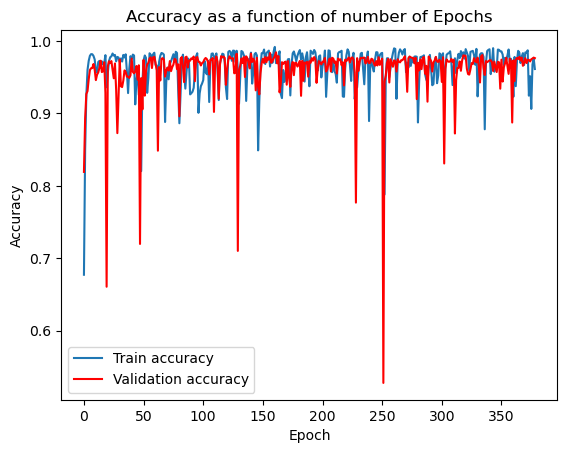

In [77]:
# your code here
eps = [i for i in range(len(history.history['val_accuracy']))]
plt.plot(eps,history.history['accuracy'],label="Train accuracy")
plt.plot(eps,history.history['val_accuracy'],label="Validation accuracy", color='red')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy as a function of number of Epochs")
plt.show()

<div class='exercise-r'>

**2.3.3**  In a few sentences, describe the various approaches you have taken to improve the performance of your regularized model in 2.3.1 as well as any observations you might have regarding your training and Kaggle results.


</div>

The various steps taken for improving the accuracy of the neural network are outlined close to the cells where they are carried out, along with detailed explanations as to how this may improve the accuracy. 

The hyperparameters were selected based on the best validation accuracy throughout the epochs. The focus was on using simple methods to reduce overfitting. 

Firstly, L2 and L1 regularization with different parameters were tried, and it was found that reglarization changes significantly across runs, but still improves accuracy, which is why we just automated this step. 

Secondly, dropout regularization was added with different dropout rates, and an optimal dropping rate of 0.1 was identified (we also automated this part in case it changed across runs). Surprisingly, Batch normalization did not lead to better validation accuracy.

After the regularization and dropout were fixed, the focus shifted to data augmentation. A simple data generator was employed to add Gaussian noise, and this helped to achieve an accuracy of greater than 98%. It is believed that a higher accuracy could be achieved by optimizing the data generation mechanism. However, due to time constraints, exploring other data augmentation methods was not possible. Adding the newly generated points to the `x_train` set was also found to be time-consuming (over 5 minutes each time). If more time was available, the first step would be to find a way to speed up the process, after which other data augmentation methods would be explored to improve the accuracy further.

<div class='exercise-r'>

**2.3.4**  Generate your test-set class predictions using your regularized model. Save those predictions to a `.csv` formatted file. Submit that `.csv` file [to the CS109B Kaggle Competition](#part2kaggle) for leaderboard scoring. **IMPORTANT:** For Kaggle to accept and score your submitted `.csv` file, it MUST contain 2 columns. The first column must be named `"Id"` and needs to contain the test observation index numbers corresponding to each of your 2,000 predictions (index starting at `0`), the second column must be named `"Category"` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location. Both columns should contain integer data types.




</div>

In [78]:
# your code here

y_test = model.predict(x_test)
preds = [int(np.round(i[0])) for i in y_test]
out = pd.DataFrame({'id':x_test.index, 'category':preds})

out.to_csv("hw3_kaggle_V1.csv", index=False)

63/63 [==============================] - 0s 859us/step


<div class='exercise-r'>

**2.3.5**  **Specify your Kaggle name that you have used on the leaderboard**. We CANNOT give you credit without this.

</div>

James Liounis

<!-- BEGIN QUESTION -->

<div class='exercise-r'><b>2.4 Wrap-up</b></div>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

Found the fact that we were not guided at all in the second part highly challenging (but very exciting at the same time!). 

In [79]:
hours_spent_on_hw = 20

In [80]:
grader.check("q2.4")

q2.4 results: All test cases passed!

In [81]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

It took 19.59 minutes for this notebook to run


**This concludes HW3. Thank you!**